# 📊 Financial Time-Series Generation: Diffusion Model (TimeGrad-Style)

## Project: Comparative Study of Diffusion Models and GANs

**Objective**: Implement a diffusion model for financial time-series generation and compare with TimeGAN

**Model**: TimeGrad-style denoising diffusion probabilistic model (DDPM)

**Dataset**: 25 financial assets (indices, stocks, crypto, commodities)

**Environment**: GPU-optimized with TensorFlow 2.10 + CUDA 11.2

---

### Notebook Structure:
1. **GPU Configuration & Setup**
2. **Diffusion Model Architecture**
3. **Training Pipeline**
4. **Synthetic Data Generation**
5. **Evaluation & Comparison with TimeGAN**

---

## 1. GPU Configuration & Imports

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import time
import pickle
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

warnings.filterwarnings('ignore')

print("=" * 80)
print("🔧 GPU CONFIGURATION & SETUP")
print("=" * 80)

# Check TensorFlow version
print(f"\nTensorFlow version: {tf.__version__}")

# GPU Configuration
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # DISABLE mixed precision due to cuDNN LayerNormalization issues
        # policy = tf.keras.mixed_precision.Policy('mixed_float16')
        # tf.keras.mixed_precision.set_global_policy(policy)
        
        print(f"\n✅ GPU detected: {len(gpus)} GPU(s) available")
        for i, gpu in enumerate(gpus):
            print(f"   GPU {i}: {gpu.name}")
        print(f"\n⚠️  Mixed precision DISABLED (cuDNN LayerNorm compatibility)")
        print(f"   Using float32 for stable training")
    except RuntimeError as e:
        print(f"❌ GPU configuration error: {e}")
else:
    print("\n⚠️  No GPU detected. Running on CPU...")

print("\n" + "=" * 80)

🔧 GPU CONFIGURATION & SETUP

TensorFlow version: 2.10.0

✅ GPU detected: 1 GPU(s) available
   GPU 0: /physical_device:GPU:0

⚠️  Mixed precision DISABLED (cuDNN LayerNorm compatibility)
   Using float32 for stable training



## 2. Configuration & Data Paths

In [3]:
# Directories
PROCESSED_DATA_DIR = '../../data/processed'
FEATURE_DATA_DIR = '../../data/features'
MODELS_DIR = '../../models/diffusion'
RESULTS_DIR = '../../outputs/results'
FIGURES_DIR = '../../outputs/figures'
SYNTHETIC_DATA_DIR = '../../data/synthetic/diffusion'

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(SYNTHETIC_DATA_DIR, exist_ok=True)

# Diffusion Model Hyperparameters - OPTIMIZED FOR QUALITY
CONFIG = {
    # Data parameters
    'seq_len': 48,           # Sequence length (same as TimeGAN)
    'n_features': None,      # Will be set based on data
    
    # Diffusion parameters
    'diffusion_steps': 1000,  # Total diffusion timesteps
    'beta_start': 0.0001,     # Initial noise schedule
    'beta_end': 0.02,         # Final noise schedule
    'noise_schedule': 'cosine',  # Cosine schedule (better than linear)
    
    # Network architecture - INCREASED CAPACITY
    'hidden_dim': 256,        # Increased from 128 for better representation
    'num_layers': 6,          # Increased from 4 for deeper network
    'num_heads': 8,           # Increased from 4 for better attention
    'dropout_rate': 0.1,      # Dropout rate
    
    # Training parameters - OPTIMIZED
    'batch_size': 64,         # Reduced for stability with larger model
    'learning_rate': 2e-4,    # Slightly increased for faster convergence
    'epochs': 200,            # Increased from 100 for better training
    'patience': 20,           # Increased patience for longer training
    'warmup_epochs': 10,      # Warmup for stable training
    'min_lr': 1e-6,           # Minimum learning rate
    
    # Generation parameters
    'num_inference_steps': 100, # Increased from 50 for better quality
}

print("📋 Diffusion Model Configuration:")
print("=" * 80)
for key, value in CONFIG.items():
    if value is not None:
        print(f"   {key:20s}: {value}")
print("=" * 80)

📋 Diffusion Model Configuration:
   seq_len             : 48
   diffusion_steps     : 1000
   beta_start          : 0.0001
   beta_end            : 0.02
   noise_schedule      : cosine
   hidden_dim          : 256
   num_layers          : 6
   num_heads           : 8
   dropout_rate        : 0.1
   batch_size          : 64
   learning_rate       : 0.0002
   epochs              : 200
   patience            : 20
   warmup_epochs       : 10
   min_lr              : 1e-06
   num_inference_steps : 100


## 3. Data Loading & Preprocessing (Reuse from TimeGAN)

In [4]:
def load_and_prepare_data(ticker, use_features=True):
    """Load and prepare financial data for diffusion model."""
    if use_features:
        file_path = os.path.join(FEATURE_DATA_DIR, f"{ticker}_features.csv")
    else:
        file_path = os.path.join(PROCESSED_DATA_DIR, f"{ticker}_processed.csv")
    
    # Load data
    df = pd.read_csv(file_path)
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
    
    # Select numeric features only
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    data = df[numeric_cols].values
    feature_names = numeric_cols
    
    # Handle infinity and NaN values
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Normalize to [0, 1]
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    
    print(f"✅ Loaded {ticker}: {data_scaled.shape}")
    print(f"   Features ({len(feature_names)}): {', '.join(feature_names[:5])}...")
    
    return data_scaled, scaler, feature_names

def create_sequences(data, seq_len):
    """Create overlapping sequences for training."""
    sequences = []
    for i in range(len(data) - seq_len + 1):
        sequences.append(data[i:i+seq_len])
    return np.array(sequences)

print("✅ Data loading functions defined")

✅ Data loading functions defined


## 4. Diffusion Process: Noise Scheduling

In [5]:
class NoiseScheduler:
    """
    Noise scheduling for diffusion process.
    Supports both linear and cosine schedules.
    """
    def __init__(self, num_timesteps, beta_start=0.0001, beta_end=0.02, schedule='cosine'):
        self.num_timesteps = num_timesteps
        
        # Choose beta schedule
        if schedule == 'cosine':
            # Cosine schedule (better for time-series)
            self.betas = self._cosine_beta_schedule(num_timesteps)
        else:
            # Linear beta schedule (DDPM default)
            self.betas = np.linspace(beta_start, beta_end, num_timesteps, dtype=np.float32)
        
        # Initialize all schedule parameters
        self._init_schedule_params()
    
    def _cosine_beta_schedule(self, timesteps, s=0.008):
        """
        Cosine schedule as proposed in Improved DDPM.
        Better for preventing oversaturation at high timesteps.
        """
        steps = timesteps + 1
        t = np.linspace(0, timesteps, steps, dtype=np.float32)
        alphas_cumprod = np.cos(((t / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return np.clip(betas, 0.0001, 0.9999).astype(np.float32)
    
    def _init_schedule_params(self):
        """Initialize schedule parameters after betas are set."""
        # Compute alphas
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = np.cumprod(self.alphas)
        self.alphas_cumprod_prev = np.append(1.0, self.alphas_cumprod[:-1])
        
        # Precompute values for diffusion q(x_t | x_0)
        self.sqrt_alphas_cumprod = np.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - self.alphas_cumprod)
        
        # Precompute values for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        
    def add_noise(self, x_0, t, noise=None):
        """
        Add noise to data according to diffusion forward process.
        q(x_t | x_0) = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * noise
        """
        if noise is None:
            noise = tf.random.normal(shape=tf.shape(x_0), dtype=tf.float32)
        
        sqrt_alpha_prod = tf.cast(tf.gather(self.sqrt_alphas_cumprod, t), tf.float32)
        sqrt_one_minus_alpha_prod = tf.cast(tf.gather(self.sqrt_one_minus_alphas_cumprod, t), tf.float32)
        
        # Ensure x_0 is float32
        x_0 = tf.cast(x_0, tf.float32)
        
        # Reshape for broadcasting
        sqrt_alpha_prod = tf.reshape(sqrt_alpha_prod, [-1, 1, 1])
        sqrt_one_minus_alpha_prod = tf.reshape(sqrt_one_minus_alpha_prod, [-1, 1, 1])
        
        return sqrt_alpha_prod * x_0 + sqrt_one_minus_alpha_prod * noise, noise
    
    def get_sampling_coefficients(self, t):
        """Get coefficients for sampling previous timestep."""
        alpha = tf.cast(tf.gather(self.alphas, t), tf.float32)
        alpha_cumprod = tf.cast(tf.gather(self.alphas_cumprod, t), tf.float32)
        alpha_cumprod_prev = tf.cast(tf.gather(self.alphas_cumprod_prev, t), tf.float32)
        beta = tf.cast(tf.gather(self.betas, t), tf.float32)
        
        return alpha, alpha_cumprod, alpha_cumprod_prev, beta

print("✅ NoiseScheduler class defined")

✅ NoiseScheduler class defined


## 5. Denoising Network (Temporal U-Net)

In [6]:
def sinusoidal_embedding(timesteps, embedding_dim):
    """
    Create sinusoidal timestep embeddings.
    Similar to positional encoding in transformers.
    """
    half_dim = embedding_dim // 2
    emb = np.log(10000) / (half_dim - 1)
    emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
    emb = tf.cast(timesteps, dtype=tf.float32)[:, None] * emb[None, :]
    emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
    return emb

def build_denoising_network(seq_len, n_features, hidden_dim, num_layers, num_heads, dropout_rate):
    """
    Build temporal denoising network for diffusion model.
    Architecture: Embedding + Multi-head attention + Residual blocks + Output projection
    """
    # Inputs
    noisy_input = Input(shape=(seq_len, n_features), name='noisy_input')
    timestep = Input(shape=(), dtype=tf.int32, name='timestep')
    
    # Timestep embedding
    t_emb = layers.Lambda(lambda t: sinusoidal_embedding(t, hidden_dim))(timestep)
    t_emb = layers.Dense(hidden_dim * 4, activation='swish')(t_emb)
    t_emb = layers.Dense(hidden_dim, activation='swish')(t_emb)
    
    # Input projection
    x = layers.Dense(hidden_dim)(noisy_input)
    
    # Add timestep embedding (broadcast across sequence)
    t_emb_expanded = layers.Reshape((1, hidden_dim))(t_emb)
    t_emb_tiled = layers.Lambda(lambda t: tf.tile(t, [1, seq_len, 1]))(t_emb_expanded)
    x = layers.Add()([x, t_emb_tiled])
    
    # Temporal processing with residual blocks
    for i in range(num_layers):
        # Multi-head self-attention
        residual = x
        attn_out = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=hidden_dim // num_heads,
            dropout=dropout_rate,
            name=f'attention_{i}'
        )(x, x)
        x = layers.Add()([residual, attn_out])
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        
        # Feed-forward network
        residual = x
        ff = layers.Dense(hidden_dim * 4, activation='swish')(x)
        ff = layers.Dropout(dropout_rate)(ff)
        ff = layers.Dense(hidden_dim)(ff)
        x = layers.Add()([residual, ff])
        x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # Output projection to predict noise (no explicit dtype needed)
    noise_pred = layers.Dense(n_features, name='noise_output')(x)
    
    model = Model(inputs=[noisy_input, timestep], outputs=noise_pred, name='DenoisingNetwork')
    return model

print("✅ Denoising network architecture defined")

✅ Denoising network architecture defined


## 6. Diffusion Model Training Class

In [7]:
class DiffusionModel:
    """
    Diffusion model for financial time-series generation.
    Implements DDPM-style training and sampling.
    """
    
    def __init__(self, config):
        self.config = config
        self.seq_len = config['seq_len']
        self.n_features = config['n_features']
        
        # Initialize noise scheduler
        self.noise_scheduler = NoiseScheduler(
            num_timesteps=config['diffusion_steps'],
            beta_start=config['beta_start'],
            beta_end=config['beta_end'],
            schedule=config.get('noise_schedule', 'linear')
        )
        
        # Build denoising network
        self.model = build_denoising_network(
            seq_len=self.seq_len,
            n_features=self.n_features,
            hidden_dim=config['hidden_dim'],
            num_layers=config['num_layers'],
            num_heads=config['num_heads'],
            dropout_rate=config['dropout_rate']
        )
        
        # Compile model
        self.model.compile(
            optimizer=Adam(learning_rate=config['learning_rate']),
            loss='mse',
            metrics=['mae']
        )
        
        self.history = None
    
    @tf.function
    def train_step(self, x_batch):
        """Single training step."""
        batch_size = tf.shape(x_batch)[0]
        
        # Sample random timesteps
        t = tf.random.uniform(
            (batch_size,), 
            minval=0, 
            maxval=self.config['diffusion_steps'],
            dtype=tf.int32
        )
        
        # Add noise
        noise = tf.random.normal(shape=tf.shape(x_batch))
        x_noisy, _ = self.noise_scheduler.add_noise(x_batch, t, noise)
        
        # Predict noise
        with tf.GradientTape() as tape:
            noise_pred = self.model([x_noisy, t], training=True)
            loss = tf.reduce_mean(tf.square(noise - noise_pred))
        
        # Update weights
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        
        return loss
    
    def train(self, data, epochs, batch_size):
        """Train the diffusion model with learning rate warmup and scheduling."""
        dataset = tf.data.Dataset.from_tensor_slices(data)
        dataset = dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        
        history = {'loss': [], 'lr': []}
        best_loss = float('inf')
        patience_counter = 0
        
        # Warmup parameters
        warmup_epochs = self.config.get('warmup_epochs', 0)
        base_lr = self.config['learning_rate']
        min_lr = self.config.get('min_lr', 1e-6)
        
        for epoch in range(epochs):
            # Learning rate schedule with warmup
            if epoch < warmup_epochs:
                # Linear warmup
                lr = base_lr * (epoch + 1) / warmup_epochs
            else:
                # Cosine annealing after warmup
                progress = (epoch - warmup_epochs) / max(1, epochs - warmup_epochs)
                lr = min_lr + 0.5 * (base_lr - min_lr) * (1 + np.cos(np.pi * progress))
            
            # Update learning rate
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
            history['lr'].append(lr)
            
            epoch_losses = []
            
            pbar = tqdm(dataset, desc=f'Epoch {epoch+1}/{epochs}')
            for batch in pbar:
                loss = self.train_step(batch)
                epoch_losses.append(loss.numpy())
                pbar.set_postfix({'loss': f'{loss.numpy():.4f}', 'lr': f'{lr:.6f}'})
            
            avg_loss = np.mean(epoch_losses)
            history['loss'].append(avg_loss)
            
            print(f'Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.6f} - LR: {lr:.6f}')
            
            # Early stopping with patience
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
            else:
                patience_counter += 1
            
            if patience_counter >= self.config['patience']:
                print(f"✋ Early stopping at epoch {epoch+1} (best loss: {best_loss:.6f})")
                break
        
        self.history = history
        return history
    
    @tf.function
    def denoise_step(self, x_t, t):
        """Single denoising step in reverse diffusion."""
        eps = 1e-8  # Small constant for numerical stability
        
        # Predict noise
        noise_pred = self.model([x_t, tf.fill([tf.shape(x_t)[0]], t)], training=False)
        
        # Get coefficients
        alpha, alpha_cumprod, alpha_cumprod_prev, beta = self.noise_scheduler.get_sampling_coefficients(t)
        
        # Reshape for broadcasting
        alpha = tf.reshape(alpha, [1, 1, 1])
        alpha_cumprod = tf.reshape(alpha_cumprod, [1, 1, 1])
        alpha_cumprod_prev = tf.reshape(alpha_cumprod_prev, [1, 1, 1])
        beta = tf.reshape(beta, [1, 1, 1])
        
        # Compute x_{t-1} with numerical stability
        sqrt_alpha_cumprod = tf.sqrt(tf.maximum(alpha_cumprod, eps))
        sqrt_one_minus_alpha_cumprod = tf.sqrt(tf.maximum(1.0 - alpha_cumprod, eps))
        
        # Predicted x_0
        pred_x0 = (x_t - sqrt_one_minus_alpha_cumprod * noise_pred) / (sqrt_alpha_cumprod + eps)
        pred_x0 = tf.clip_by_value(pred_x0, 0.0, 1.0)  # Clip to valid range
        
        # DDPM sampling formula
        sqrt_alpha_cumprod_prev = tf.sqrt(tf.maximum(alpha_cumprod_prev, eps))
        sqrt_alpha = tf.sqrt(tf.maximum(alpha, eps))
        
        # Predict mean
        coef1 = sqrt_alpha_cumprod_prev * beta / (1.0 - alpha_cumprod + eps)
        coef2 = sqrt_alpha * (1.0 - alpha_cumprod_prev) / (1.0 - alpha_cumprod + eps)
        pred_mean = coef1 * pred_x0 + coef2 * x_t
        
        # Add noise if not final step
        if t > 0:
            noise = tf.random.normal(shape=tf.shape(x_t))
            pred_mean = pred_mean + tf.sqrt(tf.maximum(beta, eps)) * noise
        
        return tf.clip_by_value(pred_mean, 0.0, 1.0)
    
    def generate_samples(self, n_samples):
        """Generate synthetic samples using reverse diffusion."""
        # Start from pure noise
        x = tf.random.normal((n_samples, self.seq_len, self.n_features))
        
        # Reverse diffusion
        num_steps = self.config['num_inference_steps']
        step_size = self.config['diffusion_steps'] // num_steps
        
        for i in tqdm(range(num_steps-1, -1, -1), desc='Generating samples'):
            t = i * step_size
            x = self.denoise_step(x, t)
        
        return x.numpy()
    
    def save_model(self, path):
        """Save the model."""
        os.makedirs(path, exist_ok=True)
        self.model.save(os.path.join(path, 'denoising_network.h5'))
        
        # Save noise scheduler parameters
        scheduler_params = {
            'num_timesteps': self.config['diffusion_steps'],
            'beta_start': self.config['beta_start'],
            'beta_end': self.config['beta_end']
        }
        with open(os.path.join(path, 'scheduler_params.pkl'), 'wb') as f:
            pickle.dump(scheduler_params, f)
        
        print(f"💾 Model saved to {path}")
    
    def load_model(self, path):
        """Load the model."""
        self.model = keras.models.load_model(os.path.join(path, 'denoising_network.h5'))
        print(f"✅ Model loaded from {path}")

print("✅ DiffusionModel class defined")

✅ DiffusionModel class defined


## 7. Evaluation Functions (Reuse from TimeGAN)

In [8]:
def evaluate_synthetic_data(real_sequences, synthetic_sequences, feature_names):
    """
    Evaluate quality of synthetic data.
    Same evaluation as TimeGAN for fair comparison.
    """
    # Reshape to 2D for analysis
    real_flat = real_sequences.reshape(-1, real_sequences.shape[2])
    synthetic_flat = synthetic_sequences.reshape(-1, synthetic_sequences.shape[2])
    
    # Remove NaN values
    synthetic_flat = np.nan_to_num(synthetic_flat, nan=0.0, posinf=1.0, neginf=0.0)
    
    results = {
        'feature_names': feature_names,
        'ks_stats': [],
        'ks_pvalues': [],
        'statistics': []
    }
    
    for i, feature in enumerate(feature_names):
        real_feature = real_flat[:, i]
        synthetic_feature = synthetic_flat[:, i]
        
        # Kolmogorov-Smirnov test
        ks_stat, ks_pval = stats.ks_2samp(real_feature, synthetic_feature)
        results['ks_stats'].append(ks_stat)
        results['ks_pvalues'].append(ks_pval)
        
        # Compute statistics
        stats_dict = {
            'Feature': feature,
            'Real_Mean': np.mean(real_feature),
            'Synthetic_Mean': np.mean(synthetic_feature),
            'Mean_Diff': np.abs(np.mean(real_feature) - np.mean(synthetic_feature)),
            'Real_Std': np.std(real_feature),
            'Synthetic_Std': np.std(synthetic_feature),
            'Std_Diff': np.abs(np.std(real_feature) - np.std(synthetic_feature)),
            'KS_Stat': ks_stat,
            'KS_PValue': ks_pval
        }
        results['statistics'].append(stats_dict)
    
    results['statistics'] = pd.DataFrame(results['statistics'])
    
    return results

def visualize_synthetic_data(real_sequences, synthetic_sequences, feature_names, ticker, save_path):
    """Visualize comparison between real and synthetic data."""
    real_flat = real_sequences.reshape(-1, real_sequences.shape[2])
    synthetic_flat = synthetic_sequences.reshape(-1, synthetic_sequences.shape[2])
    
    # Remove NaN values
    synthetic_flat = np.nan_to_num(synthetic_flat, nan=0.0, posinf=1.0, neginf=0.0)
    
    # Select 5 key features to visualize
    n_features_to_plot = min(5, len(feature_names))
    selected_features = feature_names[:n_features_to_plot]
    
    fig, axes = plt.subplots(n_features_to_plot, 2, figsize=(14, 3*n_features_to_plot))
    
    for i, feature in enumerate(selected_features):
        real_feature = real_flat[:, i]
        synthetic_feature = synthetic_flat[:, i]
        
        # Time series comparison
        ax1 = axes[i, 0] if n_features_to_plot > 1 else axes[0]
        sample_len = min(500, len(real_feature))
        ax1.plot(real_feature[:sample_len], label='Real', alpha=0.7, linewidth=0.8)
        ax1.plot(synthetic_feature[:sample_len], label='Synthetic', alpha=0.7, linewidth=0.8)
        ax1.set_title(f'{feature} - Time Series')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Value')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Distribution comparison
        ax2 = axes[i, 1] if n_features_to_plot > 1 else axes[1]
        ax2.hist(real_feature, bins=50, alpha=0.5, label='Real', density=True)
        ax2.hist(synthetic_feature, bins=50, alpha=0.5, label='Synthetic', density=True)
        ax2.set_title(f'{feature} - Distribution')
        ax2.set_xlabel('Value')
        ax2.set_ylabel('Density')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.suptitle(f'Diffusion Model: Real vs Synthetic Data - {ticker}', fontsize=14, y=1.001)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"📊 Visualization saved to {save_path}")

print("✅ Evaluation functions defined")

✅ Evaluation functions defined


## 8. Training: Sample Asset (GSPC)

Testing diffusion model on S&P 500 index data

TRAINING DIFFUSION MODEL ON GSPC (1/3)
✅ Loaded GSPC: (2514, 108)
   Features (108): Open, High, Low, Close, Volume...

📊 Data prepared:
   Sequences: (2467, 48, 108)
   Features: 108

🏗️ Model architecture:
Model: "DenoisingNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 timestep (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 lambda_4 (Lambda)              (None, 256)          0           ['timestep[0][0]']               
                                                                                                  
 dense_26 (Dense)               (None, 1024)         263168      ['lambda_4[0][0]']               
                                                                         

Epoch 1/200: 100%|██████████| 39/39 [00:15<00:00,  2.58it/s, loss=1.1250, lr=0.000020]


Epoch 1/200 - Loss: 1.572107 - LR: 0.000020


Epoch 2/200: 100%|██████████| 39/39 [00:09<00:00,  4.29it/s, loss=0.9742, lr=0.000040]


Epoch 2/200 - Loss: 1.006828 - LR: 0.000040


Epoch 3/200: 100%|██████████| 39/39 [00:09<00:00,  4.28it/s, loss=0.8429, lr=0.000060]


Epoch 3/200 - Loss: 0.916724 - LR: 0.000060


Epoch 4/200: 100%|██████████| 39/39 [00:09<00:00,  4.28it/s, loss=0.6479, lr=0.000080]


Epoch 4/200 - Loss: 0.735700 - LR: 0.000080


Epoch 5/200: 100%|██████████| 39/39 [00:10<00:00,  3.80it/s, loss=0.4396, lr=0.000100]


Epoch 5/200 - Loss: 0.533205 - LR: 0.000100


Epoch 6/200: 100%|██████████| 39/39 [00:12<00:00,  3.17it/s, loss=0.3323, lr=0.000120]


Epoch 6/200 - Loss: 0.388070 - LR: 0.000120


Epoch 7/200: 100%|██████████| 39/39 [00:11<00:00,  3.31it/s, loss=0.2536, lr=0.000140]


Epoch 7/200 - Loss: 0.302385 - LR: 0.000140


Epoch 8/200: 100%|██████████| 39/39 [00:10<00:00,  3.70it/s, loss=0.2175, lr=0.000160]


Epoch 8/200 - Loss: 0.240755 - LR: 0.000160


Epoch 9/200: 100%|██████████| 39/39 [00:10<00:00,  3.69it/s, loss=0.2057, lr=0.000180]



Epoch 9/200 - Loss: 0.200060 - LR: 0.000180


Epoch 10/200: 100%|██████████| 39/39 [00:13<00:00,  2.80it/s, loss=0.1539, lr=0.000200]



Epoch 10/200 - Loss: 0.175249 - LR: 0.000200


Epoch 11/200: 100%|██████████| 39/39 [00:12<00:00,  3.16it/s, loss=0.1507, lr=0.000200]


Epoch 11/200 - Loss: 0.165740 - LR: 0.000200


Epoch 12/200: 100%|██████████| 39/39 [00:10<00:00,  3.80it/s, loss=0.1224, lr=0.000200]


Epoch 12/200 - Loss: 0.152553 - LR: 0.000200


Epoch 13/200: 100%|██████████| 39/39 [00:16<00:00,  2.37it/s, loss=0.1100, lr=0.000200]


Epoch 13/200 - Loss: 0.150389 - LR: 0.000200


Epoch 14/200: 100%|██████████| 39/39 [00:12<00:00,  3.23it/s, loss=0.1249, lr=0.000200]


Epoch 14/200 - Loss: 0.133136 - LR: 0.000200


Epoch 15/200: 100%|██████████| 39/39 [00:11<00:00,  3.50it/s, loss=0.1257, lr=0.000200]


Epoch 15/200 - Loss: 0.131091 - LR: 0.000200


Epoch 16/200: 100%|██████████| 39/39 [00:13<00:00,  2.99it/s, loss=0.1133, lr=0.000200]


Epoch 16/200 - Loss: 0.122873 - LR: 0.000200


Epoch 17/200: 100%|██████████| 39/39 [00:11<00:00,  3.44it/s, loss=0.1326, lr=0.000200]


Epoch 17/200 - Loss: 0.116032 - LR: 0.000200


Epoch 18/200: 100%|██████████| 39/39 [00:10<00:00,  3.59it/s, loss=0.1064, lr=0.000199]


Epoch 18/200 - Loss: 0.108993 - LR: 0.000199


Epoch 19/200: 100%|██████████| 39/39 [00:11<00:00,  3.52it/s, loss=0.0947, lr=0.000199]


Epoch 19/200 - Loss: 0.106287 - LR: 0.000199


Epoch 20/200: 100%|██████████| 39/39 [00:09<00:00,  4.09it/s, loss=0.1228, lr=0.000199]


Epoch 20/200 - Loss: 0.103947 - LR: 0.000199


Epoch 21/200: 100%|██████████| 39/39 [00:09<00:00,  4.19it/s, loss=0.0884, lr=0.000199]



Epoch 21/200 - Loss: 0.099718 - LR: 0.000199


Epoch 22/200: 100%|██████████| 39/39 [00:09<00:00,  4.19it/s, loss=0.1115, lr=0.000198]



Epoch 22/200 - Loss: 0.096217 - LR: 0.000198


Epoch 23/200: 100%|██████████| 39/39 [00:09<00:00,  4.20it/s, loss=0.0786, lr=0.000198]



Epoch 23/200 - Loss: 0.094857 - LR: 0.000198


Epoch 24/200: 100%|██████████| 39/39 [00:09<00:00,  4.18it/s, loss=0.0796, lr=0.000198]


Epoch 24/200 - Loss: 0.095185 - LR: 0.000198


Epoch 25/200: 100%|██████████| 39/39 [00:09<00:00,  4.19it/s, loss=0.0771, lr=0.000197]



Epoch 25/200 - Loss: 0.091668 - LR: 0.000197


Epoch 26/200: 100%|██████████| 39/39 [00:09<00:00,  4.18it/s, loss=0.0598, lr=0.000197]



Epoch 26/200 - Loss: 0.088203 - LR: 0.000197


Epoch 27/200: 100%|██████████| 39/39 [00:10<00:00,  3.70it/s, loss=0.1015, lr=0.000197]



Epoch 27/200 - Loss: 0.082005 - LR: 0.000197


Epoch 28/200: 100%|██████████| 39/39 [00:09<00:00,  4.01it/s, loss=0.0802, lr=0.000196]



Epoch 28/200 - Loss: 0.083472 - LR: 0.000196


Epoch 29/200: 100%|██████████| 39/39 [00:10<00:00,  3.73it/s, loss=0.0943, lr=0.000196]


Epoch 29/200 - Loss: 0.089926 - LR: 0.000196


Epoch 30/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0919, lr=0.000195]


Epoch 30/200 - Loss: 0.084716 - LR: 0.000195


Epoch 31/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0703, lr=0.000195]



Epoch 31/200 - Loss: 0.080889 - LR: 0.000195


Epoch 32/200: 100%|██████████| 39/39 [00:09<00:00,  4.17it/s, loss=0.0725, lr=0.000194]


Epoch 32/200 - Loss: 0.079493 - LR: 0.000194


Epoch 33/200: 100%|██████████| 39/39 [00:09<00:00,  4.19it/s, loss=0.0817, lr=0.000193]



Epoch 33/200 - Loss: 0.078190 - LR: 0.000193


Epoch 34/200: 100%|██████████| 39/39 [00:09<00:00,  4.12it/s, loss=0.0596, lr=0.000193]



Epoch 34/200 - Loss: 0.076144 - LR: 0.000193


Epoch 35/200: 100%|██████████| 39/39 [00:09<00:00,  4.07it/s, loss=0.0563, lr=0.000192]


Epoch 35/200 - Loss: 0.073607 - LR: 0.000192


Epoch 36/200: 100%|██████████| 39/39 [00:10<00:00,  3.61it/s, loss=0.0577, lr=0.000192]


Epoch 36/200 - Loss: 0.077905 - LR: 0.000192


Epoch 37/200: 100%|██████████| 39/39 [00:09<00:00,  3.96it/s, loss=0.0708, lr=0.000191]


Epoch 37/200 - Loss: 0.078170 - LR: 0.000191


Epoch 38/200: 100%|██████████| 39/39 [00:13<00:00,  2.99it/s, loss=0.0634, lr=0.000190]


Epoch 38/200 - Loss: 0.074790 - LR: 0.000190


Epoch 39/200: 100%|██████████| 39/39 [00:17<00:00,  2.26it/s, loss=0.0546, lr=0.000190]


Epoch 39/200 - Loss: 0.075106 - LR: 0.000190


Epoch 40/200: 100%|██████████| 39/39 [00:11<00:00,  3.35it/s, loss=0.0855, lr=0.000189]


Epoch 40/200 - Loss: 0.073935 - LR: 0.000189


Epoch 41/200: 100%|██████████| 39/39 [00:12<00:00,  3.04it/s, loss=0.0802, lr=0.000188]


Epoch 41/200 - Loss: 0.074261 - LR: 0.000188


Epoch 42/200: 100%|██████████| 39/39 [00:13<00:00,  2.82it/s, loss=0.0769, lr=0.000187]


Epoch 42/200 - Loss: 0.073576 - LR: 0.000187


Epoch 43/200: 100%|██████████| 39/39 [00:12<00:00,  3.04it/s, loss=0.0795, lr=0.000186]


Epoch 43/200 - Loss: 0.069008 - LR: 0.000186


Epoch 44/200: 100%|██████████| 39/39 [00:10<00:00,  3.56it/s, loss=0.0582, lr=0.000186]



Epoch 44/200 - Loss: 0.068760 - LR: 0.000186


Epoch 45/200: 100%|██████████| 39/39 [00:09<00:00,  4.14it/s, loss=0.0610, lr=0.000185]


Epoch 45/200 - Loss: 0.073698 - LR: 0.000185


Epoch 46/200: 100%|██████████| 39/39 [00:09<00:00,  4.20it/s, loss=0.0755, lr=0.000184]



Epoch 46/200 - Loss: 0.069991 - LR: 0.000184


Epoch 47/200: 100%|██████████| 39/39 [00:09<00:00,  4.08it/s, loss=0.0716, lr=0.000183]


Epoch 47/200 - Loss: 0.069477 - LR: 0.000183


Epoch 48/200: 100%|██████████| 39/39 [00:10<00:00,  3.72it/s, loss=0.0818, lr=0.000182]


Epoch 48/200 - Loss: 0.070221 - LR: 0.000182


Epoch 49/200: 100%|██████████| 39/39 [00:10<00:00,  3.71it/s, loss=0.0602, lr=0.000181]



Epoch 49/200 - Loss: 0.069097 - LR: 0.000181


Epoch 50/200: 100%|██████████| 39/39 [00:09<00:00,  4.14it/s, loss=0.0778, lr=0.000180]



Epoch 50/200 - Loss: 0.067811 - LR: 0.000180


Epoch 51/200: 100%|██████████| 39/39 [00:10<00:00,  3.71it/s, loss=0.0570, lr=0.000179]


Epoch 51/200 - Loss: 0.065691 - LR: 0.000179


Epoch 52/200: 100%|██████████| 39/39 [00:10<00:00,  3.60it/s, loss=0.0920, lr=0.000178]


Epoch 52/200 - Loss: 0.067115 - LR: 0.000178


Epoch 53/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0680, lr=0.000177]


Epoch 53/200 - Loss: 0.067688 - LR: 0.000177


Epoch 54/200: 100%|██████████| 39/39 [00:10<00:00,  3.82it/s, loss=0.0664, lr=0.000176]


Epoch 54/200 - Loss: 0.066410 - LR: 0.000176


Epoch 55/200: 100%|██████████| 39/39 [00:10<00:00,  3.76it/s, loss=0.0497, lr=0.000175]



Epoch 55/200 - Loss: 0.063106 - LR: 0.000175


Epoch 56/200: 100%|██████████| 39/39 [00:10<00:00,  3.78it/s, loss=0.0522, lr=0.000174]



Epoch 56/200 - Loss: 0.068159 - LR: 0.000174


Epoch 57/200: 100%|██████████| 39/39 [00:10<00:00,  3.81it/s, loss=0.0740, lr=0.000173]



Epoch 57/200 - Loss: 0.063902 - LR: 0.000173


Epoch 58/200: 100%|██████████| 39/39 [00:10<00:00,  3.79it/s, loss=0.0827, lr=0.000171]



Epoch 58/200 - Loss: 0.061875 - LR: 0.000171


Epoch 59/200: 100%|██████████| 39/39 [00:10<00:00,  3.79it/s, loss=0.0617, lr=0.000170]



Epoch 59/200 - Loss: 0.064611 - LR: 0.000170


Epoch 60/200: 100%|██████████| 39/39 [00:10<00:00,  3.78it/s, loss=0.0400, lr=0.000169]



Epoch 60/200 - Loss: 0.064247 - LR: 0.000169


Epoch 61/200: 100%|██████████| 39/39 [00:10<00:00,  3.79it/s, loss=0.0476, lr=0.000168]



Epoch 61/200 - Loss: 0.063379 - LR: 0.000168


Epoch 62/200: 100%|██████████| 39/39 [00:10<00:00,  3.78it/s, loss=0.0682, lr=0.000167]



Epoch 62/200 - Loss: 0.063988 - LR: 0.000167


Epoch 63/200: 100%|██████████| 39/39 [00:10<00:00,  3.79it/s, loss=0.0740, lr=0.000165]



Epoch 63/200 - Loss: 0.063885 - LR: 0.000165


Epoch 64/200: 100%|██████████| 39/39 [00:10<00:00,  3.77it/s, loss=0.0558, lr=0.000164]



Epoch 64/200 - Loss: 0.060700 - LR: 0.000164


Epoch 65/200: 100%|██████████| 39/39 [00:10<00:00,  3.78it/s, loss=0.0592, lr=0.000163]



Epoch 65/200 - Loss: 0.058753 - LR: 0.000163


Epoch 66/200: 100%|██████████| 39/39 [00:10<00:00,  3.78it/s, loss=0.0632, lr=0.000162]



Epoch 66/200 - Loss: 0.062793 - LR: 0.000162


Epoch 67/200: 100%|██████████| 39/39 [00:10<00:00,  3.80it/s, loss=0.0641, lr=0.000160]



Epoch 67/200 - Loss: 0.060372 - LR: 0.000160


Epoch 68/200: 100%|██████████| 39/39 [00:10<00:00,  3.80it/s, loss=0.0469, lr=0.000159]


Epoch 68/200 - Loss: 0.059279 - LR: 0.000159


Epoch 69/200: 100%|██████████| 39/39 [00:10<00:00,  3.78it/s, loss=0.0615, lr=0.000158]



Epoch 69/200 - Loss: 0.058414 - LR: 0.000158


Epoch 70/200: 100%|██████████| 39/39 [00:10<00:00,  3.79it/s, loss=0.0511, lr=0.000156]



Epoch 70/200 - Loss: 0.060106 - LR: 0.000156


Epoch 71/200: 100%|██████████| 39/39 [00:10<00:00,  3.77it/s, loss=0.0450, lr=0.000155]



Epoch 71/200 - Loss: 0.060929 - LR: 0.000155


Epoch 72/200: 100%|██████████| 39/39 [00:10<00:00,  3.77it/s, loss=0.0458, lr=0.000154]



Epoch 72/200 - Loss: 0.058708 - LR: 0.000154


Epoch 73/200: 100%|██████████| 39/39 [00:10<00:00,  3.79it/s, loss=0.0666, lr=0.000152]



Epoch 73/200 - Loss: 0.059977 - LR: 0.000152


Epoch 74/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0919, lr=0.000151]


Epoch 74/200 - Loss: 0.059081 - LR: 0.000151


Epoch 75/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0502, lr=0.000149]



Epoch 75/200 - Loss: 0.060268 - LR: 0.000149


Epoch 76/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0606, lr=0.000148]


Epoch 76/200 - Loss: 0.057271 - LR: 0.000148


Epoch 77/200: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.0463, lr=0.000146]


Epoch 77/200 - Loss: 0.057727 - LR: 0.000146


Epoch 78/200: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.0437, lr=0.000145]


Epoch 78/200 - Loss: 0.058638 - LR: 0.000145


Epoch 79/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0523, lr=0.000143]


Epoch 79/200 - Loss: 0.054567 - LR: 0.000143


Epoch 80/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0533, lr=0.000142]


Epoch 80/200 - Loss: 0.054303 - LR: 0.000142


Epoch 81/200: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.0511, lr=0.000140]


Epoch 81/200 - Loss: 0.054529 - LR: 0.000140


Epoch 82/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0716, lr=0.000139]


Epoch 82/200 - Loss: 0.055779 - LR: 0.000139


Epoch 83/200: 100%|██████████| 39/39 [00:10<00:00,  3.81it/s, loss=0.0458, lr=0.000137]


Epoch 83/200 - Loss: 0.052846 - LR: 0.000137


Epoch 84/200: 100%|██████████| 39/39 [00:10<00:00,  3.83it/s, loss=0.0561, lr=0.000136]


Epoch 84/200 - Loss: 0.056930 - LR: 0.000136


Epoch 85/200: 100%|██████████| 39/39 [00:10<00:00,  3.82it/s, loss=0.0377, lr=0.000134]


Epoch 85/200 - Loss: 0.053468 - LR: 0.000134


Epoch 86/200: 100%|██████████| 39/39 [00:09<00:00,  4.10it/s, loss=0.0703, lr=0.000133]



Epoch 86/200 - Loss: 0.057891 - LR: 0.000133


Epoch 87/200: 100%|██████████| 39/39 [00:10<00:00,  3.74it/s, loss=0.0560, lr=0.000131]


Epoch 87/200 - Loss: 0.053794 - LR: 0.000131


Epoch 88/200: 100%|██████████| 39/39 [00:10<00:00,  3.77it/s, loss=0.0515, lr=0.000130]


Epoch 88/200 - Loss: 0.055996 - LR: 0.000130


Epoch 89/200: 100%|██████████| 39/39 [00:10<00:00,  3.78it/s, loss=0.0468, lr=0.000128]


Epoch 89/200 - Loss: 0.054461 - LR: 0.000128


Epoch 90/200: 100%|██████████| 39/39 [00:10<00:00,  3.66it/s, loss=0.0483, lr=0.000127]


Epoch 90/200 - Loss: 0.052315 - LR: 0.000127


Epoch 91/200: 100%|██████████| 39/39 [00:11<00:00,  3.49it/s, loss=0.0454, lr=0.000125]


Epoch 91/200 - Loss: 0.052662 - LR: 0.000125


Epoch 92/200: 100%|██████████| 39/39 [00:10<00:00,  3.61it/s, loss=0.0550, lr=0.000123]



Epoch 92/200 - Loss: 0.053787 - LR: 0.000123


Epoch 93/200: 100%|██████████| 39/39 [00:10<00:00,  3.78it/s, loss=0.0434, lr=0.000122]


Epoch 93/200 - Loss: 0.052969 - LR: 0.000122


Epoch 94/200: 100%|██████████| 39/39 [00:10<00:00,  3.66it/s, loss=0.0690, lr=0.000120]


Epoch 94/200 - Loss: 0.054164 - LR: 0.000120


Epoch 95/200: 100%|██████████| 39/39 [00:10<00:00,  3.68it/s, loss=0.0393, lr=0.000118]


Epoch 95/200 - Loss: 0.052860 - LR: 0.000118


Epoch 96/200: 100%|██████████| 39/39 [00:10<00:00,  3.56it/s, loss=0.0822, lr=0.000117]


Epoch 96/200 - Loss: 0.050255 - LR: 0.000117


Epoch 97/200: 100%|██████████| 39/39 [00:12<00:00,  3.05it/s, loss=0.0283, lr=0.000115]


Epoch 97/200 - Loss: 0.049650 - LR: 0.000115


Epoch 98/200: 100%|██████████| 39/39 [00:12<00:00,  3.19it/s, loss=0.0631, lr=0.000114]


Epoch 98/200 - Loss: 0.049806 - LR: 0.000114


Epoch 99/200: 100%|██████████| 39/39 [00:12<00:00,  3.24it/s, loss=0.0479, lr=0.000112]


Epoch 99/200 - Loss: 0.051765 - LR: 0.000112


Epoch 100/200: 100%|██████████| 39/39 [00:11<00:00,  3.47it/s, loss=0.0418, lr=0.000110]



Epoch 100/200 - Loss: 0.052739 - LR: 0.000110


Epoch 101/200: 100%|██████████| 39/39 [00:11<00:00,  3.50it/s, loss=0.0619, lr=0.000109]



Epoch 101/200 - Loss: 0.052332 - LR: 0.000109


Epoch 102/200: 100%|██████████| 39/39 [00:11<00:00,  3.33it/s, loss=0.0551, lr=0.000107]


Epoch 102/200 - Loss: 0.050495 - LR: 0.000107


Epoch 103/200: 100%|██████████| 39/39 [00:12<00:00,  3.19it/s, loss=0.0377, lr=0.000105]


Epoch 103/200 - Loss: 0.050219 - LR: 0.000105


Epoch 104/200: 100%|██████████| 39/39 [00:10<00:00,  3.82it/s, loss=0.0574, lr=0.000104]


Epoch 104/200 - Loss: 0.050201 - LR: 0.000104


Epoch 105/200: 100%|██████████| 39/39 [00:10<00:00,  3.75it/s, loss=0.0444, lr=0.000102]


Epoch 105/200 - Loss: 0.051458 - LR: 0.000102


Epoch 106/200: 100%|██████████| 39/39 [00:10<00:00,  3.62it/s, loss=0.0480, lr=0.000101]


Epoch 106/200 - Loss: 0.052741 - LR: 0.000101


Epoch 107/200: 100%|██████████| 39/39 [00:10<00:00,  3.58it/s, loss=0.0848, lr=0.000099]



Epoch 107/200 - Loss: 0.051806 - LR: 0.000099


Epoch 108/200: 100%|██████████| 39/39 [00:10<00:00,  3.71it/s, loss=0.0502, lr=0.000097]


Epoch 108/200 - Loss: 0.052514 - LR: 0.000097


Epoch 109/200: 100%|██████████| 39/39 [00:10<00:00,  3.56it/s, loss=0.0421, lr=0.000096]


Epoch 109/200 - Loss: 0.050384 - LR: 0.000096


Epoch 110/200: 100%|██████████| 39/39 [00:11<00:00,  3.38it/s, loss=0.0396, lr=0.000094]



Epoch 110/200 - Loss: 0.048222 - LR: 0.000094


Epoch 111/200: 100%|██████████| 39/39 [00:11<00:00,  3.43it/s, loss=0.0554, lr=0.000092]



Epoch 111/200 - Loss: 0.049719 - LR: 0.000092


Epoch 112/200: 100%|██████████| 39/39 [00:10<00:00,  3.83it/s, loss=0.0429, lr=0.000091]


Epoch 112/200 - Loss: 0.048248 - LR: 0.000091


Epoch 113/200: 100%|██████████| 39/39 [00:11<00:00,  3.28it/s, loss=0.0428, lr=0.000089]



Epoch 113/200 - Loss: 0.050204 - LR: 0.000089


Epoch 114/200: 100%|██████████| 39/39 [00:12<00:00,  3.23it/s, loss=0.0535, lr=0.000087]


Epoch 114/200 - Loss: 0.049454 - LR: 0.000087


Epoch 115/200: 100%|██████████| 39/39 [00:12<00:00,  3.19it/s, loss=0.0692, lr=0.000086]


Epoch 115/200 - Loss: 0.048377 - LR: 0.000086


Epoch 116/200: 100%|██████████| 39/39 [00:11<00:00,  3.53it/s, loss=0.0399, lr=0.000084]



Epoch 116/200 - Loss: 0.048285 - LR: 0.000084


Epoch 117/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0463, lr=0.000083]


Epoch 117/200 - Loss: 0.046266 - LR: 0.000083


Epoch 118/200: 100%|██████████| 39/39 [00:10<00:00,  3.76it/s, loss=0.0679, lr=0.000081]


Epoch 118/200 - Loss: 0.050158 - LR: 0.000081


Epoch 119/200: 100%|██████████| 39/39 [00:10<00:00,  3.61it/s, loss=0.0466, lr=0.000079]


Epoch 119/200 - Loss: 0.049017 - LR: 0.000079


Epoch 120/200: 100%|██████████| 39/39 [00:11<00:00,  3.43it/s, loss=0.0356, lr=0.000078]



Epoch 120/200 - Loss: 0.046330 - LR: 0.000078


Epoch 121/200: 100%|██████████| 39/39 [00:11<00:00,  3.53it/s, loss=0.0585, lr=0.000076]



Epoch 121/200 - Loss: 0.047548 - LR: 0.000076


Epoch 122/200: 100%|██████████| 39/39 [00:11<00:00,  3.45it/s, loss=0.0315, lr=0.000074]


Epoch 122/200 - Loss: 0.046874 - LR: 0.000074


Epoch 123/200: 100%|██████████| 39/39 [00:13<00:00,  2.82it/s, loss=0.0486, lr=0.000073]



Epoch 123/200 - Loss: 0.049090 - LR: 0.000073


Epoch 124/200: 100%|██████████| 39/39 [00:14<00:00,  2.76it/s, loss=0.0429, lr=0.000071]


Epoch 124/200 - Loss: 0.048685 - LR: 0.000071


Epoch 125/200: 100%|██████████| 39/39 [00:13<00:00,  2.88it/s, loss=0.0423, lr=0.000070]


Epoch 125/200 - Loss: 0.046436 - LR: 0.000070


Epoch 126/200: 100%|██████████| 39/39 [00:13<00:00,  2.97it/s, loss=0.0481, lr=0.000068]


Epoch 126/200 - Loss: 0.047071 - LR: 0.000068


Epoch 127/200: 100%|██████████| 39/39 [00:12<00:00,  3.12it/s, loss=0.0672, lr=0.000067]



Epoch 127/200 - Loss: 0.049608 - LR: 0.000067


Epoch 128/200: 100%|██████████| 39/39 [00:11<00:00,  3.39it/s, loss=0.0489, lr=0.000065]


Epoch 128/200 - Loss: 0.049449 - LR: 0.000065


Epoch 129/200: 100%|██████████| 39/39 [00:10<00:00,  3.65it/s, loss=0.0482, lr=0.000064]


Epoch 129/200 - Loss: 0.047042 - LR: 0.000064


Epoch 130/200: 100%|██████████| 39/39 [00:11<00:00,  3.43it/s, loss=0.0448, lr=0.000062]


Epoch 130/200 - Loss: 0.048501 - LR: 0.000062


Epoch 131/200: 100%|██████████| 39/39 [00:11<00:00,  3.32it/s, loss=0.0399, lr=0.000061]


Epoch 131/200 - Loss: 0.046436 - LR: 0.000061


Epoch 132/200: 100%|██████████| 39/39 [00:11<00:00,  3.53it/s, loss=0.0573, lr=0.000059]


Epoch 132/200 - Loss: 0.047329 - LR: 0.000059


Epoch 133/200: 100%|██████████| 39/39 [00:11<00:00,  3.50it/s, loss=0.0407, lr=0.000058]


Epoch 133/200 - Loss: 0.047264 - LR: 0.000058


Epoch 134/200: 100%|██████████| 39/39 [00:10<00:00,  3.56it/s, loss=0.0652, lr=0.000056]


Epoch 134/200 - Loss: 0.047034 - LR: 0.000056


Epoch 135/200: 100%|██████████| 39/39 [00:10<00:00,  3.72it/s, loss=0.0397, lr=0.000055]


Epoch 135/200 - Loss: 0.043817 - LR: 0.000055


Epoch 136/200: 100%|██████████| 39/39 [00:12<00:00,  3.11it/s, loss=0.0542, lr=0.000053]


Epoch 136/200 - Loss: 0.046464 - LR: 0.000053


Epoch 137/200: 100%|██████████| 39/39 [00:12<00:00,  3.10it/s, loss=0.0593, lr=0.000052]


Epoch 137/200 - Loss: 0.048344 - LR: 0.000052


Epoch 138/200: 100%|██████████| 39/39 [00:12<00:00,  3.13it/s, loss=0.0352, lr=0.000050]


Epoch 138/200 - Loss: 0.046381 - LR: 0.000050


Epoch 139/200: 100%|██████████| 39/39 [00:11<00:00,  3.49it/s, loss=0.0275, lr=0.000049]


Epoch 139/200 - Loss: 0.045891 - LR: 0.000049


Epoch 140/200: 100%|██████████| 39/39 [00:10<00:00,  3.71it/s, loss=0.0321, lr=0.000047]


Epoch 140/200 - Loss: 0.048543 - LR: 0.000047


Epoch 141/200: 100%|██████████| 39/39 [00:10<00:00,  3.58it/s, loss=0.0304, lr=0.000046]


Epoch 141/200 - Loss: 0.048730 - LR: 0.000046


Epoch 142/200: 100%|██████████| 39/39 [00:11<00:00,  3.44it/s, loss=0.0430, lr=0.000045]


Epoch 142/200 - Loss: 0.046731 - LR: 0.000045


Epoch 143/200: 100%|██████████| 39/39 [00:13<00:00,  2.82it/s, loss=0.0287, lr=0.000043]


Epoch 143/200 - Loss: 0.046437 - LR: 0.000043


Epoch 144/200: 100%|██████████| 39/39 [00:09<00:00,  4.05it/s, loss=0.0405, lr=0.000042]



Epoch 144/200 - Loss: 0.044295 - LR: 0.000042


Epoch 145/200: 100%|██████████| 39/39 [00:09<00:00,  4.27it/s, loss=0.0393, lr=0.000041]


Epoch 145/200 - Loss: 0.046742 - LR: 0.000041


Epoch 146/200: 100%|██████████| 39/39 [00:09<00:00,  4.24it/s, loss=0.0648, lr=0.000039]


Epoch 146/200 - Loss: 0.046392 - LR: 0.000039


Epoch 147/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0498, lr=0.000038]


Epoch 147/200 - Loss: 0.047721 - LR: 0.000038


Epoch 148/200: 100%|██████████| 39/39 [00:09<00:00,  3.99it/s, loss=0.0313, lr=0.000037]


Epoch 148/200 - Loss: 0.044708 - LR: 0.000037


Epoch 149/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0452, lr=0.000036]


Epoch 149/200 - Loss: 0.044563 - LR: 0.000036


Epoch 150/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0454, lr=0.000034]


Epoch 150/200 - Loss: 0.044267 - LR: 0.000034


Epoch 151/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0474, lr=0.000033]


Epoch 151/200 - Loss: 0.046188 - LR: 0.000033


Epoch 152/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0412, lr=0.000032]


Epoch 152/200 - Loss: 0.045233 - LR: 0.000032


Epoch 153/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0364, lr=0.000031]


Epoch 153/200 - Loss: 0.046074 - LR: 0.000031


Epoch 154/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0551, lr=0.000030]


Epoch 154/200 - Loss: 0.045064 - LR: 0.000030


Epoch 155/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0237, lr=0.000028]



Epoch 155/200 - Loss: 0.047289 - LR: 0.000028
✋ Early stopping at epoch 155 (best loss: 0.043817)

✅ Training completed in 28.09 minutes


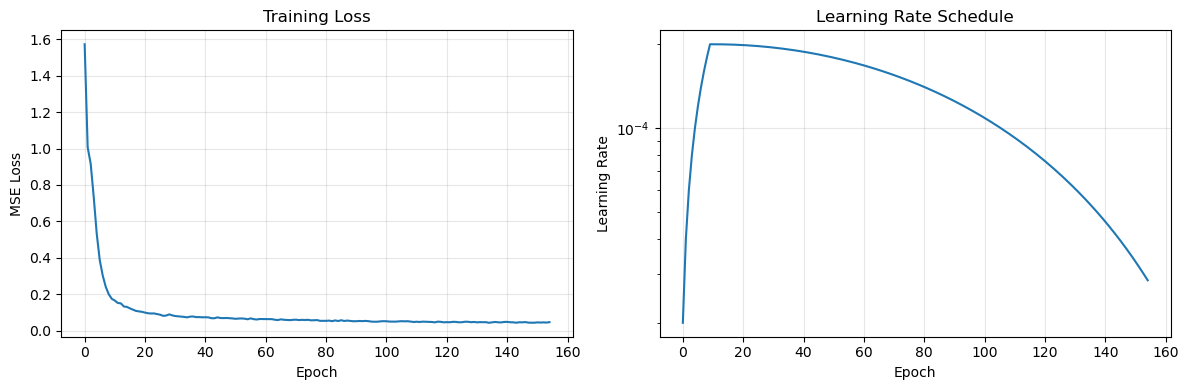


📊 Final loss: 0.047289


In [18]:
ticker = 'GSPC'

print("=" * 80)
print(f"TRAINING DIFFUSION MODEL ON {ticker} (1/3)")
print("=" * 80)

# 1. Load and prepare data
data_scaled, scaler, feature_names = load_and_prepare_data(ticker, use_features=True)
sequences = create_sequences(data_scaled, CONFIG['seq_len'])
CONFIG['n_features'] = sequences.shape[2]

print(f"\n📊 Data prepared:")
print(f"   Sequences: {sequences.shape}")
print(f"   Features: {CONFIG['n_features']}")

# 2. Initialize Diffusion Model
diffusion = DiffusionModel(CONFIG)
print(f"\n🏗️ Model architecture:")
diffusion.model.summary()

# 3. Train with OPTIMIZED settings
print(f"\n🚀 Starting OPTIMIZED training...")
print(f"   Epochs: {CONFIG['epochs']}")
print(f"   Batch size: {CONFIG['batch_size']}")
print(f"   Learning rate: {CONFIG['learning_rate']} (with warmup and cosine schedule)")
print(f"   Model capacity: {CONFIG['hidden_dim']} hidden, {CONFIG['num_layers']} layers, {CONFIG['num_heads']} heads")
start_time = time.time()
history = diffusion.train(sequences, epochs=CONFIG['epochs'], batch_size=CONFIG['batch_size'])
training_time = time.time() - start_time

print(f"\n✅ Training completed in {training_time/60:.2f} minutes")

# Plot training loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['lr'])
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'diffusion_training_{ticker}.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Final loss: {history['loss'][-1]:.6f}")

### Generate & Evaluate Synthetic Data

In [24]:
# RELOAD diffusion model with fixed generation
print("🔄 Reloading diffusion model with fixed generation...")

# Recreate model with same config (will use fixed denoise_step)
diffusion_config = CONFIG.copy()
diffusion_config['n_features'] = data_scaled.shape[1]

diffusion = DiffusionModel(config=diffusion_config)

# Load trained weights
diffusion.load_model(os.path.join(MODELS_DIR, ticker))

print("\n🔍 Testing fixed generation...")

# Generate small batch to test
test_samples = diffusion.generate_samples(5)
print(f"\nGenerated samples shape: {test_samples.shape}")
print(f"Generated samples range: [{np.nanmin(test_samples):.4f}, {np.nanmax(test_samples):.4f}]")
print(f"Generated samples mean: {np.nanmean(test_samples):.4f}")
print(f"Generated samples std: {np.nanstd(test_samples):.4f}")
print(f"NaN count: {np.isnan(test_samples).sum()}")

if not np.isnan(test_samples).any():
    print("\n✅ Generation working! No NaN values.")
else:
    print("\n❌ Still generating NaN values. Need to debug further.")

🔄 Reloading diffusion model with fixed generation...
✅ Model loaded from ../../models/diffusion\GSPC

🔍 Testing fixed generation...
✅ Model loaded from ../../models/diffusion\GSPC

🔍 Testing fixed generation...


Generating samples:   4%|▍         | 4/100 [00:01<00:42,  2.28it/s]

Generating samples:   5%|▌         | 5/100 [00:02<00:40,  2.32it/s]

Generating samples: 100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Generated samples shape: (5, 48, 108)
Generated samples range: [0.0005, 0.9948]
Generated samples mean: 0.4951
Generated samples std: 0.2141
NaN count: 0

✅ Generation working! No NaN values.


In [25]:
# 4. Generate synthetic data in batches (to avoid OOM)
print("\n🔮 Generating synthetic data...")
n_synthetic_samples = len(sequences)
batch_size_gen = 256  # Smaller batch size for generation

synthetic_batches = []
for i in range(0, n_synthetic_samples, batch_size_gen):
    batch_samples = min(batch_size_gen, n_synthetic_samples - i)
    print(f"   Generating batch {i//batch_size_gen + 1}/{(n_synthetic_samples-1)//batch_size_gen + 1} ({batch_samples} samples)...")
    batch_data = diffusion.generate_samples(batch_samples)
    synthetic_batches.append(batch_data)
    
synthetic_data = np.concatenate(synthetic_batches, axis=0)
print(f"✅ Generated {len(synthetic_data)} synthetic sequences")

# 5. Evaluate
print(f"\n📊 Evaluating synthetic data quality...")
evaluation_results = evaluate_synthetic_data(sequences, synthetic_data, feature_names)

# 6. Visualize
print(f"\n📈 Creating visualizations...")
save_path = os.path.join(FIGURES_DIR, f'08_diffusion_comparison_{ticker}.png')
visualize_synthetic_data(sequences, synthetic_data, feature_names, ticker, save_path)

# 7. Save models and data
print(f"\n💾 Saving models and synthetic data...")
model_save_dir = os.path.join(MODELS_DIR, ticker)
diffusion.save_model(model_save_dir)

synthetic_df = pd.DataFrame(
    synthetic_data.reshape(-1, len(feature_names)),
    columns=feature_names
)
synthetic_save_path = os.path.join(SYNTHETIC_DATA_DIR, f"{ticker}_synthetic.csv")
synthetic_df.to_csv(synthetic_save_path, index=False)
print(f"💾 Synthetic data saved to {synthetic_save_path}")

eval_save_path = os.path.join(RESULTS_DIR, f'diffusion_evaluation_{ticker}.csv')
evaluation_results['statistics'].to_csv(eval_save_path, index=False)
print(f"💾 Evaluation results saved to {eval_save_path}")

# Summary
avg_ks = np.mean(evaluation_results['ks_stats'])
mean_diff = evaluation_results['statistics']['Mean_Diff'].mean()

print("\n" + "=" * 80)
print(f"✅ {ticker} COMPLETE")
print("=" * 80)
print(f"Avg KS Statistic: {avg_ks:.4f} (lower is better)")
print(f"Avg Mean Difference: {mean_diff:.4f} (lower is better)")
print("=" * 80)


🔮 Generating synthetic data...
   Generating batch 1/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:55<00:00,  1.81it/s]



   Generating batch 2/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.16it/s]



   Generating batch 3/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.16it/s]



   Generating batch 4/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.16it/s]



   Generating batch 5/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.16it/s]



   Generating batch 6/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.16it/s]



   Generating batch 7/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.16it/s]



   Generating batch 8/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.16it/s]



   Generating batch 9/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.16it/s]



   Generating batch 10/10 (163 samples)...


Generating samples: 100%|██████████| 100/100 [01:01<00:00,  1.62it/s]



✅ Generated 2467 synthetic sequences

📊 Evaluating synthetic data quality...

📈 Creating visualizations...

📈 Creating visualizations...
📊 Visualization saved to ../../outputs/figures\08_diffusion_comparison_GSPC.png

💾 Saving models and synthetic data...
📊 Visualization saved to ../../outputs/figures\08_diffusion_comparison_GSPC.png

💾 Saving models and synthetic data...
💾 Model saved to ../../models/diffusion\GSPC
💾 Model saved to ../../models/diffusion\GSPC
💾 Synthetic data saved to ../../data/synthetic/diffusion\GSPC_synthetic.csv
💾 Evaluation results saved to ../../outputs/results\diffusion_evaluation_GSPC.csv

✅ GSPC COMPLETE
Avg KS Statistic: 0.3886 (lower is better)
Avg Mean Difference: 0.1231 (lower is better)
💾 Synthetic data saved to ../../data/synthetic/diffusion\GSPC_synthetic.csv
💾 Evaluation results saved to ../../outputs/results\diffusion_evaluation_GSPC.csv

✅ GSPC COMPLETE
Avg KS Statistic: 0.3886 (lower is better)
Avg Mean Difference: 0.1231 (lower is better)


## 9. Training: Additional Assets

Training diffusion model on diverse asset types for generalization testing

### 9.2 Apple (AAPL) - Individual Stock

In [26]:
ticker = 'AAPL'

print("\n" + "=" * 80)
print(f"TRAINING DIFFUSION MODEL ON {ticker} (3/3)")
print("=" * 80)

# 1. Load and prepare data
data_scaled, scaler, feature_names = load_and_prepare_data(ticker, use_features=True)
sequences = create_sequences(data_scaled, CONFIG['seq_len'])

print(f"\n📊 Data prepared:")
print(f"   Sequences: {sequences.shape}")
print(f"   Features: {len(feature_names)}")

# 2. Initialize Diffusion Model
diffusion_config = CONFIG.copy()
diffusion_config['n_features'] = sequences.shape[2]
diffusion = DiffusionModel(diffusion_config)

# 3. Train
print(f"\n🚀 Starting training...")
start_time = time.time()
history = diffusion.train(sequences, epochs=CONFIG['epochs'], batch_size=CONFIG['batch_size'])
training_time = time.time() - start_time

print(f"\n✅ Training completed in {training_time/60:.2f} minutes")

# 4. Generate synthetic data
print(f"\n🔮 Generating synthetic data...")
n_synthetic_samples = len(sequences)
batch_size_gen = 256

synthetic_batches = []
for i in range(0, n_synthetic_samples, batch_size_gen):
    batch_samples = min(batch_size_gen, n_synthetic_samples - i)
    print(f"   Batch {i//batch_size_gen + 1}/{(n_synthetic_samples-1)//batch_size_gen + 1} ({batch_samples} samples)...")
    batch_data = diffusion.generate_samples(batch_samples)
    synthetic_batches.append(batch_data)

synthetic_data = np.concatenate(synthetic_batches, axis=0)
print(f"✅ Generated {len(synthetic_data)} synthetic sequences")

# 5. Evaluate
print(f"\n📊 Evaluating synthetic data quality...")
evaluation_results = evaluate_synthetic_data(sequences, synthetic_data, feature_names)

# 6. Visualize
print(f"\n📈 Creating visualizations...")
save_path = os.path.join(FIGURES_DIR, f'08_diffusion_comparison_{ticker}.png')
visualize_synthetic_data(sequences, synthetic_data, feature_names, ticker, save_path)

# 7. Save
print(f"\n💾 Saving results...")
model_save_dir = os.path.join(MODELS_DIR, ticker)
diffusion.save_model(model_save_dir)

synthetic_df = pd.DataFrame(
    synthetic_data.reshape(-1, len(feature_names)),
    columns=feature_names
)
synthetic_save_path = os.path.join(SYNTHETIC_DATA_DIR, f"{ticker}_synthetic.csv")
synthetic_df.to_csv(synthetic_save_path, index=False)

eval_save_path = os.path.join(RESULTS_DIR, f'diffusion_evaluation_{ticker}.csv')
evaluation_results['statistics'].to_csv(eval_save_path, index=False)

# Summary
avg_ks = np.mean(evaluation_results['ks_stats'])
mean_diff = evaluation_results['statistics']['Mean_Diff'].mean()

print("\n" + "=" * 80)
print(f"✅ {ticker} COMPLETE")
print("=" * 80)
print(f"Avg KS Statistic: {avg_ks:.4f} (lower is better)")
print(f"Avg Mean Difference: {mean_diff:.4f} (lower is better)")
print(f"Training Time: {training_time/60:.2f} minutes")
print(f"Final Loss: {history['loss'][-1]:.6f}")
print("=" * 80)


TRAINING DIFFUSION MODEL ON AAPL (3/3)
✅ Loaded AAPL: (2514, 108)
   Features (108): Open, High, Low, Close, Volume...

📊 Data prepared:
   Sequences: (2467, 48, 108)
   Features: 108

🚀 Starting training...

🚀 Starting training...


Epoch 1/200: 100%|██████████| 39/39 [00:14<00:00,  2.62it/s, loss=1.2010, lr=0.000020]



Epoch 1/200 - Loss: 1.632657 - LR: 0.000020


Epoch 2/200: 100%|██████████| 39/39 [00:09<00:00,  4.24it/s, loss=0.9716, lr=0.000040]


Epoch 2/200 - Loss: 1.007940 - LR: 0.000040


Epoch 3/200: 100%|██████████| 39/39 [00:09<00:00,  4.25it/s, loss=0.8607, lr=0.000060]


Epoch 3/200 - Loss: 0.915932 - LR: 0.000060


Epoch 4/200: 100%|██████████| 39/39 [00:09<00:00,  3.99it/s, loss=0.6468, lr=0.000080]


Epoch 4/200 - Loss: 0.744391 - LR: 0.000080


Epoch 5/200: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.4597, lr=0.000100]


Epoch 5/200 - Loss: 0.547387 - LR: 0.000100


Epoch 6/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.3623, lr=0.000120]


Epoch 6/200 - Loss: 0.411237 - LR: 0.000120


Epoch 7/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.2642, lr=0.000140]


Epoch 7/200 - Loss: 0.314578 - LR: 0.000140


Epoch 8/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.2055, lr=0.000160]


Epoch 8/200 - Loss: 0.246427 - LR: 0.000160


Epoch 9/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.1654, lr=0.000180]


Epoch 9/200 - Loss: 0.212234 - LR: 0.000180


Epoch 10/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.1859, lr=0.000200]


Epoch 10/200 - Loss: 0.187536 - LR: 0.000200


Epoch 11/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.1563, lr=0.000200]


Epoch 11/200 - Loss: 0.175190 - LR: 0.000200


Epoch 12/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.2243, lr=0.000200]


Epoch 12/200 - Loss: 0.165149 - LR: 0.000200


Epoch 13/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.1577, lr=0.000200]


Epoch 13/200 - Loss: 0.155363 - LR: 0.000200


Epoch 14/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.1054, lr=0.000200]


Epoch 14/200 - Loss: 0.145114 - LR: 0.000200


Epoch 15/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.1274, lr=0.000200]


Epoch 15/200 - Loss: 0.135800 - LR: 0.000200


Epoch 16/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.1094, lr=0.000200]


Epoch 16/200 - Loss: 0.129206 - LR: 0.000200


Epoch 17/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.1318, lr=0.000200]


Epoch 17/200 - Loss: 0.122475 - LR: 0.000200


Epoch 18/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0909, lr=0.000199]


Epoch 18/200 - Loss: 0.116224 - LR: 0.000199


Epoch 19/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0924, lr=0.000199]


Epoch 19/200 - Loss: 0.113303 - LR: 0.000199


Epoch 20/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.1214, lr=0.000199]


Epoch 20/200 - Loss: 0.108653 - LR: 0.000199


Epoch 21/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0995, lr=0.000199]


Epoch 21/200 - Loss: 0.105756 - LR: 0.000199


Epoch 22/200: 100%|██████████| 39/39 [00:10<00:00,  3.83it/s, loss=0.1284, lr=0.000198]


Epoch 22/200 - Loss: 0.110537 - LR: 0.000198


Epoch 23/200: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.1028, lr=0.000198]


Epoch 23/200 - Loss: 0.104248 - LR: 0.000198


Epoch 24/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0759, lr=0.000198]


Epoch 24/200 - Loss: 0.098627 - LR: 0.000198


Epoch 25/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0790, lr=0.000197]


Epoch 25/200 - Loss: 0.092466 - LR: 0.000197


Epoch 26/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0827, lr=0.000197]


Epoch 26/200 - Loss: 0.094161 - LR: 0.000197


Epoch 27/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0958, lr=0.000197]


Epoch 27/200 - Loss: 0.095271 - LR: 0.000197


Epoch 28/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.1273, lr=0.000196]


Epoch 28/200 - Loss: 0.093227 - LR: 0.000196


Epoch 29/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0869, lr=0.000196]


Epoch 29/200 - Loss: 0.087900 - LR: 0.000196


Epoch 30/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.1037, lr=0.000195]


Epoch 30/200 - Loss: 0.091039 - LR: 0.000195


Epoch 31/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0712, lr=0.000195]


Epoch 31/200 - Loss: 0.091227 - LR: 0.000195


Epoch 32/200: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.0704, lr=0.000194]



Epoch 32/200 - Loss: 0.088554 - LR: 0.000194


Epoch 33/200: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.0799, lr=0.000193]



Epoch 33/200 - Loss: 0.086083 - LR: 0.000193


Epoch 34/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.1007, lr=0.000193]



Epoch 34/200 - Loss: 0.085592 - LR: 0.000193


Epoch 35/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.1124, lr=0.000192]


Epoch 35/200 - Loss: 0.080898 - LR: 0.000192


Epoch 36/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0838, lr=0.000192]


Epoch 36/200 - Loss: 0.083435 - LR: 0.000192


Epoch 37/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0909, lr=0.000191]


Epoch 37/200 - Loss: 0.077185 - LR: 0.000191


Epoch 38/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0899, lr=0.000190]


Epoch 38/200 - Loss: 0.078510 - LR: 0.000190


Epoch 39/200: 100%|██████████| 39/39 [00:10<00:00,  3.83it/s, loss=0.1091, lr=0.000190]


Epoch 39/200 - Loss: 0.080511 - LR: 0.000190


Epoch 40/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0750, lr=0.000189]



Epoch 40/200 - Loss: 0.078142 - LR: 0.000189


Epoch 41/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0732, lr=0.000188]


Epoch 41/200 - Loss: 0.074920 - LR: 0.000188


Epoch 42/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0919, lr=0.000187]


Epoch 42/200 - Loss: 0.076421 - LR: 0.000187


Epoch 43/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0616, lr=0.000186]


Epoch 43/200 - Loss: 0.078840 - LR: 0.000186


Epoch 44/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0651, lr=0.000186]


Epoch 44/200 - Loss: 0.076252 - LR: 0.000186


Epoch 45/200: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.0571, lr=0.000185]


Epoch 45/200 - Loss: 0.074999 - LR: 0.000185


Epoch 46/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0977, lr=0.000184]


Epoch 46/200 - Loss: 0.075321 - LR: 0.000184


Epoch 47/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.1043, lr=0.000183]



Epoch 47/200 - Loss: 0.072681 - LR: 0.000183


Epoch 48/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0732, lr=0.000182]


Epoch 48/200 - Loss: 0.072877 - LR: 0.000182


Epoch 49/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0551, lr=0.000181]



Epoch 49/200 - Loss: 0.076077 - LR: 0.000181


Epoch 50/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0832, lr=0.000180]


Epoch 50/200 - Loss: 0.075163 - LR: 0.000180


Epoch 51/200: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.0553, lr=0.000179]


Epoch 51/200 - Loss: 0.067834 - LR: 0.000179


Epoch 52/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0752, lr=0.000178]


Epoch 52/200 - Loss: 0.070509 - LR: 0.000178


Epoch 53/200: 100%|██████████| 39/39 [00:10<00:00,  3.83it/s, loss=0.0592, lr=0.000177]



Epoch 53/200 - Loss: 0.071844 - LR: 0.000177


Epoch 54/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0714, lr=0.000176]


Epoch 54/200 - Loss: 0.070236 - LR: 0.000176


Epoch 55/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0778, lr=0.000175]


Epoch 55/200 - Loss: 0.070237 - LR: 0.000175


Epoch 56/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0638, lr=0.000174]


Epoch 56/200 - Loss: 0.069731 - LR: 0.000174


Epoch 57/200: 100%|██████████| 39/39 [00:10<00:00,  3.82it/s, loss=0.0653, lr=0.000173]


Epoch 57/200 - Loss: 0.069681 - LR: 0.000173


Epoch 58/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0585, lr=0.000171]


Epoch 58/200 - Loss: 0.068568 - LR: 0.000171


Epoch 59/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0616, lr=0.000170]


Epoch 59/200 - Loss: 0.067759 - LR: 0.000170


Epoch 60/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0569, lr=0.000169]


Epoch 60/200 - Loss: 0.069711 - LR: 0.000169


Epoch 61/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0660, lr=0.000168]


Epoch 61/200 - Loss: 0.067485 - LR: 0.000168


Epoch 62/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0547, lr=0.000167]


Epoch 62/200 - Loss: 0.064445 - LR: 0.000167


Epoch 63/200: 100%|██████████| 39/39 [00:10<00:00,  3.83it/s, loss=0.0989, lr=0.000165]


Epoch 63/200 - Loss: 0.069170 - LR: 0.000165


Epoch 64/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0717, lr=0.000164]


Epoch 64/200 - Loss: 0.065195 - LR: 0.000164


Epoch 65/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0665, lr=0.000163]


Epoch 65/200 - Loss: 0.065983 - LR: 0.000163


Epoch 66/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0480, lr=0.000162]


Epoch 66/200 - Loss: 0.064306 - LR: 0.000162


Epoch 67/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0576, lr=0.000160]


Epoch 67/200 - Loss: 0.060862 - LR: 0.000160


Epoch 68/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0778, lr=0.000159]


Epoch 68/200 - Loss: 0.066862 - LR: 0.000159


Epoch 69/200: 100%|██████████| 39/39 [00:10<00:00,  3.81it/s, loss=0.0603, lr=0.000158]



Epoch 69/200 - Loss: 0.064956 - LR: 0.000158


Epoch 70/200: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.0751, lr=0.000156]



Epoch 70/200 - Loss: 0.066467 - LR: 0.000156


Epoch 71/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0901, lr=0.000155]



Epoch 71/200 - Loss: 0.066262 - LR: 0.000155


Epoch 72/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0389, lr=0.000154]


Epoch 72/200 - Loss: 0.060860 - LR: 0.000154


Epoch 73/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0478, lr=0.000152]



Epoch 73/200 - Loss: 0.063822 - LR: 0.000152


Epoch 74/200: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.0700, lr=0.000151]


Epoch 74/200 - Loss: 0.059060 - LR: 0.000151


Epoch 75/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0977, lr=0.000149]


Epoch 75/200 - Loss: 0.064913 - LR: 0.000149


Epoch 76/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0705, lr=0.000148]


Epoch 76/200 - Loss: 0.062497 - LR: 0.000148


Epoch 77/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0749, lr=0.000146]


Epoch 77/200 - Loss: 0.063915 - LR: 0.000146


Epoch 78/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0403, lr=0.000145]


Epoch 78/200 - Loss: 0.061134 - LR: 0.000145


Epoch 79/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0545, lr=0.000143]


Epoch 79/200 - Loss: 0.061066 - LR: 0.000143


Epoch 80/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0704, lr=0.000142]



Epoch 80/200 - Loss: 0.062410 - LR: 0.000142


Epoch 81/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0740, lr=0.000140]


Epoch 81/200 - Loss: 0.056941 - LR: 0.000140


Epoch 82/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0457, lr=0.000139]


Epoch 82/200 - Loss: 0.058836 - LR: 0.000139


Epoch 83/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0801, lr=0.000137]


Epoch 83/200 - Loss: 0.062025 - LR: 0.000137


Epoch 84/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0742, lr=0.000136]


Epoch 84/200 - Loss: 0.058797 - LR: 0.000136


Epoch 85/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0525, lr=0.000134]


Epoch 85/200 - Loss: 0.056085 - LR: 0.000134


Epoch 86/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0547, lr=0.000133]


Epoch 86/200 - Loss: 0.060615 - LR: 0.000133


Epoch 87/200: 100%|██████████| 39/39 [00:10<00:00,  3.83it/s, loss=0.0604, lr=0.000131]


Epoch 87/200 - Loss: 0.061334 - LR: 0.000131


Epoch 88/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0515, lr=0.000130]


Epoch 88/200 - Loss: 0.061044 - LR: 0.000130


Epoch 89/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0543, lr=0.000128]


Epoch 89/200 - Loss: 0.059056 - LR: 0.000128


Epoch 90/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0693, lr=0.000127]



Epoch 90/200 - Loss: 0.057128 - LR: 0.000127


Epoch 91/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0516, lr=0.000125]


Epoch 91/200 - Loss: 0.056224 - LR: 0.000125


Epoch 92/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0430, lr=0.000123]


Epoch 92/200 - Loss: 0.056155 - LR: 0.000123


Epoch 93/200: 100%|██████████| 39/39 [00:10<00:00,  3.83it/s, loss=0.0659, lr=0.000122]


Epoch 93/200 - Loss: 0.060245 - LR: 0.000122


Epoch 94/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0435, lr=0.000120]


Epoch 94/200 - Loss: 0.060299 - LR: 0.000120


Epoch 95/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0539, lr=0.000118]


Epoch 95/200 - Loss: 0.057234 - LR: 0.000118


Epoch 96/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0505, lr=0.000117]


Epoch 96/200 - Loss: 0.055995 - LR: 0.000117


Epoch 97/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0458, lr=0.000115]


Epoch 97/200 - Loss: 0.056135 - LR: 0.000115


Epoch 98/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0565, lr=0.000114]



Epoch 98/200 - Loss: 0.059505 - LR: 0.000114


Epoch 99/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0375, lr=0.000112]


Epoch 99/200 - Loss: 0.056142 - LR: 0.000112


Epoch 100/200: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.0727, lr=0.000110]


Epoch 100/200 - Loss: 0.055940 - LR: 0.000110


Epoch 101/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0473, lr=0.000109]


Epoch 101/200 - Loss: 0.055711 - LR: 0.000109


Epoch 102/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0442, lr=0.000107]


Epoch 102/200 - Loss: 0.054937 - LR: 0.000107


Epoch 103/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0635, lr=0.000105]


Epoch 103/200 - Loss: 0.055355 - LR: 0.000105


Epoch 104/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0528, lr=0.000104]


Epoch 104/200 - Loss: 0.054685 - LR: 0.000104


Epoch 105/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0432, lr=0.000102]


Epoch 105/200 - Loss: 0.052599 - LR: 0.000102


Epoch 106/200: 100%|██████████| 39/39 [00:10<00:00,  3.83it/s, loss=0.0522, lr=0.000101]


Epoch 106/200 - Loss: 0.054526 - LR: 0.000101


Epoch 107/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0605, lr=0.000099]


Epoch 107/200 - Loss: 0.056635 - LR: 0.000099


Epoch 108/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0528, lr=0.000097]


Epoch 108/200 - Loss: 0.054564 - LR: 0.000097


Epoch 109/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0337, lr=0.000096]


Epoch 109/200 - Loss: 0.053573 - LR: 0.000096


Epoch 110/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0632, lr=0.000094]


Epoch 110/200 - Loss: 0.054165 - LR: 0.000094


Epoch 111/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0462, lr=0.000092]


Epoch 111/200 - Loss: 0.054532 - LR: 0.000092


Epoch 112/200: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.0624, lr=0.000091]


Epoch 112/200 - Loss: 0.051795 - LR: 0.000091


Epoch 113/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0781, lr=0.000089]


Epoch 113/200 - Loss: 0.057596 - LR: 0.000089


Epoch 114/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0862, lr=0.000087]


Epoch 114/200 - Loss: 0.052632 - LR: 0.000087


Epoch 115/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0470, lr=0.000086]


Epoch 115/200 - Loss: 0.053911 - LR: 0.000086


Epoch 116/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0574, lr=0.000084]


Epoch 116/200 - Loss: 0.054527 - LR: 0.000084


Epoch 117/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0403, lr=0.000083]


Epoch 117/200 - Loss: 0.055000 - LR: 0.000083


Epoch 118/200: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.0300, lr=0.000081]


Epoch 118/200 - Loss: 0.052622 - LR: 0.000081


Epoch 119/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0485, lr=0.000079]


Epoch 119/200 - Loss: 0.053727 - LR: 0.000079


Epoch 120/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0469, lr=0.000078]


Epoch 120/200 - Loss: 0.053106 - LR: 0.000078


Epoch 121/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0554, lr=0.000076]


Epoch 121/200 - Loss: 0.051332 - LR: 0.000076


Epoch 122/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0487, lr=0.000074]


Epoch 122/200 - Loss: 0.054080 - LR: 0.000074


Epoch 123/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0478, lr=0.000073]


Epoch 123/200 - Loss: 0.050055 - LR: 0.000073


Epoch 124/200: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.0701, lr=0.000071]


Epoch 124/200 - Loss: 0.051128 - LR: 0.000071


Epoch 125/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0669, lr=0.000070]


Epoch 125/200 - Loss: 0.051618 - LR: 0.000070


Epoch 126/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0419, lr=0.000068]


Epoch 126/200 - Loss: 0.051330 - LR: 0.000068


Epoch 127/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0649, lr=0.000067]


Epoch 127/200 - Loss: 0.052700 - LR: 0.000067


Epoch 128/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0910, lr=0.000065]


Epoch 128/200 - Loss: 0.053790 - LR: 0.000065


Epoch 129/200: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.0368, lr=0.000064]



Epoch 129/200 - Loss: 0.051652 - LR: 0.000064


Epoch 130/200: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.0454, lr=0.000062]


Epoch 130/200 - Loss: 0.054062 - LR: 0.000062


Epoch 131/200: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.0859, lr=0.000061]


Epoch 131/200 - Loss: 0.050335 - LR: 0.000061


Epoch 132/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0328, lr=0.000059]


Epoch 132/200 - Loss: 0.052590 - LR: 0.000059


Epoch 133/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0492, lr=0.000058]


Epoch 133/200 - Loss: 0.050157 - LR: 0.000058


Epoch 134/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0578, lr=0.000056]


Epoch 134/200 - Loss: 0.054622 - LR: 0.000056


Epoch 135/200: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.0496, lr=0.000055]


Epoch 135/200 - Loss: 0.044912 - LR: 0.000055


Epoch 136/200: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.0358, lr=0.000053]


Epoch 136/200 - Loss: 0.050036 - LR: 0.000053


Epoch 137/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0317, lr=0.000052]


Epoch 137/200 - Loss: 0.050332 - LR: 0.000052


Epoch 138/200: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.0487, lr=0.000050]


Epoch 138/200 - Loss: 0.051020 - LR: 0.000050


Epoch 139/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0374, lr=0.000049]


Epoch 139/200 - Loss: 0.053382 - LR: 0.000049


Epoch 140/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0472, lr=0.000047]


Epoch 140/200 - Loss: 0.051269 - LR: 0.000047


Epoch 141/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0541, lr=0.000046]



Epoch 141/200 - Loss: 0.051567 - LR: 0.000046


Epoch 142/200: 100%|██████████| 39/39 [00:10<00:00,  3.82it/s, loss=0.0360, lr=0.000045]


Epoch 142/200 - Loss: 0.051823 - LR: 0.000045


Epoch 143/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0462, lr=0.000043]


Epoch 143/200 - Loss: 0.050463 - LR: 0.000043


Epoch 144/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0581, lr=0.000042]


Epoch 144/200 - Loss: 0.051143 - LR: 0.000042


Epoch 145/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0432, lr=0.000041]


Epoch 145/200 - Loss: 0.051942 - LR: 0.000041


Epoch 146/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0583, lr=0.000039]


Epoch 146/200 - Loss: 0.047168 - LR: 0.000039


Epoch 147/200: 100%|██████████| 39/39 [00:10<00:00,  3.83it/s, loss=0.0349, lr=0.000038]


Epoch 147/200 - Loss: 0.050589 - LR: 0.000038


Epoch 148/200: 100%|██████████| 39/39 [00:10<00:00,  3.81it/s, loss=0.0443, lr=0.000037]


Epoch 148/200 - Loss: 0.048657 - LR: 0.000037


Epoch 149/200: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.0483, lr=0.000036]


Epoch 149/200 - Loss: 0.049479 - LR: 0.000036


Epoch 150/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0526, lr=0.000034]


Epoch 150/200 - Loss: 0.048945 - LR: 0.000034


Epoch 151/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0633, lr=0.000033]


Epoch 151/200 - Loss: 0.046924 - LR: 0.000033


Epoch 152/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0380, lr=0.000032]


Epoch 152/200 - Loss: 0.049638 - LR: 0.000032


Epoch 153/200: 100%|██████████| 39/39 [00:10<00:00,  3.82it/s, loss=0.0507, lr=0.000031]



Epoch 153/200 - Loss: 0.046192 - LR: 0.000031


Epoch 154/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0805, lr=0.000030]


Epoch 154/200 - Loss: 0.052519 - LR: 0.000030


Epoch 155/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0477, lr=0.000028]



Epoch 155/200 - Loss: 0.048313 - LR: 0.000028
✋ Early stopping at epoch 155 (best loss: 0.044912)

✅ Training completed in 26.23 minutes

🔮 Generating synthetic data...
   Batch 1/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [01:06<00:00,  1.49it/s]



   Batch 2/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s]



   Batch 3/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:30<00:00,  3.24it/s]



   Batch 4/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:30<00:00,  3.24it/s]



   Batch 5/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s]



   Batch 6/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:30<00:00,  3.24it/s]



   Batch 7/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:30<00:00,  3.24it/s]



   Batch 8/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s]



   Batch 9/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s]



   Batch 10/10 (163 samples)...


Generating samples: 100%|██████████| 100/100 [01:01<00:00,  1.62it/s]



✅ Generated 2467 synthetic sequences

📊 Evaluating synthetic data quality...

📈 Creating visualizations...

📈 Creating visualizations...
📊 Visualization saved to ../../outputs/figures\08_diffusion_comparison_AAPL.png

💾 Saving results...
📊 Visualization saved to ../../outputs/figures\08_diffusion_comparison_AAPL.png

💾 Saving results...
💾 Model saved to ../../models/diffusion\AAPL
💾 Model saved to ../../models/diffusion\AAPL

✅ AAPL COMPLETE
Avg KS Statistic: 0.3879 (lower is better)
Avg Mean Difference: 0.1318 (lower is better)
Training Time: 26.23 minutes
Final Loss: 0.048313

✅ AAPL COMPLETE
Avg KS Statistic: 0.3879 (lower is better)
Avg Mean Difference: 0.1318 (lower is better)
Training Time: 26.23 minutes
Final Loss: 0.048313


### 9.1 Bitcoin (BTC-USD) - Cryptocurrency

In [28]:
ticker = 'BTC_USD'  # Fixed: Use underscore instead of hyphen

print("\n" + "=" * 80)
print(f"TRAINING DIFFUSION MODEL ON {ticker} (2/3)")
print("=" * 80)

# 1. Load and prepare data
data_scaled, scaler, feature_names = load_and_prepare_data(ticker, use_features=True)
sequences = create_sequences(data_scaled, CONFIG['seq_len'])

print(f"\n📊 Data prepared:")
print(f"   Sequences: {sequences.shape}")
print(f"   Features: {len(feature_names)}")

# 2. Initialize Diffusion Model
diffusion_config = CONFIG.copy()
diffusion_config['n_features'] = sequences.shape[2]
diffusion = DiffusionModel(diffusion_config)

# 3. Train
print(f"\n🚀 Starting training...")
start_time = time.time()
history = diffusion.train(sequences, epochs=CONFIG['epochs'], batch_size=CONFIG['batch_size'])
training_time = time.time() - start_time

print(f"\n✅ Training completed in {training_time/60:.2f} minutes")

# 4. Generate synthetic data
print(f"\n🔮 Generating synthetic data...")
n_synthetic_samples = len(sequences)
batch_size_gen = 256

synthetic_batches = []
for i in range(0, n_synthetic_samples, batch_size_gen):
    batch_samples = min(batch_size_gen, n_synthetic_samples - i)
    print(f"   Batch {i//batch_size_gen + 1}/{(n_synthetic_samples-1)//batch_size_gen + 1} ({batch_samples} samples)...")
    batch_data = diffusion.generate_samples(batch_samples)
    synthetic_batches.append(batch_data)

synthetic_data = np.concatenate(synthetic_batches, axis=0)
print(f"✅ Generated {len(synthetic_data)} synthetic sequences")

# 5. Evaluate
print(f"\n📊 Evaluating synthetic data quality...")
evaluation_results = evaluate_synthetic_data(sequences, synthetic_data, feature_names)

# 6. Visualize
print(f"\n📈 Creating visualizations...")
save_path = os.path.join(FIGURES_DIR, f'08_diffusion_comparison_{ticker}.png')
visualize_synthetic_data(sequences, synthetic_data, feature_names, ticker, save_path)

# 7. Save
print(f"\n💾 Saving results...")
model_save_dir = os.path.join(MODELS_DIR, ticker)
diffusion.save_model(model_save_dir)

synthetic_df = pd.DataFrame(
    synthetic_data.reshape(-1, len(feature_names)),
    columns=feature_names
)
synthetic_save_path = os.path.join(SYNTHETIC_DATA_DIR, f"{ticker}_synthetic.csv")
synthetic_df.to_csv(synthetic_save_path, index=False)

eval_save_path = os.path.join(RESULTS_DIR, f'diffusion_evaluation_{ticker}.csv')
evaluation_results['statistics'].to_csv(eval_save_path, index=False)

# Summary
avg_ks = np.mean(evaluation_results['ks_stats'])
mean_diff = evaluation_results['statistics']['Mean_Diff'].mean()

print("\n" + "=" * 80)
print(f"✅ {ticker} COMPLETE")
print("=" * 80)
print(f"Avg KS Statistic: {avg_ks:.4f} (lower is better)")
print(f"Avg Mean Difference: {mean_diff:.4f} (lower is better)")
print(f"Training Time: {training_time/60:.2f} minutes")
print(f"Final Loss: {history['loss'][-1]:.6f}")
print("=" * 80)


TRAINING DIFFUSION MODEL ON BTC_USD (2/3)
✅ Loaded BTC_USD: (3651, 108)
   Features (108): Open, High, Low, Close, Volume...

📊 Data prepared:
   Sequences: (3604, 48, 108)
   Features: 108

🚀 Starting training...

🚀 Starting training...


Epoch 1/200: 100%|██████████| 57/57 [00:18<00:00,  3.08it/s, loss=1.0354, lr=0.000020]



Epoch 1/200 - Loss: 1.483061 - LR: 0.000020


Epoch 2/200: 100%|██████████| 57/57 [00:13<00:00,  4.24it/s, loss=0.9343, lr=0.000040]


Epoch 2/200 - Loss: 0.971818 - LR: 0.000040


Epoch 3/200: 100%|██████████| 57/57 [00:13<00:00,  4.08it/s, loss=0.6806, lr=0.000060]


Epoch 3/200 - Loss: 0.821426 - LR: 0.000060


Epoch 4/200: 100%|██████████| 57/57 [00:14<00:00,  3.86it/s, loss=0.4749, lr=0.000080]


Epoch 4/200 - Loss: 0.574540 - LR: 0.000080


Epoch 5/200: 100%|██████████| 57/57 [00:14<00:00,  3.86it/s, loss=0.2963, lr=0.000100]


Epoch 5/200 - Loss: 0.398248 - LR: 0.000100


Epoch 6/200: 100%|██████████| 57/57 [00:15<00:00,  3.80it/s, loss=0.2408, lr=0.000120]


Epoch 6/200 - Loss: 0.292472 - LR: 0.000120


Epoch 7/200: 100%|██████████| 57/57 [00:14<00:00,  3.81it/s, loss=0.1847, lr=0.000140]


Epoch 7/200 - Loss: 0.225279 - LR: 0.000140


Epoch 8/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.1673, lr=0.000160]


Epoch 8/200 - Loss: 0.187101 - LR: 0.000160


Epoch 9/200: 100%|██████████| 57/57 [00:14<00:00,  3.86it/s, loss=0.1906, lr=0.000180]


Epoch 9/200 - Loss: 0.174482 - LR: 0.000180


Epoch 10/200: 100%|██████████| 57/57 [00:14<00:00,  3.82it/s, loss=0.1372, lr=0.000200]


Epoch 10/200 - Loss: 0.157142 - LR: 0.000200


Epoch 11/200: 100%|██████████| 57/57 [00:14<00:00,  3.86it/s, loss=0.1556, lr=0.000200]


Epoch 11/200 - Loss: 0.143339 - LR: 0.000200


Epoch 12/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.1928, lr=0.000200]


Epoch 12/200 - Loss: 0.133520 - LR: 0.000200


Epoch 13/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0936, lr=0.000200]


Epoch 13/200 - Loss: 0.125052 - LR: 0.000200


Epoch 14/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.1048, lr=0.000200]


Epoch 14/200 - Loss: 0.118226 - LR: 0.000200


Epoch 15/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0729, lr=0.000200]


Epoch 15/200 - Loss: 0.108892 - LR: 0.000200


Epoch 16/200: 100%|██████████| 57/57 [00:14<00:00,  3.87it/s, loss=0.1620, lr=0.000200]


Epoch 16/200 - Loss: 0.106631 - LR: 0.000200


Epoch 17/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0754, lr=0.000200]


Epoch 17/200 - Loss: 0.099755 - LR: 0.000200


Epoch 18/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0747, lr=0.000199]



Epoch 18/200 - Loss: 0.095791 - LR: 0.000199


Epoch 19/200: 100%|██████████| 57/57 [00:15<00:00,  3.80it/s, loss=0.1010, lr=0.000199]


Epoch 19/200 - Loss: 0.095197 - LR: 0.000199


Epoch 20/200: 100%|██████████| 57/57 [00:15<00:00,  3.79it/s, loss=0.1104, lr=0.000199]


Epoch 20/200 - Loss: 0.089908 - LR: 0.000199


Epoch 21/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0661, lr=0.000199]


Epoch 21/200 - Loss: 0.088055 - LR: 0.000199


Epoch 22/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0673, lr=0.000198]


Epoch 22/200 - Loss: 0.088322 - LR: 0.000198


Epoch 23/200: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, loss=0.0996, lr=0.000198]


Epoch 23/200 - Loss: 0.084713 - LR: 0.000198


Epoch 24/200: 100%|██████████| 57/57 [00:14<00:00,  3.87it/s, loss=0.0737, lr=0.000198]


Epoch 24/200 - Loss: 0.085864 - LR: 0.000198


Epoch 25/200: 100%|██████████| 57/57 [00:15<00:00,  3.77it/s, loss=0.0772, lr=0.000197]


Epoch 25/200 - Loss: 0.082321 - LR: 0.000197


Epoch 26/200: 100%|██████████| 57/57 [00:15<00:00,  3.77it/s, loss=0.0708, lr=0.000197]



Epoch 26/200 - Loss: 0.081936 - LR: 0.000197


Epoch 27/200: 100%|██████████| 57/57 [00:15<00:00,  3.78it/s, loss=0.0530, lr=0.000197]


Epoch 27/200 - Loss: 0.076945 - LR: 0.000197


Epoch 28/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.0709, lr=0.000196]


Epoch 28/200 - Loss: 0.077244 - LR: 0.000196


Epoch 29/200: 100%|██████████| 57/57 [00:14<00:00,  3.87it/s, loss=0.1094, lr=0.000196]


Epoch 29/200 - Loss: 0.075171 - LR: 0.000196


Epoch 30/200: 100%|██████████| 57/57 [00:15<00:00,  3.80it/s, loss=0.0898, lr=0.000195]



Epoch 30/200 - Loss: 0.075948 - LR: 0.000195


Epoch 31/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0605, lr=0.000195]


Epoch 31/200 - Loss: 0.076050 - LR: 0.000195


Epoch 32/200: 100%|██████████| 57/57 [00:14<00:00,  3.88it/s, loss=0.1318, lr=0.000194]


Epoch 32/200 - Loss: 0.076238 - LR: 0.000194


Epoch 33/200: 100%|██████████| 57/57 [00:14<00:00,  3.87it/s, loss=0.0773, lr=0.000193]


Epoch 33/200 - Loss: 0.074510 - LR: 0.000193


Epoch 34/200: 100%|██████████| 57/57 [00:14<00:00,  3.86it/s, loss=0.0470, lr=0.000193]


Epoch 34/200 - Loss: 0.069876 - LR: 0.000193


Epoch 35/200: 100%|██████████| 57/57 [00:14<00:00,  3.82it/s, loss=0.0666, lr=0.000192]


Epoch 35/200 - Loss: 0.073764 - LR: 0.000192


Epoch 36/200: 100%|██████████| 57/57 [00:14<00:00,  3.82it/s, loss=0.0685, lr=0.000192]


Epoch 36/200 - Loss: 0.070173 - LR: 0.000192


Epoch 37/200: 100%|██████████| 57/57 [00:14<00:00,  3.81it/s, loss=0.0625, lr=0.000191]


Epoch 37/200 - Loss: 0.067614 - LR: 0.000191


Epoch 38/200: 100%|██████████| 57/57 [00:14<00:00,  3.86it/s, loss=0.0856, lr=0.000190]


Epoch 38/200 - Loss: 0.069618 - LR: 0.000190


Epoch 39/200: 100%|██████████| 57/57 [00:14<00:00,  3.86it/s, loss=0.0391, lr=0.000190]


Epoch 39/200 - Loss: 0.067757 - LR: 0.000190


Epoch 40/200: 100%|██████████| 57/57 [00:14<00:00,  3.88it/s, loss=0.0487, lr=0.000189]


Epoch 40/200 - Loss: 0.066746 - LR: 0.000189


Epoch 41/200: 100%|██████████| 57/57 [00:14<00:00,  3.87it/s, loss=0.0691, lr=0.000188]


Epoch 41/200 - Loss: 0.064019 - LR: 0.000188


Epoch 42/200: 100%|██████████| 57/57 [00:14<00:00,  3.86it/s, loss=0.0534, lr=0.000187]


Epoch 42/200 - Loss: 0.065052 - LR: 0.000187


Epoch 43/200: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, loss=0.0500, lr=0.000186]


Epoch 43/200 - Loss: 0.063681 - LR: 0.000186


Epoch 44/200: 100%|██████████| 57/57 [00:14<00:00,  3.88it/s, loss=0.0901, lr=0.000186]


Epoch 44/200 - Loss: 0.065884 - LR: 0.000186


Epoch 45/200: 100%|██████████| 57/57 [00:14<00:00,  3.87it/s, loss=0.0568, lr=0.000185]


Epoch 45/200 - Loss: 0.066258 - LR: 0.000185


Epoch 46/200: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, loss=0.0622, lr=0.000184]


Epoch 46/200 - Loss: 0.065622 - LR: 0.000184


Epoch 47/200: 100%|██████████| 57/57 [00:14<00:00,  3.86it/s, loss=0.0801, lr=0.000183]


Epoch 47/200 - Loss: 0.061829 - LR: 0.000183


Epoch 48/200: 100%|██████████| 57/57 [00:14<00:00,  3.89it/s, loss=0.0498, lr=0.000182]


Epoch 48/200 - Loss: 0.062393 - LR: 0.000182


Epoch 49/200: 100%|██████████| 57/57 [00:14<00:00,  3.88it/s, loss=0.0525, lr=0.000181]


Epoch 49/200 - Loss: 0.061140 - LR: 0.000181


Epoch 50/200: 100%|██████████| 57/57 [00:14<00:00,  3.87it/s, loss=0.0832, lr=0.000180]


Epoch 50/200 - Loss: 0.061775 - LR: 0.000180


Epoch 51/200: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, loss=0.1082, lr=0.000179]


Epoch 51/200 - Loss: 0.059954 - LR: 0.000179


Epoch 52/200: 100%|██████████| 57/57 [00:14<00:00,  3.86it/s, loss=0.0456, lr=0.000178]


Epoch 52/200 - Loss: 0.061433 - LR: 0.000178


Epoch 53/200: 100%|██████████| 57/57 [00:14<00:00,  3.87it/s, loss=0.0715, lr=0.000177]


Epoch 53/200 - Loss: 0.060683 - LR: 0.000177


Epoch 54/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0423, lr=0.000176]


Epoch 54/200 - Loss: 0.058224 - LR: 0.000176


Epoch 55/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0717, lr=0.000175]


Epoch 55/200 - Loss: 0.058942 - LR: 0.000175


Epoch 56/200: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, loss=0.0624, lr=0.000174]


Epoch 56/200 - Loss: 0.058832 - LR: 0.000174


Epoch 57/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0446, lr=0.000173]


Epoch 57/200 - Loss: 0.058951 - LR: 0.000173


Epoch 58/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0413, lr=0.000171]


Epoch 58/200 - Loss: 0.057722 - LR: 0.000171


Epoch 59/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.0336, lr=0.000170]


Epoch 59/200 - Loss: 0.056527 - LR: 0.000170


Epoch 60/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0648, lr=0.000169]


Epoch 60/200 - Loss: 0.058038 - LR: 0.000169


Epoch 61/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0491, lr=0.000168]


Epoch 61/200 - Loss: 0.057818 - LR: 0.000168


Epoch 62/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0400, lr=0.000167]


Epoch 62/200 - Loss: 0.056601 - LR: 0.000167


Epoch 63/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.1007, lr=0.000165]


Epoch 63/200 - Loss: 0.056879 - LR: 0.000165


Epoch 64/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0538, lr=0.000164]


Epoch 64/200 - Loss: 0.057441 - LR: 0.000164


Epoch 65/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0373, lr=0.000163]


Epoch 65/200 - Loss: 0.053432 - LR: 0.000163


Epoch 66/200: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, loss=0.0412, lr=0.000162]


Epoch 66/200 - Loss: 0.052908 - LR: 0.000162


Epoch 67/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0500, lr=0.000160]


Epoch 67/200 - Loss: 0.055510 - LR: 0.000160


Epoch 68/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.0419, lr=0.000159]


Epoch 68/200 - Loss: 0.054325 - LR: 0.000159


Epoch 69/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0364, lr=0.000158]


Epoch 69/200 - Loss: 0.054554 - LR: 0.000158


Epoch 70/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0553, lr=0.000156]


Epoch 70/200 - Loss: 0.052529 - LR: 0.000156


Epoch 71/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.0707, lr=0.000155]


Epoch 71/200 - Loss: 0.052857 - LR: 0.000155


Epoch 72/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.0375, lr=0.000154]


Epoch 72/200 - Loss: 0.052559 - LR: 0.000154


Epoch 73/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.0316, lr=0.000152]


Epoch 73/200 - Loss: 0.053193 - LR: 0.000152


Epoch 74/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.0337, lr=0.000151]


Epoch 74/200 - Loss: 0.053199 - LR: 0.000151


Epoch 75/200: 100%|██████████| 57/57 [00:14<00:00,  3.82it/s, loss=0.0258, lr=0.000149]


Epoch 75/200 - Loss: 0.050747 - LR: 0.000149


Epoch 76/200: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, loss=0.0481, lr=0.000148]


Epoch 76/200 - Loss: 0.050502 - LR: 0.000148


Epoch 77/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0450, lr=0.000146]


Epoch 77/200 - Loss: 0.050562 - LR: 0.000146


Epoch 78/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.0521, lr=0.000145]


Epoch 78/200 - Loss: 0.050689 - LR: 0.000145


Epoch 79/200: 100%|██████████| 57/57 [00:14<00:00,  3.82it/s, loss=0.0701, lr=0.000143]


Epoch 79/200 - Loss: 0.050300 - LR: 0.000143


Epoch 80/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0399, lr=0.000142]


Epoch 80/200 - Loss: 0.050311 - LR: 0.000142


Epoch 81/200: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, loss=0.0448, lr=0.000140]


Epoch 81/200 - Loss: 0.051045 - LR: 0.000140


Epoch 82/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.1134, lr=0.000139]


Epoch 82/200 - Loss: 0.050465 - LR: 0.000139


Epoch 83/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.1057, lr=0.000137]


Epoch 83/200 - Loss: 0.051556 - LR: 0.000137


Epoch 84/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0614, lr=0.000136]


Epoch 84/200 - Loss: 0.049766 - LR: 0.000136


Epoch 85/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0624, lr=0.000134]


Epoch 85/200 - Loss: 0.048870 - LR: 0.000134


Epoch 86/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0474, lr=0.000133]


Epoch 86/200 - Loss: 0.047402 - LR: 0.000133


Epoch 87/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0633, lr=0.000131]


Epoch 87/200 - Loss: 0.049052 - LR: 0.000131


Epoch 88/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.0435, lr=0.000130]


Epoch 88/200 - Loss: 0.047713 - LR: 0.000130


Epoch 89/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0381, lr=0.000128]


Epoch 89/200 - Loss: 0.048449 - LR: 0.000128


Epoch 90/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.0523, lr=0.000127]


Epoch 90/200 - Loss: 0.048380 - LR: 0.000127


Epoch 91/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.0591, lr=0.000125]


Epoch 91/200 - Loss: 0.048388 - LR: 0.000125


Epoch 92/200: 100%|██████████| 57/57 [00:14<00:00,  3.82it/s, loss=0.0546, lr=0.000123]


Epoch 92/200 - Loss: 0.048271 - LR: 0.000123


Epoch 93/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0591, lr=0.000122]


Epoch 93/200 - Loss: 0.047751 - LR: 0.000122


Epoch 94/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0259, lr=0.000120]


Epoch 94/200 - Loss: 0.048853 - LR: 0.000120


Epoch 95/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0402, lr=0.000118]


Epoch 95/200 - Loss: 0.049102 - LR: 0.000118


Epoch 96/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.0364, lr=0.000117]


Epoch 96/200 - Loss: 0.048735 - LR: 0.000117


Epoch 97/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0319, lr=0.000115]


Epoch 97/200 - Loss: 0.045780 - LR: 0.000115


Epoch 98/200: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, loss=0.0361, lr=0.000114]


Epoch 98/200 - Loss: 0.045652 - LR: 0.000114


Epoch 99/200: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, loss=0.0399, lr=0.000112]


Epoch 99/200 - Loss: 0.045359 - LR: 0.000112


Epoch 100/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.0425, lr=0.000110]


Epoch 100/200 - Loss: 0.047165 - LR: 0.000110


Epoch 101/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0635, lr=0.000109]


Epoch 101/200 - Loss: 0.045064 - LR: 0.000109


Epoch 102/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0393, lr=0.000107]


Epoch 102/200 - Loss: 0.045829 - LR: 0.000107


Epoch 103/200: 100%|██████████| 57/57 [00:14<00:00,  3.86it/s, loss=0.0706, lr=0.000105]


Epoch 103/200 - Loss: 0.044222 - LR: 0.000105


Epoch 104/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.0636, lr=0.000104]


Epoch 104/200 - Loss: 0.047807 - LR: 0.000104


Epoch 105/200: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, loss=0.0496, lr=0.000102]


Epoch 105/200 - Loss: 0.044477 - LR: 0.000102


Epoch 106/200: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, loss=0.0520, lr=0.000101]


Epoch 106/200 - Loss: 0.043539 - LR: 0.000101


Epoch 107/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.0815, lr=0.000099]


Epoch 107/200 - Loss: 0.044940 - LR: 0.000099


Epoch 108/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.0273, lr=0.000097]


Epoch 108/200 - Loss: 0.046971 - LR: 0.000097


Epoch 109/200: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, loss=0.0596, lr=0.000096]


Epoch 109/200 - Loss: 0.045142 - LR: 0.000096


Epoch 110/200: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, loss=0.0487, lr=0.000094]


Epoch 110/200 - Loss: 0.043919 - LR: 0.000094


Epoch 111/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0429, lr=0.000092]


Epoch 111/200 - Loss: 0.044972 - LR: 0.000092


Epoch 112/200: 100%|██████████| 57/57 [00:14<00:00,  3.82it/s, loss=0.0515, lr=0.000091]


Epoch 112/200 - Loss: 0.045029 - LR: 0.000091


Epoch 113/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0420, lr=0.000089]


Epoch 113/200 - Loss: 0.044369 - LR: 0.000089


Epoch 114/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.0650, lr=0.000087]


Epoch 114/200 - Loss: 0.043124 - LR: 0.000087


Epoch 115/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0691, lr=0.000086]


Epoch 115/200 - Loss: 0.042627 - LR: 0.000086


Epoch 116/200: 100%|██████████| 57/57 [00:14<00:00,  3.82it/s, loss=0.0472, lr=0.000084]


Epoch 116/200 - Loss: 0.044033 - LR: 0.000084


Epoch 117/200: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, loss=0.0397, lr=0.000083]


Epoch 117/200 - Loss: 0.043205 - LR: 0.000083


Epoch 118/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.0295, lr=0.000081]


Epoch 118/200 - Loss: 0.042189 - LR: 0.000081


Epoch 119/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0526, lr=0.000079]


Epoch 119/200 - Loss: 0.042846 - LR: 0.000079


Epoch 120/200: 100%|██████████| 57/57 [00:14<00:00,  3.82it/s, loss=0.0327, lr=0.000078]


Epoch 120/200 - Loss: 0.043896 - LR: 0.000078


Epoch 121/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.0302, lr=0.000076]


Epoch 121/200 - Loss: 0.043123 - LR: 0.000076


Epoch 122/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0403, lr=0.000074]


Epoch 122/200 - Loss: 0.044465 - LR: 0.000074


Epoch 123/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0385, lr=0.000073]


Epoch 123/200 - Loss: 0.040929 - LR: 0.000073


Epoch 124/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.0471, lr=0.000071]


Epoch 124/200 - Loss: 0.043589 - LR: 0.000071


Epoch 125/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.0283, lr=0.000070]


Epoch 125/200 - Loss: 0.042742 - LR: 0.000070


Epoch 126/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0417, lr=0.000068]


Epoch 126/200 - Loss: 0.041785 - LR: 0.000068


Epoch 127/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0397, lr=0.000067]


Epoch 127/200 - Loss: 0.041868 - LR: 0.000067


Epoch 128/200: 100%|██████████| 57/57 [00:14<00:00,  3.82it/s, loss=0.0697, lr=0.000065]


Epoch 128/200 - Loss: 0.042979 - LR: 0.000065


Epoch 129/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0348, lr=0.000064]


Epoch 129/200 - Loss: 0.042711 - LR: 0.000064


Epoch 130/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0501, lr=0.000062]


Epoch 130/200 - Loss: 0.042331 - LR: 0.000062


Epoch 131/200: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, loss=0.0330, lr=0.000061]


Epoch 131/200 - Loss: 0.042290 - LR: 0.000061


Epoch 132/200: 100%|██████████| 57/57 [00:14<00:00,  3.82it/s, loss=0.0298, lr=0.000059]


Epoch 132/200 - Loss: 0.042019 - LR: 0.000059


Epoch 133/200: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, loss=0.0305, lr=0.000058]


Epoch 133/200 - Loss: 0.040677 - LR: 0.000058


Epoch 134/200: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, loss=0.0319, lr=0.000056]


Epoch 134/200 - Loss: 0.041143 - LR: 0.000056


Epoch 135/200: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, loss=0.0556, lr=0.000055]


Epoch 135/200 - Loss: 0.042378 - LR: 0.000055


Epoch 136/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.1065, lr=0.000053]


Epoch 136/200 - Loss: 0.043660 - LR: 0.000053


Epoch 137/200: 100%|██████████| 57/57 [00:14<00:00,  3.81it/s, loss=0.0383, lr=0.000052]


Epoch 137/200 - Loss: 0.042015 - LR: 0.000052


Epoch 138/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0348, lr=0.000050]


Epoch 138/200 - Loss: 0.042075 - LR: 0.000050


Epoch 139/200: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, loss=0.0335, lr=0.000049]


Epoch 139/200 - Loss: 0.040657 - LR: 0.000049


Epoch 140/200: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, loss=0.0353, lr=0.000047]


Epoch 140/200 - Loss: 0.040096 - LR: 0.000047


Epoch 141/200: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, loss=0.0334, lr=0.000046]


Epoch 141/200 - Loss: 0.038980 - LR: 0.000046


Epoch 142/200: 100%|██████████| 57/57 [00:14<00:00,  3.87it/s, loss=0.0434, lr=0.000045]


Epoch 142/200 - Loss: 0.039822 - LR: 0.000045


Epoch 143/200: 100%|██████████| 57/57 [00:14<00:00,  3.87it/s, loss=0.0434, lr=0.000043]


Epoch 143/200 - Loss: 0.040185 - LR: 0.000043


Epoch 144/200: 100%|██████████| 57/57 [00:14<00:00,  3.86it/s, loss=0.0249, lr=0.000042]


Epoch 144/200 - Loss: 0.039629 - LR: 0.000042


Epoch 145/200: 100%|██████████| 57/57 [00:14<00:00,  3.86it/s, loss=0.0256, lr=0.000041]


Epoch 145/200 - Loss: 0.040797 - LR: 0.000041


Epoch 146/200: 100%|██████████| 57/57 [00:14<00:00,  3.87it/s, loss=0.0496, lr=0.000039]


Epoch 146/200 - Loss: 0.040002 - LR: 0.000039


Epoch 147/200: 100%|██████████| 57/57 [00:14<00:00,  3.86it/s, loss=0.0277, lr=0.000038]


Epoch 147/200 - Loss: 0.040149 - LR: 0.000038


Epoch 148/200: 100%|██████████| 57/57 [00:14<00:00,  3.87it/s, loss=0.0539, lr=0.000037]


Epoch 148/200 - Loss: 0.039576 - LR: 0.000037


Epoch 149/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.0241, lr=0.000036]


Epoch 149/200 - Loss: 0.040860 - LR: 0.000036


Epoch 150/200: 100%|██████████| 57/57 [00:14<00:00,  3.86it/s, loss=0.0340, lr=0.000034]


Epoch 150/200 - Loss: 0.040219 - LR: 0.000034


Epoch 151/200: 100%|██████████| 57/57 [00:14<00:00,  3.87it/s, loss=0.0337, lr=0.000033]


Epoch 151/200 - Loss: 0.037832 - LR: 0.000033


Epoch 152/200: 100%|██████████| 57/57 [00:14<00:00,  3.86it/s, loss=0.0237, lr=0.000032]


Epoch 152/200 - Loss: 0.041145 - LR: 0.000032


Epoch 153/200: 100%|██████████| 57/57 [00:14<00:00,  3.86it/s, loss=0.0154, lr=0.000031]


Epoch 153/200 - Loss: 0.039822 - LR: 0.000031


Epoch 154/200: 100%|██████████| 57/57 [00:14<00:00,  3.88it/s, loss=0.0524, lr=0.000030]


Epoch 154/200 - Loss: 0.041541 - LR: 0.000030


Epoch 155/200: 100%|██████████| 57/57 [00:14<00:00,  3.86it/s, loss=0.0458, lr=0.000028]


Epoch 155/200 - Loss: 0.040898 - LR: 0.000028


Epoch 156/200: 100%|██████████| 57/57 [00:14<00:00,  3.82it/s, loss=0.0432, lr=0.000027]


Epoch 156/200 - Loss: 0.038920 - LR: 0.000027


Epoch 157/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.0235, lr=0.000026]


Epoch 157/200 - Loss: 0.038960 - LR: 0.000026


Epoch 158/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0500, lr=0.000025]


Epoch 158/200 - Loss: 0.040079 - LR: 0.000025


Epoch 159/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0419, lr=0.000024]


Epoch 159/200 - Loss: 0.040001 - LR: 0.000024


Epoch 160/200: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, loss=0.0415, lr=0.000023]


Epoch 160/200 - Loss: 0.042063 - LR: 0.000023


Epoch 161/200: 100%|██████████| 57/57 [00:14<00:00,  3.82it/s, loss=0.0205, lr=0.000022]


Epoch 161/200 - Loss: 0.039433 - LR: 0.000022


Epoch 162/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0250, lr=0.000021]


Epoch 162/200 - Loss: 0.039898 - LR: 0.000021


Epoch 163/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0283, lr=0.000020]


Epoch 163/200 - Loss: 0.041276 - LR: 0.000020


Epoch 164/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0293, lr=0.000019]


Epoch 164/200 - Loss: 0.041337 - LR: 0.000019


Epoch 165/200: 100%|██████████| 57/57 [00:14<00:00,  3.82it/s, loss=0.0406, lr=0.000018]


Epoch 165/200 - Loss: 0.039775 - LR: 0.000018


Epoch 166/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.0462, lr=0.000017]


Epoch 166/200 - Loss: 0.038260 - LR: 0.000017


Epoch 167/200: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, loss=0.0265, lr=0.000016]


Epoch 167/200 - Loss: 0.040662 - LR: 0.000016


Epoch 168/200: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, loss=0.0661, lr=0.000015]


Epoch 168/200 - Loss: 0.039312 - LR: 0.000015


Epoch 169/200: 100%|██████████| 57/57 [00:14<00:00,  3.82it/s, loss=0.0165, lr=0.000015]


Epoch 169/200 - Loss: 0.040474 - LR: 0.000015


Epoch 170/200: 100%|██████████| 57/57 [00:14<00:00,  3.83it/s, loss=0.0321, lr=0.000014]


Epoch 170/200 - Loss: 0.040803 - LR: 0.000014


Epoch 171/200: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s, loss=0.0426, lr=0.000013]



Epoch 171/200 - Loss: 0.039729 - LR: 0.000013
✋ Early stopping at epoch 171 (best loss: 0.037832)

✅ Training completed in 42.34 minutes

🔮 Generating synthetic data...
   Batch 1/15 (256 samples)...


Generating samples: 100%|██████████| 100/100 [01:04<00:00,  1.56it/s]



   Batch 2/15 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s]



   Batch 3/15 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s]



   Batch 4/15 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.16it/s]



   Batch 5/15 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.16it/s]



   Batch 6/15 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s]



   Batch 7/15 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.16it/s]



   Batch 8/15 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s]



   Batch 9/15 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.16it/s]



   Batch 10/15 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.16it/s]



   Batch 11/15 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s]



   Batch 12/15 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s]



   Batch 13/15 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s]



   Batch 14/15 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.16it/s]



   Batch 15/15 (20 samples)...


Generating samples: 100%|██████████| 100/100 [01:00<00:00,  1.65it/s]



✅ Generated 3604 synthetic sequences

📊 Evaluating synthetic data quality...

📈 Creating visualizations...

📈 Creating visualizations...
📊 Visualization saved to ../../outputs/figures\08_diffusion_comparison_BTC_USD.png

💾 Saving results...
📊 Visualization saved to ../../outputs/figures\08_diffusion_comparison_BTC_USD.png

💾 Saving results...
💾 Model saved to ../../models/diffusion\BTC_USD
💾 Model saved to ../../models/diffusion\BTC_USD

✅ BTC_USD COMPLETE
Avg KS Statistic: 0.4406 (lower is better)
Avg Mean Difference: 0.1738 (lower is better)
Training Time: 42.34 minutes
Final Loss: 0.039729

✅ BTC_USD COMPLETE
Avg KS Statistic: 0.4406 (lower is better)
Avg Mean Difference: 0.1738 (lower is better)
Training Time: 42.34 minutes
Final Loss: 0.039729


In [29]:
ticker = 'GOOGL'

print("\n" + "=" * 80)
print(f"TRAINING DIFFUSION MODEL ON {ticker} (7/7)")
print("=" * 80)

# 1. Load and prepare data
data_scaled, scaler, feature_names = load_and_prepare_data(ticker, use_features=True)
sequences = create_sequences(data_scaled, CONFIG['seq_len'])

print(f"\n📊 Data prepared:")
print(f"   Sequences: {sequences.shape}")
print(f"   Features: {len(feature_names)}")

# 2. Initialize Diffusion Model
diffusion_config = CONFIG.copy()
diffusion_config['n_features'] = sequences.shape[2]
diffusion = DiffusionModel(diffusion_config)

# 3. Train
print(f"\n🚀 Starting training...")
start_time = time.time()
history = diffusion.train(sequences, epochs=CONFIG['epochs'], batch_size=CONFIG['batch_size'])
training_time = time.time() - start_time

print(f"\n✅ Training completed in {training_time/60:.2f} minutes")

# 4. Generate synthetic data
print(f"\n🔮 Generating synthetic data...")
n_synthetic_samples = len(sequences)
batch_size_gen = 256

synthetic_batches = []
for i in range(0, n_synthetic_samples, batch_size_gen):
    batch_samples = min(batch_size_gen, n_synthetic_samples - i)
    print(f"   Batch {i//batch_size_gen + 1}/{(n_synthetic_samples-1)//batch_size_gen + 1} ({batch_samples} samples)...")
    batch_data = diffusion.generate_samples(batch_samples)
    synthetic_batches.append(batch_data)

synthetic_data = np.concatenate(synthetic_batches, axis=0)
print(f"✅ Generated {len(synthetic_data)} synthetic sequences")

# 5. Evaluate
print(f"\n📊 Evaluating synthetic data quality...")
evaluation_results = evaluate_synthetic_data(sequences, synthetic_data, feature_names)

# 6. Visualize
print(f"\n📈 Creating visualizations...")
save_path = os.path.join(FIGURES_DIR, f'08_diffusion_comparison_{ticker}.png')
visualize_synthetic_data(sequences, synthetic_data, feature_names, ticker, save_path)

# 7. Save
print(f"\n💾 Saving results...")
model_save_dir = os.path.join(MODELS_DIR, ticker)
diffusion.save_model(model_save_dir)

synthetic_df = pd.DataFrame(
    synthetic_data.reshape(-1, len(feature_names)),
    columns=feature_names
)
synthetic_save_path = os.path.join(SYNTHETIC_DATA_DIR, f"{ticker}_synthetic.csv")
synthetic_df.to_csv(synthetic_save_path, index=False)

eval_save_path = os.path.join(RESULTS_DIR, f'diffusion_evaluation_{ticker}.csv')
evaluation_results['statistics'].to_csv(eval_save_path, index=False)

# Summary
avg_ks = np.mean(evaluation_results['ks_stats'])
mean_diff = evaluation_results['statistics']['Mean_Diff'].mean()

print("\n" + "=" * 80)
print(f"✅ {ticker} COMPLETE")
print("=" * 80)
print(f"Avg KS Statistic: {avg_ks:.4f} (lower is better)")
print(f"Avg Mean Difference: {mean_diff:.4f} (lower is better)")
print(f"Training Time: {training_time/60:.2f} minutes")
print(f"Final Loss: {history['loss'][-1]:.6f}")
print("=" * 80)


TRAINING DIFFUSION MODEL ON GOOGL (7/7)
✅ Loaded GOOGL: (2514, 108)
   Features (108): Open, High, Low, Close, Volume...

📊 Data prepared:
   Sequences: (2467, 48, 108)
   Features: 108

🚀 Starting training...

🚀 Starting training...


Epoch 1/200: 100%|██████████| 39/39 [00:13<00:00,  2.91it/s, loss=1.1863, lr=0.000020]


Epoch 1/200 - Loss: 1.624690 - LR: 0.000020


Epoch 2/200: 100%|██████████| 39/39 [00:09<00:00,  4.29it/s, loss=0.9639, lr=0.000040]


Epoch 2/200 - Loss: 1.013335 - LR: 0.000040


Epoch 3/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.8546, lr=0.000060]


Epoch 3/200 - Loss: 0.920964 - LR: 0.000060


Epoch 4/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.6717, lr=0.000080]


Epoch 4/200 - Loss: 0.746867 - LR: 0.000080


Epoch 5/200: 100%|██████████| 39/39 [00:09<00:00,  4.30it/s, loss=0.4419, lr=0.000100]


Epoch 5/200 - Loss: 0.543088 - LR: 0.000100


Epoch 6/200: 100%|██████████| 39/39 [00:09<00:00,  4.06it/s, loss=0.3702, lr=0.000120]


Epoch 6/200 - Loss: 0.397204 - LR: 0.000120


Epoch 7/200: 100%|██████████| 39/39 [00:09<00:00,  3.92it/s, loss=0.2541, lr=0.000140]


Epoch 7/200 - Loss: 0.299232 - LR: 0.000140


Epoch 8/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.2328, lr=0.000160]


Epoch 8/200 - Loss: 0.243634 - LR: 0.000160


Epoch 9/200: 100%|██████████| 39/39 [00:09<00:00,  3.92it/s, loss=0.2369, lr=0.000180]


Epoch 9/200 - Loss: 0.214936 - LR: 0.000180


Epoch 10/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.2130, lr=0.000200]


Epoch 10/200 - Loss: 0.185148 - LR: 0.000200


Epoch 11/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.1757, lr=0.000200]


Epoch 11/200 - Loss: 0.167617 - LR: 0.000200


Epoch 12/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.1797, lr=0.000200]


Epoch 12/200 - Loss: 0.155445 - LR: 0.000200


Epoch 13/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.1358, lr=0.000200]


Epoch 13/200 - Loss: 0.149438 - LR: 0.000200


Epoch 14/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.2006, lr=0.000200]


Epoch 14/200 - Loss: 0.141691 - LR: 0.000200


Epoch 15/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.1685, lr=0.000200]


Epoch 15/200 - Loss: 0.140805 - LR: 0.000200


Epoch 16/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.1930, lr=0.000200]


Epoch 16/200 - Loss: 0.132729 - LR: 0.000200


Epoch 17/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.1349, lr=0.000200]


Epoch 17/200 - Loss: 0.127858 - LR: 0.000200


Epoch 18/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0959, lr=0.000199]


Epoch 18/200 - Loss: 0.115482 - LR: 0.000199


Epoch 19/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.1393, lr=0.000199]


Epoch 19/200 - Loss: 0.119008 - LR: 0.000199


Epoch 20/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.1009, lr=0.000199]


Epoch 20/200 - Loss: 0.110129 - LR: 0.000199


Epoch 21/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0815, lr=0.000199]


Epoch 21/200 - Loss: 0.105021 - LR: 0.000199


Epoch 22/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0818, lr=0.000198]


Epoch 22/200 - Loss: 0.103291 - LR: 0.000198


Epoch 23/200: 100%|██████████| 39/39 [00:09<00:00,  3.92it/s, loss=0.0987, lr=0.000198]


Epoch 23/200 - Loss: 0.099905 - LR: 0.000198


Epoch 24/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0874, lr=0.000198]


Epoch 24/200 - Loss: 0.098002 - LR: 0.000198


Epoch 25/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0954, lr=0.000197]


Epoch 25/200 - Loss: 0.101812 - LR: 0.000197


Epoch 26/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0839, lr=0.000197]


Epoch 26/200 - Loss: 0.094101 - LR: 0.000197


Epoch 27/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.1325, lr=0.000197]


Epoch 27/200 - Loss: 0.095656 - LR: 0.000197


Epoch 28/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0733, lr=0.000196]


Epoch 28/200 - Loss: 0.095104 - LR: 0.000196


Epoch 29/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0806, lr=0.000196]


Epoch 29/200 - Loss: 0.093453 - LR: 0.000196


Epoch 30/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0742, lr=0.000195]


Epoch 30/200 - Loss: 0.089293 - LR: 0.000195


Epoch 31/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0677, lr=0.000195]


Epoch 31/200 - Loss: 0.085704 - LR: 0.000195


Epoch 32/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0703, lr=0.000194]


Epoch 32/200 - Loss: 0.083027 - LR: 0.000194


Epoch 33/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0494, lr=0.000193]


Epoch 33/200 - Loss: 0.083640 - LR: 0.000193


Epoch 34/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.1708, lr=0.000193]


Epoch 34/200 - Loss: 0.088102 - LR: 0.000193


Epoch 35/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0726, lr=0.000192]


Epoch 35/200 - Loss: 0.083731 - LR: 0.000192


Epoch 36/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0779, lr=0.000192]


Epoch 36/200 - Loss: 0.081407 - LR: 0.000192


Epoch 37/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0698, lr=0.000191]


Epoch 37/200 - Loss: 0.076839 - LR: 0.000191


Epoch 38/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0720, lr=0.000190]


Epoch 38/200 - Loss: 0.084566 - LR: 0.000190


Epoch 39/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0841, lr=0.000190]


Epoch 39/200 - Loss: 0.079316 - LR: 0.000190


Epoch 40/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0709, lr=0.000189]


Epoch 40/200 - Loss: 0.079509 - LR: 0.000189


Epoch 41/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0562, lr=0.000188]


Epoch 41/200 - Loss: 0.078277 - LR: 0.000188


Epoch 42/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0647, lr=0.000187]


Epoch 42/200 - Loss: 0.076036 - LR: 0.000187


Epoch 43/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0929, lr=0.000186]


Epoch 43/200 - Loss: 0.077551 - LR: 0.000186


Epoch 44/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0639, lr=0.000186]


Epoch 44/200 - Loss: 0.073896 - LR: 0.000186


Epoch 45/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0635, lr=0.000185]


Epoch 45/200 - Loss: 0.072382 - LR: 0.000185


Epoch 46/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0717, lr=0.000184]


Epoch 46/200 - Loss: 0.074672 - LR: 0.000184


Epoch 47/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.1106, lr=0.000183]



Epoch 47/200 - Loss: 0.073672 - LR: 0.000183


Epoch 48/200: 100%|██████████| 39/39 [00:09<00:00,  3.92it/s, loss=0.0696, lr=0.000182]


Epoch 48/200 - Loss: 0.072425 - LR: 0.000182


Epoch 49/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0596, lr=0.000181]



Epoch 49/200 - Loss: 0.073040 - LR: 0.000181


Epoch 50/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0487, lr=0.000180]


Epoch 50/200 - Loss: 0.075390 - LR: 0.000180


Epoch 51/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0608, lr=0.000179]


Epoch 51/200 - Loss: 0.069492 - LR: 0.000179


Epoch 52/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0813, lr=0.000178]


Epoch 52/200 - Loss: 0.074003 - LR: 0.000178


Epoch 53/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0557, lr=0.000177]


Epoch 53/200 - Loss: 0.071237 - LR: 0.000177


Epoch 54/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0559, lr=0.000176]


Epoch 54/200 - Loss: 0.068342 - LR: 0.000176


Epoch 55/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0554, lr=0.000175]


Epoch 55/200 - Loss: 0.069053 - LR: 0.000175


Epoch 56/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0716, lr=0.000174]


Epoch 56/200 - Loss: 0.072272 - LR: 0.000174


Epoch 57/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0741, lr=0.000173]


Epoch 57/200 - Loss: 0.071396 - LR: 0.000173


Epoch 58/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0586, lr=0.000171]



Epoch 58/200 - Loss: 0.067035 - LR: 0.000171


Epoch 59/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0603, lr=0.000170]


Epoch 59/200 - Loss: 0.067293 - LR: 0.000170


Epoch 60/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0503, lr=0.000169]


Epoch 60/200 - Loss: 0.064823 - LR: 0.000169


Epoch 61/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0538, lr=0.000168]


Epoch 61/200 - Loss: 0.066924 - LR: 0.000168


Epoch 62/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0705, lr=0.000167]


Epoch 62/200 - Loss: 0.065182 - LR: 0.000167


Epoch 63/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0561, lr=0.000165]


Epoch 63/200 - Loss: 0.067344 - LR: 0.000165


Epoch 64/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0695, lr=0.000164]


Epoch 64/200 - Loss: 0.065383 - LR: 0.000164


Epoch 65/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0584, lr=0.000163]


Epoch 65/200 - Loss: 0.063065 - LR: 0.000163


Epoch 66/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0660, lr=0.000162]


Epoch 66/200 - Loss: 0.063895 - LR: 0.000162


Epoch 67/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0526, lr=0.000160]


Epoch 67/200 - Loss: 0.063646 - LR: 0.000160


Epoch 68/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0674, lr=0.000159]



Epoch 68/200 - Loss: 0.061820 - LR: 0.000159


Epoch 69/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0980, lr=0.000158]


Epoch 69/200 - Loss: 0.063794 - LR: 0.000158


Epoch 70/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0705, lr=0.000156]


Epoch 70/200 - Loss: 0.063543 - LR: 0.000156


Epoch 71/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0553, lr=0.000155]



Epoch 71/200 - Loss: 0.062638 - LR: 0.000155


Epoch 72/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0717, lr=0.000154]


Epoch 72/200 - Loss: 0.063624 - LR: 0.000154


Epoch 73/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0574, lr=0.000152]



Epoch 73/200 - Loss: 0.063943 - LR: 0.000152


Epoch 74/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0449, lr=0.000151]


Epoch 74/200 - Loss: 0.060506 - LR: 0.000151


Epoch 75/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0883, lr=0.000149]


Epoch 75/200 - Loss: 0.059614 - LR: 0.000149


Epoch 76/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0693, lr=0.000148]


Epoch 76/200 - Loss: 0.060255 - LR: 0.000148


Epoch 77/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0535, lr=0.000146]


Epoch 77/200 - Loss: 0.062998 - LR: 0.000146


Epoch 78/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0503, lr=0.000145]


Epoch 78/200 - Loss: 0.060662 - LR: 0.000145


Epoch 79/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0497, lr=0.000143]


Epoch 79/200 - Loss: 0.059873 - LR: 0.000143


Epoch 80/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0887, lr=0.000142]


Epoch 80/200 - Loss: 0.061743 - LR: 0.000142


Epoch 81/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0673, lr=0.000140]


Epoch 81/200 - Loss: 0.060004 - LR: 0.000140


Epoch 82/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0449, lr=0.000139]


Epoch 82/200 - Loss: 0.058716 - LR: 0.000139


Epoch 83/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0645, lr=0.000137]


Epoch 83/200 - Loss: 0.058677 - LR: 0.000137


Epoch 84/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0573, lr=0.000136]


Epoch 84/200 - Loss: 0.056862 - LR: 0.000136


Epoch 85/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0627, lr=0.000134]


Epoch 85/200 - Loss: 0.058960 - LR: 0.000134


Epoch 86/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0496, lr=0.000133]


Epoch 86/200 - Loss: 0.060192 - LR: 0.000133


Epoch 87/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0713, lr=0.000131]


Epoch 87/200 - Loss: 0.061063 - LR: 0.000131


Epoch 88/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0580, lr=0.000130]


Epoch 88/200 - Loss: 0.059356 - LR: 0.000130


Epoch 89/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0870, lr=0.000128]


Epoch 89/200 - Loss: 0.057683 - LR: 0.000128


Epoch 90/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0556, lr=0.000127]


Epoch 90/200 - Loss: 0.056586 - LR: 0.000127


Epoch 91/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0322, lr=0.000125]


Epoch 91/200 - Loss: 0.059497 - LR: 0.000125


Epoch 92/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0691, lr=0.000123]


Epoch 92/200 - Loss: 0.055497 - LR: 0.000123


Epoch 93/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0849, lr=0.000122]


Epoch 93/200 - Loss: 0.059225 - LR: 0.000122


Epoch 94/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0583, lr=0.000120]


Epoch 94/200 - Loss: 0.057322 - LR: 0.000120


Epoch 95/200: 100%|██████████| 39/39 [00:09<00:00,  3.92it/s, loss=0.0558, lr=0.000118]


Epoch 95/200 - Loss: 0.057846 - LR: 0.000118


Epoch 96/200: 100%|██████████| 39/39 [00:09<00:00,  3.92it/s, loss=0.0640, lr=0.000117]


Epoch 96/200 - Loss: 0.055407 - LR: 0.000117


Epoch 97/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0382, lr=0.000115]


Epoch 97/200 - Loss: 0.057000 - LR: 0.000115


Epoch 98/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0773, lr=0.000114]


Epoch 98/200 - Loss: 0.056094 - LR: 0.000114


Epoch 99/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0495, lr=0.000112]


Epoch 99/200 - Loss: 0.055933 - LR: 0.000112


Epoch 100/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0471, lr=0.000110]


Epoch 100/200 - Loss: 0.054617 - LR: 0.000110


Epoch 101/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0555, lr=0.000109]


Epoch 101/200 - Loss: 0.058174 - LR: 0.000109


Epoch 102/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0475, lr=0.000107]


Epoch 102/200 - Loss: 0.054953 - LR: 0.000107


Epoch 103/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0704, lr=0.000105]


Epoch 103/200 - Loss: 0.056742 - LR: 0.000105


Epoch 104/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0589, lr=0.000104]


Epoch 104/200 - Loss: 0.052663 - LR: 0.000104


Epoch 105/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0423, lr=0.000102]



Epoch 105/200 - Loss: 0.055212 - LR: 0.000102


Epoch 106/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0583, lr=0.000101]


Epoch 106/200 - Loss: 0.057646 - LR: 0.000101


Epoch 107/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0446, lr=0.000099]


Epoch 107/200 - Loss: 0.051499 - LR: 0.000099


Epoch 108/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0374, lr=0.000097]


Epoch 108/200 - Loss: 0.052424 - LR: 0.000097


Epoch 109/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0549, lr=0.000096]


Epoch 109/200 - Loss: 0.051038 - LR: 0.000096


Epoch 110/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0621, lr=0.000094]


Epoch 110/200 - Loss: 0.056371 - LR: 0.000094


Epoch 111/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0825, lr=0.000092]


Epoch 111/200 - Loss: 0.051459 - LR: 0.000092


Epoch 112/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0676, lr=0.000091]


Epoch 112/200 - Loss: 0.053422 - LR: 0.000091


Epoch 113/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0658, lr=0.000089]


Epoch 113/200 - Loss: 0.053859 - LR: 0.000089


Epoch 114/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0560, lr=0.000087]


Epoch 114/200 - Loss: 0.052430 - LR: 0.000087


Epoch 115/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0417, lr=0.000086]


Epoch 115/200 - Loss: 0.052982 - LR: 0.000086


Epoch 116/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0406, lr=0.000084]


Epoch 116/200 - Loss: 0.052941 - LR: 0.000084


Epoch 117/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0463, lr=0.000083]


Epoch 117/200 - Loss: 0.051340 - LR: 0.000083


Epoch 118/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0603, lr=0.000081]


Epoch 118/200 - Loss: 0.056249 - LR: 0.000081


Epoch 119/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0482, lr=0.000079]


Epoch 119/200 - Loss: 0.054151 - LR: 0.000079


Epoch 120/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0407, lr=0.000078]


Epoch 120/200 - Loss: 0.052130 - LR: 0.000078


Epoch 121/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0445, lr=0.000076]



Epoch 121/200 - Loss: 0.049917 - LR: 0.000076


Epoch 122/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0584, lr=0.000074]


Epoch 122/200 - Loss: 0.050611 - LR: 0.000074


Epoch 123/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0474, lr=0.000073]


Epoch 123/200 - Loss: 0.052901 - LR: 0.000073


Epoch 124/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0429, lr=0.000071]


Epoch 124/200 - Loss: 0.051761 - LR: 0.000071


Epoch 125/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0676, lr=0.000070]


Epoch 125/200 - Loss: 0.050603 - LR: 0.000070


Epoch 126/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0604, lr=0.000068]


Epoch 126/200 - Loss: 0.053637 - LR: 0.000068


Epoch 127/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0621, lr=0.000067]



Epoch 127/200 - Loss: 0.050984 - LR: 0.000067


Epoch 128/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0328, lr=0.000065]


Epoch 128/200 - Loss: 0.049612 - LR: 0.000065


Epoch 129/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0381, lr=0.000064]


Epoch 129/200 - Loss: 0.051318 - LR: 0.000064


Epoch 130/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0565, lr=0.000062]


Epoch 130/200 - Loss: 0.052972 - LR: 0.000062


Epoch 131/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0528, lr=0.000061]


Epoch 131/200 - Loss: 0.051167 - LR: 0.000061


Epoch 132/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0360, lr=0.000059]


Epoch 132/200 - Loss: 0.051784 - LR: 0.000059


Epoch 133/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0483, lr=0.000058]


Epoch 133/200 - Loss: 0.049354 - LR: 0.000058


Epoch 134/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0365, lr=0.000056]


Epoch 134/200 - Loss: 0.049725 - LR: 0.000056


Epoch 135/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0510, lr=0.000055]


Epoch 135/200 - Loss: 0.049408 - LR: 0.000055


Epoch 136/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0529, lr=0.000053]


Epoch 136/200 - Loss: 0.052626 - LR: 0.000053


Epoch 137/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0610, lr=0.000052]


Epoch 137/200 - Loss: 0.048660 - LR: 0.000052


Epoch 138/200: 100%|██████████| 39/39 [00:09<00:00,  3.92it/s, loss=0.0509, lr=0.000050]


Epoch 138/200 - Loss: 0.052603 - LR: 0.000050


Epoch 139/200: 100%|██████████| 39/39 [00:09<00:00,  3.92it/s, loss=0.0353, lr=0.000049]


Epoch 139/200 - Loss: 0.051014 - LR: 0.000049


Epoch 140/200: 100%|██████████| 39/39 [00:09<00:00,  3.92it/s, loss=0.0623, lr=0.000047]


Epoch 140/200 - Loss: 0.051329 - LR: 0.000047


Epoch 141/200: 100%|██████████| 39/39 [00:09<00:00,  3.92it/s, loss=0.0338, lr=0.000046]


Epoch 141/200 - Loss: 0.050416 - LR: 0.000046


Epoch 142/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0445, lr=0.000045]


Epoch 142/200 - Loss: 0.048215 - LR: 0.000045


Epoch 143/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0389, lr=0.000043]


Epoch 143/200 - Loss: 0.050014 - LR: 0.000043


Epoch 144/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0743, lr=0.000042]


Epoch 144/200 - Loss: 0.053739 - LR: 0.000042


Epoch 145/200: 100%|██████████| 39/39 [00:09<00:00,  3.92it/s, loss=0.0574, lr=0.000041]


Epoch 145/200 - Loss: 0.052159 - LR: 0.000041


Epoch 146/200: 100%|██████████| 39/39 [00:09<00:00,  3.93it/s, loss=0.0411, lr=0.000039]


Epoch 146/200 - Loss: 0.051504 - LR: 0.000039


Epoch 147/200: 100%|██████████| 39/39 [00:09<00:00,  3.92it/s, loss=0.0512, lr=0.000038]


Epoch 147/200 - Loss: 0.050524 - LR: 0.000038


Epoch 148/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0399, lr=0.000037]


Epoch 148/200 - Loss: 0.051227 - LR: 0.000037


Epoch 149/200: 100%|██████████| 39/39 [00:09<00:00,  3.92it/s, loss=0.0789, lr=0.000036]


Epoch 149/200 - Loss: 0.049942 - LR: 0.000036


Epoch 150/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0730, lr=0.000034]


Epoch 150/200 - Loss: 0.051470 - LR: 0.000034


Epoch 151/200: 100%|██████████| 39/39 [00:09<00:00,  3.92it/s, loss=0.0498, lr=0.000033]


Epoch 151/200 - Loss: 0.049238 - LR: 0.000033


Epoch 152/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0358, lr=0.000032]


Epoch 152/200 - Loss: 0.050052 - LR: 0.000032


Epoch 153/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0360, lr=0.000031]


Epoch 153/200 - Loss: 0.048747 - LR: 0.000031


Epoch 154/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0514, lr=0.000030]


Epoch 154/200 - Loss: 0.050738 - LR: 0.000030


Epoch 155/200: 100%|██████████| 39/39 [00:09<00:00,  3.92it/s, loss=0.0430, lr=0.000028]


Epoch 155/200 - Loss: 0.050353 - LR: 0.000028


Epoch 156/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0560, lr=0.000027]


Epoch 156/200 - Loss: 0.047393 - LR: 0.000027


Epoch 157/200: 100%|██████████| 39/39 [00:09<00:00,  3.92it/s, loss=0.0480, lr=0.000026]


Epoch 157/200 - Loss: 0.049431 - LR: 0.000026


Epoch 158/200: 100%|██████████| 39/39 [00:09<00:00,  3.92it/s, loss=0.0603, lr=0.000025]


Epoch 158/200 - Loss: 0.048143 - LR: 0.000025


Epoch 159/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0311, lr=0.000024]


Epoch 159/200 - Loss: 0.050453 - LR: 0.000024


Epoch 160/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0600, lr=0.000023]


Epoch 160/200 - Loss: 0.048679 - LR: 0.000023


Epoch 161/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0465, lr=0.000022]


Epoch 161/200 - Loss: 0.049385 - LR: 0.000022


Epoch 162/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0245, lr=0.000021]


Epoch 162/200 - Loss: 0.047445 - LR: 0.000021


Epoch 163/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0375, lr=0.000020]


Epoch 163/200 - Loss: 0.048932 - LR: 0.000020


Epoch 164/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0598, lr=0.000019]


Epoch 164/200 - Loss: 0.050625 - LR: 0.000019


Epoch 165/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0306, lr=0.000018]


Epoch 165/200 - Loss: 0.047674 - LR: 0.000018


Epoch 166/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0388, lr=0.000017]


Epoch 166/200 - Loss: 0.047841 - LR: 0.000017


Epoch 167/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0768, lr=0.000016]


Epoch 167/200 - Loss: 0.050254 - LR: 0.000016


Epoch 168/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0461, lr=0.000015]



Epoch 168/200 - Loss: 0.049747 - LR: 0.000015


Epoch 169/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0426, lr=0.000015]


Epoch 169/200 - Loss: 0.050291 - LR: 0.000015


Epoch 170/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0280, lr=0.000014]


Epoch 170/200 - Loss: 0.048481 - LR: 0.000014


Epoch 171/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0593, lr=0.000013]


Epoch 171/200 - Loss: 0.048300 - LR: 0.000013


Epoch 172/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0494, lr=0.000012]



Epoch 172/200 - Loss: 0.048407 - LR: 0.000012


Epoch 173/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0622, lr=0.000011]


Epoch 173/200 - Loss: 0.047038 - LR: 0.000011


Epoch 174/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0483, lr=0.000011]


Epoch 174/200 - Loss: 0.049340 - LR: 0.000011


Epoch 175/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0325, lr=0.000010]


Epoch 175/200 - Loss: 0.046037 - LR: 0.000010


Epoch 176/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0327, lr=0.000009]


Epoch 176/200 - Loss: 0.049325 - LR: 0.000009


Epoch 177/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0394, lr=0.000009]


Epoch 177/200 - Loss: 0.046795 - LR: 0.000009


Epoch 178/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0376, lr=0.000008]



Epoch 178/200 - Loss: 0.050459 - LR: 0.000008


Epoch 179/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0612, lr=0.000008]


Epoch 179/200 - Loss: 0.047659 - LR: 0.000008


Epoch 180/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0608, lr=0.000007]



Epoch 180/200 - Loss: 0.048784 - LR: 0.000007


Epoch 181/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0669, lr=0.000006]


Epoch 181/200 - Loss: 0.048245 - LR: 0.000006


Epoch 182/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0465, lr=0.000006]



Epoch 182/200 - Loss: 0.048770 - LR: 0.000006


Epoch 183/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0237, lr=0.000005]



Epoch 183/200 - Loss: 0.048308 - LR: 0.000005


Epoch 184/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0384, lr=0.000005]


Epoch 184/200 - Loss: 0.049318 - LR: 0.000005


Epoch 185/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0481, lr=0.000004]


Epoch 185/200 - Loss: 0.048683 - LR: 0.000004


Epoch 186/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0459, lr=0.000004]


Epoch 186/200 - Loss: 0.050030 - LR: 0.000004


Epoch 187/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0468, lr=0.000004]


Epoch 187/200 - Loss: 0.048118 - LR: 0.000004


Epoch 188/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0517, lr=0.000003]


Epoch 188/200 - Loss: 0.046719 - LR: 0.000003


Epoch 189/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0502, lr=0.000003]


Epoch 189/200 - Loss: 0.047343 - LR: 0.000003


Epoch 190/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0543, lr=0.000003]


Epoch 190/200 - Loss: 0.048138 - LR: 0.000003


Epoch 191/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0312, lr=0.000002]


Epoch 191/200 - Loss: 0.047308 - LR: 0.000002


Epoch 192/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0493, lr=0.000002]


Epoch 192/200 - Loss: 0.045769 - LR: 0.000002


Epoch 193/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0566, lr=0.000002]


Epoch 193/200 - Loss: 0.047838 - LR: 0.000002


Epoch 194/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0561, lr=0.000002]


Epoch 194/200 - Loss: 0.048319 - LR: 0.000002


Epoch 195/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0494, lr=0.000001]


Epoch 195/200 - Loss: 0.048861 - LR: 0.000001


Epoch 196/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0441, lr=0.000001]


Epoch 196/200 - Loss: 0.049330 - LR: 0.000001


Epoch 197/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0475, lr=0.000001]


Epoch 197/200 - Loss: 0.047453 - LR: 0.000001


Epoch 198/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0598, lr=0.000001]


Epoch 198/200 - Loss: 0.046713 - LR: 0.000001


Epoch 199/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0550, lr=0.000001]



Epoch 199/200 - Loss: 0.049861 - LR: 0.000001


Epoch 200/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0647, lr=0.000001]


Epoch 200/200 - Loss: 0.046778 - LR: 0.000001

✅ Training completed in 33.36 minutes

🔮 Generating synthetic data...
   Batch 1/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [01:04<00:00,  1.56it/s]



   Batch 2/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s]



   Batch 3/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.16it/s]



   Batch 4/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s]



   Batch 5/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s]



   Batch 6/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s]



   Batch 7/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.16it/s]



   Batch 8/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s]



   Batch 9/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:31<00:00,  3.16it/s]



   Batch 10/10 (163 samples)...


Generating samples: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]



✅ Generated 2467 synthetic sequences

📊 Evaluating synthetic data quality...

📈 Creating visualizations...

📈 Creating visualizations...
📊 Visualization saved to ../../outputs/figures\08_diffusion_comparison_GOOGL.png

💾 Saving results...
📊 Visualization saved to ../../outputs/figures\08_diffusion_comparison_GOOGL.png

💾 Saving results...
💾 Model saved to ../../models/diffusion\GOOGL
💾 Model saved to ../../models/diffusion\GOOGL

✅ GOOGL COMPLETE
Avg KS Statistic: 0.3624 (lower is better)
Avg Mean Difference: 0.1142 (lower is better)
Training Time: 33.36 minutes
Final Loss: 0.046778

✅ GOOGL COMPLETE
Avg KS Statistic: 0.3624 (lower is better)
Avg Mean Difference: 0.1142 (lower is better)
Training Time: 33.36 minutes
Final Loss: 0.046778


### 9.6 Google (GOOGL) - Tech Stock

In [13]:
ticker = 'FTSE'

# Check GPU temperature before training
print("\n" + "=" * 80)
print(f"TRAINING DIFFUSION MODEL ON {ticker} (6/12)")
print("=" * 80)

if not check_and_wait_for_safe_temp(max_temp=75, wait_interval=30):
    print(f"❌ Aborting {ticker} - GPU too hot!")
else:
    # 1. Load and prepare data
    data_scaled, scaler, feature_names = load_and_prepare_data(ticker, use_features=True)
    sequences = create_sequences(data_scaled, CONFIG['seq_len'])

    print(f"\n📊 Data prepared:")
    print(f"   Sequences: {sequences.shape}")
    print(f"   Features: {len(feature_names)}")

    # 2. Initialize Diffusion Model
    diffusion_config = CONFIG.copy()
    diffusion_config['n_features'] = sequences.shape[2]
    diffusion = DiffusionModel(diffusion_config)

    # 3. Train with temperature monitoring
    print(f"\n🚀 Starting training with GPU temperature monitoring...")
    start_time = time.time()
    
    # Modified training loop with temperature checks
    dataset = tf.data.Dataset.from_tensor_slices(sequences)
    dataset = dataset.shuffle(10000).batch(CONFIG['batch_size']).prefetch(tf.data.AUTOTUNE)
    
    history = {'loss': [], 'lr': []}
    best_loss = float('inf')
    patience_counter = 0
    
    warmup_epochs = CONFIG.get('warmup_epochs', 0)
    base_lr = CONFIG['learning_rate']
    min_lr = CONFIG.get('min_lr', 1e-6)
    
    for epoch in range(CONFIG['epochs']):
        # Check temperature before each epoch
        if not check_and_wait_for_safe_temp(max_temp=75, wait_interval=30, max_wait_time=180):
            print(f"❌ Stopping training at epoch {epoch+1} - GPU too hot!")
            break
        
        # Learning rate schedule
        if epoch < warmup_epochs:
            lr = base_lr * (epoch + 1) / warmup_epochs
        else:
            progress = (epoch - warmup_epochs) / max(1, CONFIG['epochs'] - warmup_epochs)
            lr = min_lr + 0.5 * (base_lr - min_lr) * (1 + np.cos(np.pi * progress))
        
        tf.keras.backend.set_value(diffusion.model.optimizer.lr, lr)
        history['lr'].append(lr)
        
        epoch_losses = []
        pbar = tqdm(dataset, desc=f'Epoch {epoch+1}/{CONFIG["epochs"]}')
        for batch in pbar:
            loss = diffusion.train_step(batch)
            epoch_losses.append(loss.numpy())
            pbar.set_postfix({'loss': f'{loss.numpy():.4f}', 'lr': f'{lr:.6f}'})
        
        avg_loss = np.mean(epoch_losses)
        history['loss'].append(avg_loss)
        
        print(f'Epoch {epoch+1}/{CONFIG["epochs"]} - Loss: {avg_loss:.6f} - LR: {lr:.6f}')
        
        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= CONFIG['patience']:
            print(f"✋ Early stopping at epoch {epoch+1} (best loss: {best_loss:.6f})")
            break
    
    training_time = time.time() - start_time
    diffusion.history = history
    
    print(f"\n✅ Training completed in {training_time/60:.2f} minutes")

    # 4. Generate synthetic data
    print(f"\n🔮 Generating synthetic data...")
    n_synthetic_samples = len(sequences)
    batch_size_gen = 256

    synthetic_batches = []
    for i in range(0, n_synthetic_samples, batch_size_gen):
        batch_samples = min(batch_size_gen, n_synthetic_samples - i)
        print(f"   Batch {i//batch_size_gen + 1}/{(n_synthetic_samples-1)//batch_size_gen + 1} ({batch_samples} samples)...")
        batch_data = diffusion.generate_samples(batch_samples)
        synthetic_batches.append(batch_data)

    synthetic_data = np.concatenate(synthetic_batches, axis=0)
    print(f"✅ Generated {len(synthetic_data)} synthetic sequences")

    # 5. Evaluate
    print(f"\n📊 Evaluating synthetic data quality...")
    evaluation_results = evaluate_synthetic_data(sequences, synthetic_data, feature_names)

    # 6. Visualize
    print(f"\n📈 Creating visualizations...")
    save_path = os.path.join(FIGURES_DIR, f'08_diffusion_comparison_{ticker}.png')
    visualize_synthetic_data(sequences, synthetic_data, feature_names, ticker, save_path)

    # 7. Save
    print(f"\n💾 Saving results...")
    model_save_dir = os.path.join(MODELS_DIR, ticker)
    diffusion.save_model(model_save_dir)

    synthetic_df = pd.DataFrame(
        synthetic_data.reshape(-1, len(feature_names)),
        columns=feature_names
    )
    synthetic_save_path = os.path.join(SYNTHETIC_DATA_DIR, f"{ticker}_synthetic.csv")
    synthetic_df.to_csv(synthetic_save_path, index=False)

    eval_save_path = os.path.join(RESULTS_DIR, f'diffusion_evaluation_{ticker}.csv')
    evaluation_results['statistics'].to_csv(eval_save_path, index=False)

    # Summary
    avg_ks = np.mean(evaluation_results['ks_stats'])
    mean_diff = evaluation_results['statistics']['Mean_Diff'].mean()

    print("\n" + "=" * 80)
    print(f"✅ {ticker} COMPLETE")
    print("=" * 80)
    print(f"Avg KS Statistic: {avg_ks:.4f} (lower is better)")
    print(f"Avg Mean Difference: {mean_diff:.4f} (lower is better)")
    print(f"Training Time: {training_time/60:.2f} minutes")
    print(f"Final Loss: {history['loss'][-1]:.6f}")
    print("=" * 80)


TRAINING DIFFUSION MODEL ON FTSE (6/12)
🌡️  GPU Temperature: 60.0°C
✅ Temperature OK (≤75°C)
✅ Loaded FTSE: (2523, 108)
   Features (108): Open, High, Low, Close, Volume...

📊 Data prepared:
   Sequences: (2476, 48, 108)
   Features: 108

🚀 Starting training with GPU temperature monitoring...
🌡️  GPU Temperature: 61.0°C
✅ Temperature OK (≤75°C)

🚀 Starting training with GPU temperature monitoring...
🌡️  GPU Temperature: 61.0°C
✅ Temperature OK (≤75°C)


Epoch 1/200: 100%|██████████| 39/39 [00:15<00:00,  2.60it/s, loss=1.1676, lr=0.000020]



Epoch 1/200 - Loss: 1.623662 - LR: 0.000020
🌡️  GPU Temperature: 70.0°C
✅ Temperature OK (≤75°C)


Epoch 2/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.9805, lr=0.000040]



Epoch 2/200 - Loss: 1.028744 - LR: 0.000040
🌡️  GPU Temperature: 75.0°C
✅ Temperature OK (≤75°C)


Epoch 3/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.9055, lr=0.000060]



Epoch 3/200 - Loss: 0.947951 - LR: 0.000060
🌡️  GPU Temperature: 78.0°C
🔥 GPU TOO HOT: 78.0°C > 75°C!
⏳ Waiting for cooldown (checking every 30s)...
   30s: GPU at 63.0°C ✅ Safe to proceed!
   30s: GPU at 63.0°C ✅ Safe to proceed!


Epoch 4/200: 100%|██████████| 39/39 [00:09<00:00,  4.21it/s, loss=0.7329, lr=0.000080]



Epoch 4/200 - Loss: 0.817100 - LR: 0.000080
🌡️  GPU Temperature: 70.0°C
✅ Temperature OK (≤75°C)


Epoch 5/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.5191, lr=0.000100]



Epoch 5/200 - Loss: 0.607568 - LR: 0.000100
🌡️  GPU Temperature: 70.0°C
✅ Temperature OK (≤75°C)


Epoch 6/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.3867, lr=0.000120]



Epoch 6/200 - Loss: 0.439772 - LR: 0.000120
🌡️  GPU Temperature: 70.0°C
✅ Temperature OK (≤75°C)


Epoch 7/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.3361, lr=0.000140]



Epoch 7/200 - Loss: 0.340420 - LR: 0.000140
🌡️  GPU Temperature: 71.0°C
✅ Temperature OK (≤75°C)


Epoch 8/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.2387, lr=0.000160]



Epoch 8/200 - Loss: 0.262884 - LR: 0.000160
🌡️  GPU Temperature: 71.0°C
✅ Temperature OK (≤75°C)


Epoch 9/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.2322, lr=0.000180]



Epoch 9/200 - Loss: 0.217820 - LR: 0.000180
🌡️  GPU Temperature: 71.0°C
✅ Temperature OK (≤75°C)


Epoch 10/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.1978, lr=0.000200]



Epoch 10/200 - Loss: 0.193079 - LR: 0.000200
🌡️  GPU Temperature: 71.0°C
✅ Temperature OK (≤75°C)


Epoch 11/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.1859, lr=0.000200]



Epoch 11/200 - Loss: 0.171525 - LR: 0.000200
🌡️  GPU Temperature: 71.0°C
✅ Temperature OK (≤75°C)


Epoch 12/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.1695, lr=0.000200]



Epoch 12/200 - Loss: 0.159588 - LR: 0.000200
🌡️  GPU Temperature: 71.0°C
✅ Temperature OK (≤75°C)


Epoch 13/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.1750, lr=0.000200]



Epoch 13/200 - Loss: 0.155434 - LR: 0.000200
🌡️  GPU Temperature: 70.0°C
✅ Temperature OK (≤75°C)


Epoch 14/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0955, lr=0.000200]



Epoch 14/200 - Loss: 0.141478 - LR: 0.000200
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 15/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.1652, lr=0.000200]



Epoch 15/200 - Loss: 0.136009 - LR: 0.000200
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 16/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.1292, lr=0.000200]



Epoch 16/200 - Loss: 0.130160 - LR: 0.000200
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 17/200: 100%|██████████| 39/39 [00:09<00:00,  4.30it/s, loss=0.1107, lr=0.000200]



Epoch 17/200 - Loss: 0.123339 - LR: 0.000200
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 18/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.1617, lr=0.000199]



Epoch 18/200 - Loss: 0.123221 - LR: 0.000199
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 19/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.1128, lr=0.000199]



Epoch 19/200 - Loss: 0.113843 - LR: 0.000199
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 20/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.1312, lr=0.000199]



Epoch 20/200 - Loss: 0.112277 - LR: 0.000199
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 21/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0760, lr=0.000199]



Epoch 21/200 - Loss: 0.108928 - LR: 0.000199
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 22/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.1461, lr=0.000198]



Epoch 22/200 - Loss: 0.107572 - LR: 0.000198
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 23/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.1066, lr=0.000198]



Epoch 23/200 - Loss: 0.099362 - LR: 0.000198
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 24/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0770, lr=0.000198]



Epoch 24/200 - Loss: 0.100379 - LR: 0.000198
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 25/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.1011, lr=0.000197]



Epoch 25/200 - Loss: 0.097376 - LR: 0.000197
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 26/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.1301, lr=0.000197]



Epoch 26/200 - Loss: 0.091908 - LR: 0.000197
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 27/200: 100%|██████████| 39/39 [00:08<00:00,  4.35it/s, loss=0.0900, lr=0.000197]



Epoch 27/200 - Loss: 0.091046 - LR: 0.000197
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 28/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0838, lr=0.000196]



Epoch 28/200 - Loss: 0.086552 - LR: 0.000196
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 29/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0981, lr=0.000196]



Epoch 29/200 - Loss: 0.089453 - LR: 0.000196
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 30/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0821, lr=0.000195]



Epoch 30/200 - Loss: 0.088618 - LR: 0.000195
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 31/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0715, lr=0.000195]



Epoch 31/200 - Loss: 0.085210 - LR: 0.000195
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 32/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0838, lr=0.000194]



Epoch 32/200 - Loss: 0.086532 - LR: 0.000194
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 33/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0698, lr=0.000193]



Epoch 33/200 - Loss: 0.079411 - LR: 0.000193
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 34/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0700, lr=0.000193]



Epoch 34/200 - Loss: 0.082203 - LR: 0.000193
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 35/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0748, lr=0.000192]



Epoch 35/200 - Loss: 0.079347 - LR: 0.000192
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 36/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0809, lr=0.000192]



Epoch 36/200 - Loss: 0.079272 - LR: 0.000192
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 37/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0631, lr=0.000191]



Epoch 37/200 - Loss: 0.079912 - LR: 0.000191
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 38/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0600, lr=0.000190]



Epoch 38/200 - Loss: 0.081005 - LR: 0.000190
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 39/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0846, lr=0.000190]



Epoch 39/200 - Loss: 0.076881 - LR: 0.000190
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 40/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0815, lr=0.000189]



Epoch 40/200 - Loss: 0.077650 - LR: 0.000189
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 41/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0711, lr=0.000188]



Epoch 41/200 - Loss: 0.076291 - LR: 0.000188
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 42/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0630, lr=0.000187]



Epoch 42/200 - Loss: 0.073950 - LR: 0.000187
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 43/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0747, lr=0.000186]



Epoch 43/200 - Loss: 0.074026 - LR: 0.000186
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 44/200: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s, loss=0.0859, lr=0.000186]



Epoch 44/200 - Loss: 0.075677 - LR: 0.000186
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 45/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0919, lr=0.000185]



Epoch 45/200 - Loss: 0.078765 - LR: 0.000185
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 46/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0975, lr=0.000184]



Epoch 46/200 - Loss: 0.076335 - LR: 0.000184
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 47/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0633, lr=0.000183]



Epoch 47/200 - Loss: 0.074165 - LR: 0.000183
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 48/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0479, lr=0.000182]



Epoch 48/200 - Loss: 0.073479 - LR: 0.000182
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 49/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0544, lr=0.000181]



Epoch 49/200 - Loss: 0.072873 - LR: 0.000181
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 50/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0711, lr=0.000180]



Epoch 50/200 - Loss: 0.070755 - LR: 0.000180
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 51/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0714, lr=0.000179]



Epoch 51/200 - Loss: 0.070652 - LR: 0.000179
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 52/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0753, lr=0.000178]



Epoch 52/200 - Loss: 0.068213 - LR: 0.000178
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 53/200: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s, loss=0.0719, lr=0.000177]



Epoch 53/200 - Loss: 0.071290 - LR: 0.000177
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 54/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0531, lr=0.000176]



Epoch 54/200 - Loss: 0.067306 - LR: 0.000176
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 55/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0882, lr=0.000175]



Epoch 55/200 - Loss: 0.068046 - LR: 0.000175
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 56/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0714, lr=0.000174]



Epoch 56/200 - Loss: 0.066420 - LR: 0.000174
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 57/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0750, lr=0.000173]



Epoch 57/200 - Loss: 0.066844 - LR: 0.000173
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 58/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0719, lr=0.000171]



Epoch 58/200 - Loss: 0.067451 - LR: 0.000171
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 59/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0708, lr=0.000170]



Epoch 59/200 - Loss: 0.064443 - LR: 0.000170
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 60/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0747, lr=0.000169]



Epoch 60/200 - Loss: 0.063118 - LR: 0.000169
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 61/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0963, lr=0.000168]



Epoch 61/200 - Loss: 0.065830 - LR: 0.000168
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 62/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0820, lr=0.000167]



Epoch 62/200 - Loss: 0.061184 - LR: 0.000167
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 63/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0616, lr=0.000165]



Epoch 63/200 - Loss: 0.062712 - LR: 0.000165
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 64/200: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s, loss=0.0658, lr=0.000164]



Epoch 64/200 - Loss: 0.061633 - LR: 0.000164
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 65/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0435, lr=0.000163]



Epoch 65/200 - Loss: 0.058856 - LR: 0.000163
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 66/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0733, lr=0.000162]



Epoch 66/200 - Loss: 0.065358 - LR: 0.000162
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 67/200: 100%|██████████| 39/39 [00:08<00:00,  4.33it/s, loss=0.0487, lr=0.000160]



Epoch 67/200 - Loss: 0.063647 - LR: 0.000160
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 68/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0493, lr=0.000159]



Epoch 68/200 - Loss: 0.063484 - LR: 0.000159
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 69/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0862, lr=0.000158]



Epoch 69/200 - Loss: 0.058979 - LR: 0.000158
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 70/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0528, lr=0.000156]



Epoch 70/200 - Loss: 0.059231 - LR: 0.000156
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 71/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0422, lr=0.000155]



Epoch 71/200 - Loss: 0.058870 - LR: 0.000155
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 72/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0587, lr=0.000154]



Epoch 72/200 - Loss: 0.062268 - LR: 0.000154
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 73/200: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s, loss=0.0483, lr=0.000152]



Epoch 73/200 - Loss: 0.061014 - LR: 0.000152
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 74/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0899, lr=0.000151]



Epoch 74/200 - Loss: 0.061026 - LR: 0.000151
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 75/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0547, lr=0.000149]



Epoch 75/200 - Loss: 0.060077 - LR: 0.000149
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 76/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0474, lr=0.000148]



Epoch 76/200 - Loss: 0.060887 - LR: 0.000148
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 77/200: 100%|██████████| 39/39 [00:09<00:00,  4.30it/s, loss=0.0635, lr=0.000146]



Epoch 77/200 - Loss: 0.058684 - LR: 0.000146
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 78/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0503, lr=0.000145]



Epoch 78/200 - Loss: 0.057645 - LR: 0.000145
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 79/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0621, lr=0.000143]



Epoch 79/200 - Loss: 0.060048 - LR: 0.000143
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 80/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0496, lr=0.000142]



Epoch 80/200 - Loss: 0.059573 - LR: 0.000142
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 81/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0678, lr=0.000140]



Epoch 81/200 - Loss: 0.056814 - LR: 0.000140
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 82/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0561, lr=0.000139]



Epoch 82/200 - Loss: 0.059856 - LR: 0.000139
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 83/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0647, lr=0.000137]



Epoch 83/200 - Loss: 0.056230 - LR: 0.000137
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 84/200: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s, loss=0.0859, lr=0.000136]



Epoch 84/200 - Loss: 0.057590 - LR: 0.000136
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 85/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0472, lr=0.000134]



Epoch 85/200 - Loss: 0.053734 - LR: 0.000134
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 86/200: 100%|██████████| 39/39 [00:09<00:00,  4.30it/s, loss=0.0563, lr=0.000133]



Epoch 86/200 - Loss: 0.055897 - LR: 0.000133
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 87/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0552, lr=0.000131]



Epoch 87/200 - Loss: 0.057435 - LR: 0.000131
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 88/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0387, lr=0.000130]



Epoch 88/200 - Loss: 0.056444 - LR: 0.000130
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 89/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0605, lr=0.000128]



Epoch 89/200 - Loss: 0.054488 - LR: 0.000128
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 90/200: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s, loss=0.0427, lr=0.000127]



Epoch 90/200 - Loss: 0.053948 - LR: 0.000127
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 91/200: 100%|██████████| 39/39 [00:09<00:00,  4.28it/s, loss=0.0461, lr=0.000125]



Epoch 91/200 - Loss: 0.054185 - LR: 0.000125
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 92/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0537, lr=0.000123]



Epoch 92/200 - Loss: 0.051558 - LR: 0.000123
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 93/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0486, lr=0.000122]



Epoch 93/200 - Loss: 0.052897 - LR: 0.000122
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 94/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0572, lr=0.000120]



Epoch 94/200 - Loss: 0.053509 - LR: 0.000120
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 95/200: 100%|██████████| 39/39 [00:09<00:00,  4.26it/s, loss=0.0416, lr=0.000118]



Epoch 95/200 - Loss: 0.056664 - LR: 0.000118
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 96/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0568, lr=0.000117]



Epoch 96/200 - Loss: 0.057703 - LR: 0.000117
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 97/200: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s, loss=0.0426, lr=0.000115]



Epoch 97/200 - Loss: 0.056857 - LR: 0.000115
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 98/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0388, lr=0.000114]



Epoch 98/200 - Loss: 0.053561 - LR: 0.000114
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 99/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0426, lr=0.000112]



Epoch 99/200 - Loss: 0.055347 - LR: 0.000112
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 100/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0481, lr=0.000110]



Epoch 100/200 - Loss: 0.055389 - LR: 0.000110
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 101/200: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s, loss=0.0476, lr=0.000109]



Epoch 101/200 - Loss: 0.053445 - LR: 0.000109
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 102/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0591, lr=0.000107]



Epoch 102/200 - Loss: 0.053353 - LR: 0.000107
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 103/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0422, lr=0.000105]



Epoch 103/200 - Loss: 0.051596 - LR: 0.000105
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 104/200: 100%|██████████| 39/39 [00:09<00:00,  4.29it/s, loss=0.0557, lr=0.000104]



Epoch 104/200 - Loss: 0.051649 - LR: 0.000104
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 105/200: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s, loss=0.0607, lr=0.000102]



Epoch 105/200 - Loss: 0.052304 - LR: 0.000102
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 106/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0750, lr=0.000101]



Epoch 106/200 - Loss: 0.052380 - LR: 0.000101
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 107/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0522, lr=0.000099]



Epoch 107/200 - Loss: 0.049159 - LR: 0.000099
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 108/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0573, lr=0.000097]



Epoch 108/200 - Loss: 0.051480 - LR: 0.000097
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 109/200: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s, loss=0.0383, lr=0.000096]



Epoch 109/200 - Loss: 0.049403 - LR: 0.000096
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 110/200: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s, loss=0.0683, lr=0.000094]



Epoch 110/200 - Loss: 0.051164 - LR: 0.000094
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 111/200: 100%|██████████| 39/39 [00:09<00:00,  4.29it/s, loss=0.0460, lr=0.000092]



Epoch 111/200 - Loss: 0.051237 - LR: 0.000092
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 112/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0485, lr=0.000091]



Epoch 112/200 - Loss: 0.054156 - LR: 0.000091
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 113/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0569, lr=0.000089]



Epoch 113/200 - Loss: 0.050932 - LR: 0.000089
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 114/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0296, lr=0.000087]



Epoch 114/200 - Loss: 0.049974 - LR: 0.000087
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 115/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0513, lr=0.000086]



Epoch 115/200 - Loss: 0.052201 - LR: 0.000086
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 116/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0569, lr=0.000084]



Epoch 116/200 - Loss: 0.052790 - LR: 0.000084
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 117/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0404, lr=0.000083]



Epoch 117/200 - Loss: 0.049277 - LR: 0.000083
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 118/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0417, lr=0.000081]



Epoch 118/200 - Loss: 0.050365 - LR: 0.000081
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 119/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0505, lr=0.000079]



Epoch 119/200 - Loss: 0.049253 - LR: 0.000079
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 120/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0420, lr=0.000078]



Epoch 120/200 - Loss: 0.051233 - LR: 0.000078
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 121/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0716, lr=0.000076]



Epoch 121/200 - Loss: 0.050582 - LR: 0.000076
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 122/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0528, lr=0.000074]



Epoch 122/200 - Loss: 0.047809 - LR: 0.000074
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 123/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0480, lr=0.000073]



Epoch 123/200 - Loss: 0.048817 - LR: 0.000073
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 124/200: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s, loss=0.0290, lr=0.000071]



Epoch 124/200 - Loss: 0.047724 - LR: 0.000071
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 125/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0394, lr=0.000070]



Epoch 125/200 - Loss: 0.049108 - LR: 0.000070
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 126/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0581, lr=0.000068]



Epoch 126/200 - Loss: 0.051768 - LR: 0.000068
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 127/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0493, lr=0.000067]



Epoch 127/200 - Loss: 0.049214 - LR: 0.000067
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 128/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0475, lr=0.000065]



Epoch 128/200 - Loss: 0.047642 - LR: 0.000065
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 129/200: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s, loss=0.0483, lr=0.000064]



Epoch 129/200 - Loss: 0.049759 - LR: 0.000064
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 130/200: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s, loss=0.0506, lr=0.000062]



Epoch 130/200 - Loss: 0.048742 - LR: 0.000062
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 131/200: 100%|██████████| 39/39 [00:09<00:00,  4.29it/s, loss=0.0364, lr=0.000061]



Epoch 131/200 - Loss: 0.046446 - LR: 0.000061
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 132/200: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s, loss=0.0330, lr=0.000059]



Epoch 132/200 - Loss: 0.049536 - LR: 0.000059
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 133/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0595, lr=0.000058]



Epoch 133/200 - Loss: 0.052540 - LR: 0.000058
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 134/200: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s, loss=0.0412, lr=0.000056]



Epoch 134/200 - Loss: 0.049960 - LR: 0.000056
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 135/200: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s, loss=0.0314, lr=0.000055]



Epoch 135/200 - Loss: 0.048045 - LR: 0.000055
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 136/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0384, lr=0.000053]



Epoch 136/200 - Loss: 0.047468 - LR: 0.000053
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 137/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0482, lr=0.000052]



Epoch 137/200 - Loss: 0.046195 - LR: 0.000052
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 138/200: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s, loss=0.0394, lr=0.000050]



Epoch 138/200 - Loss: 0.048451 - LR: 0.000050
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 139/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0507, lr=0.000049]



Epoch 139/200 - Loss: 0.047130 - LR: 0.000049
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 140/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0546, lr=0.000047]



Epoch 140/200 - Loss: 0.048381 - LR: 0.000047
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 141/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0401, lr=0.000046]



Epoch 141/200 - Loss: 0.048007 - LR: 0.000046
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 142/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0521, lr=0.000045]



Epoch 142/200 - Loss: 0.046878 - LR: 0.000045
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 143/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0578, lr=0.000043]



Epoch 143/200 - Loss: 0.046664 - LR: 0.000043
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 144/200: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s, loss=0.0582, lr=0.000042]



Epoch 144/200 - Loss: 0.046546 - LR: 0.000042
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 145/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0441, lr=0.000041]



Epoch 145/200 - Loss: 0.047337 - LR: 0.000041
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 146/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0421, lr=0.000039]



Epoch 146/200 - Loss: 0.047594 - LR: 0.000039
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 147/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0334, lr=0.000038]



Epoch 147/200 - Loss: 0.046760 - LR: 0.000038
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 148/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0377, lr=0.000037]



Epoch 148/200 - Loss: 0.047456 - LR: 0.000037
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 149/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0373, lr=0.000036]



Epoch 149/200 - Loss: 0.048698 - LR: 0.000036
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 150/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0528, lr=0.000034]



Epoch 150/200 - Loss: 0.045863 - LR: 0.000034
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 151/200: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s, loss=0.0689, lr=0.000033]



Epoch 151/200 - Loss: 0.046373 - LR: 0.000033
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 152/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0661, lr=0.000032]



Epoch 152/200 - Loss: 0.044656 - LR: 0.000032
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 153/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0531, lr=0.000031]



Epoch 153/200 - Loss: 0.045076 - LR: 0.000031
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 154/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0323, lr=0.000030]



Epoch 154/200 - Loss: 0.047173 - LR: 0.000030
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 155/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0442, lr=0.000028]



Epoch 155/200 - Loss: 0.046476 - LR: 0.000028
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 156/200: 100%|██████████| 39/39 [00:08<00:00,  4.33it/s, loss=0.0658, lr=0.000027]



Epoch 156/200 - Loss: 0.046607 - LR: 0.000027
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 157/200: 100%|██████████| 39/39 [00:09<00:00,  4.29it/s, loss=0.0458, lr=0.000026]



Epoch 157/200 - Loss: 0.046170 - LR: 0.000026
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 158/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0284, lr=0.000025]



Epoch 158/200 - Loss: 0.046055 - LR: 0.000025
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 159/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0372, lr=0.000024]



Epoch 159/200 - Loss: 0.045733 - LR: 0.000024
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 160/200: 100%|██████████| 39/39 [00:08<00:00,  4.36it/s, loss=0.0450, lr=0.000023]



Epoch 160/200 - Loss: 0.045957 - LR: 0.000023
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 161/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0346, lr=0.000022]



Epoch 161/200 - Loss: 0.047139 - LR: 0.000022
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 162/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0465, lr=0.000021]



Epoch 162/200 - Loss: 0.047208 - LR: 0.000021
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 163/200: 100%|██████████| 39/39 [00:08<00:00,  4.35it/s, loss=0.0420, lr=0.000020]



Epoch 163/200 - Loss: 0.046436 - LR: 0.000020
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 164/200: 100%|██████████| 39/39 [00:09<00:00,  4.29it/s, loss=0.0403, lr=0.000019]



Epoch 164/200 - Loss: 0.046478 - LR: 0.000019
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 165/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0266, lr=0.000018]



Epoch 165/200 - Loss: 0.044297 - LR: 0.000018
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 166/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0511, lr=0.000017]



Epoch 166/200 - Loss: 0.047660 - LR: 0.000017
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 167/200: 100%|██████████| 39/39 [00:08<00:00,  4.35it/s, loss=0.0424, lr=0.000016]



Epoch 167/200 - Loss: 0.047200 - LR: 0.000016
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 168/200: 100%|██████████| 39/39 [00:08<00:00,  4.33it/s, loss=0.0448, lr=0.000015]



Epoch 168/200 - Loss: 0.046053 - LR: 0.000015
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 169/200: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s, loss=0.0401, lr=0.000015]



Epoch 169/200 - Loss: 0.044514 - LR: 0.000015
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 170/200: 100%|██████████| 39/39 [00:08<00:00,  4.36it/s, loss=0.0395, lr=0.000014]



Epoch 170/200 - Loss: 0.045260 - LR: 0.000014
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 171/200: 100%|██████████| 39/39 [00:09<00:00,  4.30it/s, loss=0.0441, lr=0.000013]



Epoch 171/200 - Loss: 0.046608 - LR: 0.000013
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 172/200: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s, loss=0.0614, lr=0.000012]



Epoch 172/200 - Loss: 0.045942 - LR: 0.000012
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 173/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0384, lr=0.000011]



Epoch 173/200 - Loss: 0.042911 - LR: 0.000011
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 174/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0363, lr=0.000011]



Epoch 174/200 - Loss: 0.045732 - LR: 0.000011
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 175/200: 100%|██████████| 39/39 [00:08<00:00,  4.36it/s, loss=0.0393, lr=0.000010]



Epoch 175/200 - Loss: 0.046828 - LR: 0.000010
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 176/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0473, lr=0.000009]



Epoch 176/200 - Loss: 0.046066 - LR: 0.000009
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 177/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0586, lr=0.000009]



Epoch 177/200 - Loss: 0.044409 - LR: 0.000009
🌡️  GPU Temperature: 66.0°C
✅ Temperature OK (≤75°C)
🌡️  GPU Temperature: 66.0°C
✅ Temperature OK (≤75°C)


Epoch 178/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0544, lr=0.000008]



Epoch 178/200 - Loss: 0.045552 - LR: 0.000008
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 179/200: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s, loss=0.0372, lr=0.000008]



Epoch 179/200 - Loss: 0.044073 - LR: 0.000008
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 180/200: 100%|██████████| 39/39 [00:08<00:00,  4.35it/s, loss=0.0541, lr=0.000007]



Epoch 180/200 - Loss: 0.046890 - LR: 0.000007
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 181/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0592, lr=0.000006]



Epoch 181/200 - Loss: 0.046009 - LR: 0.000006
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 182/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0432, lr=0.000006]



Epoch 182/200 - Loss: 0.044965 - LR: 0.000006
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 183/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0486, lr=0.000005]



Epoch 183/200 - Loss: 0.047150 - LR: 0.000005
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 184/200: 100%|██████████| 39/39 [00:09<00:00,  4.30it/s, loss=0.0492, lr=0.000005]



Epoch 184/200 - Loss: 0.045324 - LR: 0.000005
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 185/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0583, lr=0.000004]



Epoch 185/200 - Loss: 0.046680 - LR: 0.000004
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 186/200: 100%|██████████| 39/39 [00:09<00:00,  4.29it/s, loss=0.0528, lr=0.000004]



Epoch 186/200 - Loss: 0.043820 - LR: 0.000004
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 187/200: 100%|██████████| 39/39 [00:08<00:00,  4.35it/s, loss=0.0477, lr=0.000004]



Epoch 187/200 - Loss: 0.044389 - LR: 0.000004
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 188/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0589, lr=0.000003]



Epoch 188/200 - Loss: 0.044808 - LR: 0.000003
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 189/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0443, lr=0.000003]



Epoch 189/200 - Loss: 0.044333 - LR: 0.000003
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 190/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0352, lr=0.000003]



Epoch 190/200 - Loss: 0.046315 - LR: 0.000003
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 191/200: 100%|██████████| 39/39 [00:09<00:00,  4.29it/s, loss=0.0374, lr=0.000002]



Epoch 191/200 - Loss: 0.047161 - LR: 0.000002
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 192/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0408, lr=0.000002]



Epoch 192/200 - Loss: 0.043699 - LR: 0.000002
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 193/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0400, lr=0.000002]


Epoch 193/200 - Loss: 0.046521 - LR: 0.000002
✋ Early stopping at epoch 193 (best loss: 0.042911)

✅ Training completed in 29.83 minutes

🔮 Generating synthetic data...
   Batch 1/10 (256 samples)...


Generating samples:   4%|▍         | 4/100 [00:02<00:59,  1.61it/s]

Generating samples:   5%|▌         | 5/100 [00:03<00:54,  1.75it/s]

Generating samples: 100%|██████████| 100/100 [00:54<00:00,  1.84it/s]



   Batch 2/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:28<00:00,  3.56it/s]



   Batch 3/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]



   Batch 4/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]



   Batch 5/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]



   Batch 6/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]



   Batch 7/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]



   Batch 8/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]



   Batch 9/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]



   Batch 10/10 (172 samples)...


Generating samples: 100%|██████████| 100/100 [00:56<00:00,  1.77it/s]



✅ Generated 2476 synthetic sequences

📊 Evaluating synthetic data quality...

📈 Creating visualizations...

📈 Creating visualizations...
📊 Visualization saved to ../../outputs/figures\08_diffusion_comparison_FTSE.png

💾 Saving results...
📊 Visualization saved to ../../outputs/figures\08_diffusion_comparison_FTSE.png

💾 Saving results...
💾 Model saved to ../../models/diffusion\FTSE
💾 Model saved to ../../models/diffusion\FTSE

✅ FTSE COMPLETE
Avg KS Statistic: 0.4829 (lower is better)
Avg Mean Difference: 0.1681 (lower is better)
Training Time: 29.83 minutes
Final Loss: 0.046521

✅ FTSE COMPLETE
Avg KS Statistic: 0.4829 (lower is better)
Avg Mean Difference: 0.1681 (lower is better)
Training Time: 29.83 minutes
Final Loss: 0.046521


### 9.5 FTSE 100 (FTSE) - UK Index

In [14]:
ticker = 'DJI'

# Check GPU temperature before training
print("\n" + "=" * 80)
print(f"TRAINING DIFFUSION MODEL ON {ticker} (5/12)")
print("=" * 80)

if not check_and_wait_for_safe_temp(max_temp=75, wait_interval=30):
    print(f"❌ Aborting {ticker} - GPU too hot!")
else:
    # 1. Load and prepare data
    data_scaled, scaler, feature_names = load_and_prepare_data(ticker, use_features=True)
    sequences = create_sequences(data_scaled, CONFIG['seq_len'])

    print(f"\n📊 Data prepared:")
    print(f"   Sequences: {sequences.shape}")
    print(f"   Features: {len(feature_names)}")

    # 2. Initialize Diffusion Model
    diffusion_config = CONFIG.copy()
    diffusion_config['n_features'] = sequences.shape[2]
    diffusion = DiffusionModel(diffusion_config)

    # 3. Train with temperature monitoring
    print(f"\n🚀 Starting training with GPU temperature monitoring...")
    start_time = time.time()
    
    # Modified training loop with temperature checks
    dataset = tf.data.Dataset.from_tensor_slices(sequences)
    dataset = dataset.shuffle(10000).batch(CONFIG['batch_size']).prefetch(tf.data.AUTOTUNE)
    
    history = {'loss': [], 'lr': []}
    best_loss = float('inf')
    patience_counter = 0
    
    warmup_epochs = CONFIG.get('warmup_epochs', 0)
    base_lr = CONFIG['learning_rate']
    min_lr = CONFIG.get('min_lr', 1e-6)
    
    for epoch in range(CONFIG['epochs']):
        # Check temperature before each epoch
        if not check_and_wait_for_safe_temp(max_temp=75, wait_interval=30, max_wait_time=180):
            print(f"❌ Stopping training at epoch {epoch+1} - GPU too hot!")
            break
        
        # Learning rate schedule
        if epoch < warmup_epochs:
            lr = base_lr * (epoch + 1) / warmup_epochs
        else:
            progress = (epoch - warmup_epochs) / max(1, CONFIG['epochs'] - warmup_epochs)
            lr = min_lr + 0.5 * (base_lr - min_lr) * (1 + np.cos(np.pi * progress))
        
        tf.keras.backend.set_value(diffusion.model.optimizer.lr, lr)
        history['lr'].append(lr)
        
        epoch_losses = []
        pbar = tqdm(dataset, desc=f'Epoch {epoch+1}/{CONFIG["epochs"]}')
        for batch in pbar:
            loss = diffusion.train_step(batch)
            epoch_losses.append(loss.numpy())
            pbar.set_postfix({'loss': f'{loss.numpy():.4f}', 'lr': f'{lr:.6f}'})
        
        avg_loss = np.mean(epoch_losses)
        history['loss'].append(avg_loss)
        
        print(f'Epoch {epoch+1}/{CONFIG["epochs"]} - Loss: {avg_loss:.6f} - LR: {lr:.6f}')
        
        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= CONFIG['patience']:
            print(f"✋ Early stopping at epoch {epoch+1} (best loss: {best_loss:.6f})")
            break
    
    training_time = time.time() - start_time
    diffusion.history = history
    
    print(f"\n✅ Training completed in {training_time/60:.2f} minutes")

    # 4. Generate synthetic data
    print(f"\n🔮 Generating synthetic data...")
    n_synthetic_samples = len(sequences)
    batch_size_gen = 256

    synthetic_batches = []
    for i in range(0, n_synthetic_samples, batch_size_gen):
        batch_samples = min(batch_size_gen, n_synthetic_samples - i)
        print(f"   Batch {i//batch_size_gen + 1}/{(n_synthetic_samples-1)//batch_size_gen + 1} ({batch_samples} samples)...")
        batch_data = diffusion.generate_samples(batch_samples)
        synthetic_batches.append(batch_data)

    synthetic_data = np.concatenate(synthetic_batches, axis=0)
    print(f"✅ Generated {len(synthetic_data)} synthetic sequences")

    # 5. Evaluate
    print(f"\n📊 Evaluating synthetic data quality...")
    evaluation_results = evaluate_synthetic_data(sequences, synthetic_data, feature_names)

    # 6. Visualize
    print(f"\n📈 Creating visualizations...")
    save_path = os.path.join(FIGURES_DIR, f'08_diffusion_comparison_{ticker}.png')
    visualize_synthetic_data(sequences, synthetic_data, feature_names, ticker, save_path)

    # 7. Save
    print(f"\n💾 Saving results...")
    model_save_dir = os.path.join(MODELS_DIR, ticker)
    diffusion.save_model(model_save_dir)

    synthetic_df = pd.DataFrame(
        synthetic_data.reshape(-1, len(feature_names)),
        columns=feature_names
    )
    synthetic_save_path = os.path.join(SYNTHETIC_DATA_DIR, f"{ticker}_synthetic.csv")
    synthetic_df.to_csv(synthetic_save_path, index=False)

    eval_save_path = os.path.join(RESULTS_DIR, f'diffusion_evaluation_{ticker}.csv')
    evaluation_results['statistics'].to_csv(eval_save_path, index=False)

    # Summary
    avg_ks = np.mean(evaluation_results['ks_stats'])
    mean_diff = evaluation_results['statistics']['Mean_Diff'].mean()

    print("\n" + "=" * 80)
    print(f"✅ {ticker} COMPLETE")
    print("=" * 80)
    print(f"Avg KS Statistic: {avg_ks:.4f} (lower is better)")
    print(f"Avg Mean Difference: {mean_diff:.4f} (lower is better)")
    print(f"Training Time: {training_time/60:.2f} minutes")
    print(f"Final Loss: {history['loss'][-1]:.6f}")
    print("=" * 80)


TRAINING DIFFUSION MODEL ON DJI (5/12)
🌡️  GPU Temperature: 53.0°C
✅ Temperature OK (≤75°C)
✅ Loaded DJI: (2514, 108)
   Features (108): Open, High, Low, Close, Volume...

📊 Data prepared:
   Sequences: (2467, 48, 108)
   Features: 108

🚀 Starting training with GPU temperature monitoring...
🌡️  GPU Temperature: 55.0°C
✅ Temperature OK (≤75°C)

🚀 Starting training with GPU temperature monitoring...
🌡️  GPU Temperature: 55.0°C
✅ Temperature OK (≤75°C)


Epoch 1/200: 100%|██████████| 39/39 [00:13<00:00,  2.89it/s, loss=1.1343, lr=0.000020]



Epoch 1/200 - Loss: 1.584766 - LR: 0.000020
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 2/200: 100%|██████████| 39/39 [00:08<00:00,  4.35it/s, loss=0.9685, lr=0.000040]



Epoch 2/200 - Loss: 1.012528 - LR: 0.000040
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 3/200: 100%|██████████| 39/39 [00:08<00:00,  4.35it/s, loss=0.8748, lr=0.000060]



Epoch 3/200 - Loss: 0.930451 - LR: 0.000060
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 4/200: 100%|██████████| 39/39 [00:08<00:00,  4.38it/s, loss=0.6476, lr=0.000080]



Epoch 4/200 - Loss: 0.768212 - LR: 0.000080
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 5/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.4601, lr=0.000100]



Epoch 5/200 - Loss: 0.561784 - LR: 0.000100
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 6/200: 100%|██████████| 39/39 [00:08<00:00,  4.36it/s, loss=0.3423, lr=0.000120]



Epoch 6/200 - Loss: 0.413251 - LR: 0.000120
🌡️  GPU Temperature: 70.0°C
✅ Temperature OK (≤75°C)


Epoch 7/200: 100%|██████████| 39/39 [00:08<00:00,  4.35it/s, loss=0.2940, lr=0.000140]



Epoch 7/200 - Loss: 0.313876 - LR: 0.000140
🌡️  GPU Temperature: 70.0°C
✅ Temperature OK (≤75°C)


Epoch 8/200: 100%|██████████| 39/39 [00:08<00:00,  4.35it/s, loss=0.1782, lr=0.000160]



Epoch 8/200 - Loss: 0.242923 - LR: 0.000160
🌡️  GPU Temperature: 70.0°C
✅ Temperature OK (≤75°C)


Epoch 9/200: 100%|██████████| 39/39 [00:08<00:00,  4.38it/s, loss=0.2159, lr=0.000180]



Epoch 9/200 - Loss: 0.200709 - LR: 0.000180
🌡️  GPU Temperature: 71.0°C
✅ Temperature OK (≤75°C)


Epoch 10/200: 100%|██████████| 39/39 [00:08<00:00,  4.38it/s, loss=0.1437, lr=0.000200]



Epoch 10/200 - Loss: 0.186658 - LR: 0.000200
🌡️  GPU Temperature: 71.0°C
✅ Temperature OK (≤75°C)


Epoch 11/200: 100%|██████████| 39/39 [00:09<00:00,  4.19it/s, loss=0.1972, lr=0.000200]



Epoch 11/200 - Loss: 0.172067 - LR: 0.000200
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 12/200: 100%|██████████| 39/39 [00:09<00:00,  3.92it/s, loss=0.1529, lr=0.000200]



Epoch 12/200 - Loss: 0.154442 - LR: 0.000200
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 13/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.1427, lr=0.000200]



Epoch 13/200 - Loss: 0.153288 - LR: 0.000200
🌡️  GPU Temperature: 66.0°C
✅ Temperature OK (≤75°C)


Epoch 14/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.1014, lr=0.000200]



Epoch 14/200 - Loss: 0.131993 - LR: 0.000200
🌡️  GPU Temperature: 65.0°C
✅ Temperature OK (≤75°C)


Epoch 15/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.1326, lr=0.000200]



Epoch 15/200 - Loss: 0.130777 - LR: 0.000200
🌡️  GPU Temperature: 66.0°C
✅ Temperature OK (≤75°C)


Epoch 16/200: 100%|██████████| 39/39 [00:09<00:00,  3.92it/s, loss=0.1257, lr=0.000200]



Epoch 16/200 - Loss: 0.123133 - LR: 0.000200
🌡️  GPU Temperature: 65.0°C
✅ Temperature OK (≤75°C)


Epoch 17/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.1080, lr=0.000200]



Epoch 17/200 - Loss: 0.114900 - LR: 0.000200
🌡️  GPU Temperature: 65.0°C
✅ Temperature OK (≤75°C)


Epoch 18/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.1047, lr=0.000199]



Epoch 18/200 - Loss: 0.109660 - LR: 0.000199
🌡️  GPU Temperature: 65.0°C
✅ Temperature OK (≤75°C)


Epoch 19/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.1073, lr=0.000199]



Epoch 19/200 - Loss: 0.106484 - LR: 0.000199
🌡️  GPU Temperature: 65.0°C
✅ Temperature OK (≤75°C)


Epoch 20/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.1057, lr=0.000199]



Epoch 20/200 - Loss: 0.105821 - LR: 0.000199
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 21/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.1274, lr=0.000199]



Epoch 21/200 - Loss: 0.103750 - LR: 0.000199
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 22/200: 100%|██████████| 39/39 [00:09<00:00,  3.92it/s, loss=0.0950, lr=0.000198]



Epoch 22/200 - Loss: 0.097899 - LR: 0.000198
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 23/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.1058, lr=0.000198]



Epoch 23/200 - Loss: 0.098593 - LR: 0.000198
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 24/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0927, lr=0.000198]



Epoch 24/200 - Loss: 0.094615 - LR: 0.000198
🌡️  GPU Temperature: 65.0°C
✅ Temperature OK (≤75°C)


Epoch 25/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0875, lr=0.000197]



Epoch 25/200 - Loss: 0.088150 - LR: 0.000197
🌡️  GPU Temperature: 65.0°C
✅ Temperature OK (≤75°C)


Epoch 26/200: 100%|██████████| 39/39 [00:09<00:00,  3.92it/s, loss=0.0751, lr=0.000197]



Epoch 26/200 - Loss: 0.084030 - LR: 0.000197
🌡️  GPU Temperature: 65.0°C
✅ Temperature OK (≤75°C)


Epoch 27/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.1051, lr=0.000197]



Epoch 27/200 - Loss: 0.089439 - LR: 0.000197
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 28/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0534, lr=0.000196]



Epoch 28/200 - Loss: 0.085857 - LR: 0.000196
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 29/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0902, lr=0.000196]



Epoch 29/200 - Loss: 0.083290 - LR: 0.000196
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 30/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0896, lr=0.000195]



Epoch 30/200 - Loss: 0.083657 - LR: 0.000195
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 31/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0724, lr=0.000195]



Epoch 31/200 - Loss: 0.082609 - LR: 0.000195
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 32/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0959, lr=0.000194]



Epoch 32/200 - Loss: 0.079814 - LR: 0.000194
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 33/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0841, lr=0.000193]



Epoch 33/200 - Loss: 0.078680 - LR: 0.000193
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 34/200: 100%|██████████| 39/39 [00:09<00:00,  4.05it/s, loss=0.1004, lr=0.000193]



Epoch 34/200 - Loss: 0.076998 - LR: 0.000193
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 35/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0687, lr=0.000192]



Epoch 35/200 - Loss: 0.077585 - LR: 0.000192
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 36/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0576, lr=0.000192]



Epoch 36/200 - Loss: 0.073124 - LR: 0.000192
🌡️  GPU Temperature: 66.0°C
✅ Temperature OK (≤75°C)


Epoch 37/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0906, lr=0.000191]



Epoch 37/200 - Loss: 0.078357 - LR: 0.000191
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 38/200: 100%|██████████| 39/39 [00:08<00:00,  4.35it/s, loss=0.0673, lr=0.000190]



Epoch 38/200 - Loss: 0.075826 - LR: 0.000190
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 39/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0741, lr=0.000190]



Epoch 39/200 - Loss: 0.075628 - LR: 0.000190
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 40/200: 100%|██████████| 39/39 [00:08<00:00,  4.35it/s, loss=0.0859, lr=0.000189]



Epoch 40/200 - Loss: 0.072059 - LR: 0.000189
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 41/200: 100%|██████████| 39/39 [00:08<00:00,  4.35it/s, loss=0.0717, lr=0.000188]



Epoch 41/200 - Loss: 0.076046 - LR: 0.000188
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 42/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0901, lr=0.000187]



Epoch 42/200 - Loss: 0.071304 - LR: 0.000187
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 43/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.1174, lr=0.000186]



Epoch 43/200 - Loss: 0.077493 - LR: 0.000186
🌡️  GPU Temperature: 70.0°C
✅ Temperature OK (≤75°C)


Epoch 44/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0762, lr=0.000186]



Epoch 44/200 - Loss: 0.068762 - LR: 0.000186
🌡️  GPU Temperature: 70.0°C
✅ Temperature OK (≤75°C)


Epoch 45/200: 100%|██████████| 39/39 [00:08<00:00,  4.33it/s, loss=0.0742, lr=0.000185]



Epoch 45/200 - Loss: 0.071226 - LR: 0.000185
🌡️  GPU Temperature: 70.0°C
✅ Temperature OK (≤75°C)


Epoch 46/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0607, lr=0.000184]



Epoch 46/200 - Loss: 0.070017 - LR: 0.000184
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 47/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0893, lr=0.000183]



Epoch 47/200 - Loss: 0.069490 - LR: 0.000183
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 48/200: 100%|██████████| 39/39 [00:08<00:00,  4.35it/s, loss=0.0830, lr=0.000182]



Epoch 48/200 - Loss: 0.067077 - LR: 0.000182
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 49/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0579, lr=0.000181]



Epoch 49/200 - Loss: 0.066457 - LR: 0.000181
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 50/200: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s, loss=0.0550, lr=0.000180]



Epoch 50/200 - Loss: 0.066634 - LR: 0.000180
🌡️  GPU Temperature: 70.0°C
✅ Temperature OK (≤75°C)


Epoch 51/200: 100%|██████████| 39/39 [00:09<00:00,  4.04it/s, loss=0.0862, lr=0.000179]



Epoch 51/200 - Loss: 0.069486 - LR: 0.000179
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 52/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.1005, lr=0.000178]



Epoch 52/200 - Loss: 0.067129 - LR: 0.000178
🌡️  GPU Temperature: 66.0°C
✅ Temperature OK (≤75°C)


Epoch 53/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0685, lr=0.000177]



Epoch 53/200 - Loss: 0.065321 - LR: 0.000177
🌡️  GPU Temperature: 65.0°C
✅ Temperature OK (≤75°C)


Epoch 54/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0590, lr=0.000176]



Epoch 54/200 - Loss: 0.064825 - LR: 0.000176
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 55/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0637, lr=0.000175]



Epoch 55/200 - Loss: 0.063114 - LR: 0.000175
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 56/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0794, lr=0.000174]



Epoch 56/200 - Loss: 0.065977 - LR: 0.000174
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 57/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0714, lr=0.000173]



Epoch 57/200 - Loss: 0.062265 - LR: 0.000173
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 58/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0460, lr=0.000171]



Epoch 58/200 - Loss: 0.061982 - LR: 0.000171
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 59/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0653, lr=0.000170]



Epoch 59/200 - Loss: 0.062018 - LR: 0.000170
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 60/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0578, lr=0.000169]



Epoch 60/200 - Loss: 0.059231 - LR: 0.000169
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 61/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0404, lr=0.000168]



Epoch 61/200 - Loss: 0.063530 - LR: 0.000168
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 62/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0804, lr=0.000167]



Epoch 62/200 - Loss: 0.062067 - LR: 0.000167
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 63/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0741, lr=0.000165]



Epoch 63/200 - Loss: 0.060476 - LR: 0.000165
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 64/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0755, lr=0.000164]



Epoch 64/200 - Loss: 0.059863 - LR: 0.000164
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 65/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0588, lr=0.000163]



Epoch 65/200 - Loss: 0.060212 - LR: 0.000163
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 66/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0722, lr=0.000162]



Epoch 66/200 - Loss: 0.061786 - LR: 0.000162
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 67/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.1170, lr=0.000160]



Epoch 67/200 - Loss: 0.059241 - LR: 0.000160
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 68/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0624, lr=0.000159]



Epoch 68/200 - Loss: 0.060379 - LR: 0.000159
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 69/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0545, lr=0.000158]



Epoch 69/200 - Loss: 0.060140 - LR: 0.000158
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 70/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0525, lr=0.000156]



Epoch 70/200 - Loss: 0.061038 - LR: 0.000156
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 71/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0354, lr=0.000155]



Epoch 71/200 - Loss: 0.057180 - LR: 0.000155
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 72/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0524, lr=0.000154]



Epoch 72/200 - Loss: 0.056298 - LR: 0.000154
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 73/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0693, lr=0.000152]



Epoch 73/200 - Loss: 0.062015 - LR: 0.000152
🌡️  GPU Temperature: 61.0°C
✅ Temperature OK (≤75°C)


Epoch 74/200: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0432, lr=0.000151]



Epoch 74/200 - Loss: 0.058947 - LR: 0.000151
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 75/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0638, lr=0.000149]



Epoch 75/200 - Loss: 0.055747 - LR: 0.000149
🌡️  GPU Temperature: 61.0°C
✅ Temperature OK (≤75°C)


Epoch 76/200: 100%|██████████| 39/39 [00:09<00:00,  3.98it/s, loss=0.0547, lr=0.000148]



Epoch 76/200 - Loss: 0.057626 - LR: 0.000148
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 77/200: 100%|██████████| 39/39 [00:08<00:00,  4.35it/s, loss=0.0540, lr=0.000146]



Epoch 77/200 - Loss: 0.057187 - LR: 0.000146
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 78/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0388, lr=0.000145]



Epoch 78/200 - Loss: 0.057192 - LR: 0.000145
🌡️  GPU Temperature: 65.0°C
✅ Temperature OK (≤75°C)


Epoch 79/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0946, lr=0.000143]



Epoch 79/200 - Loss: 0.058592 - LR: 0.000143
🌡️  GPU Temperature: 66.0°C
✅ Temperature OK (≤75°C)


Epoch 80/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0368, lr=0.000142]



Epoch 80/200 - Loss: 0.056226 - LR: 0.000142
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 81/200: 100%|██████████| 39/39 [00:08<00:00,  4.36it/s, loss=0.0344, lr=0.000140]



Epoch 81/200 - Loss: 0.053698 - LR: 0.000140
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 82/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0609, lr=0.000139]



Epoch 82/200 - Loss: 0.053096 - LR: 0.000139
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 83/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0797, lr=0.000137]



Epoch 83/200 - Loss: 0.056860 - LR: 0.000137
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 84/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0560, lr=0.000136]



Epoch 84/200 - Loss: 0.056883 - LR: 0.000136
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 85/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0456, lr=0.000134]



Epoch 85/200 - Loss: 0.054492 - LR: 0.000134
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 86/200: 100%|██████████| 39/39 [00:08<00:00,  4.35it/s, loss=0.0389, lr=0.000133]



Epoch 86/200 - Loss: 0.053913 - LR: 0.000133
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 87/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0687, lr=0.000131]



Epoch 87/200 - Loss: 0.056939 - LR: 0.000131
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 88/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0312, lr=0.000130]



Epoch 88/200 - Loss: 0.051673 - LR: 0.000130
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 89/200: 100%|██████████| 39/39 [00:08<00:00,  4.35it/s, loss=0.0352, lr=0.000128]



Epoch 89/200 - Loss: 0.050809 - LR: 0.000128
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 90/200: 100%|██████████| 39/39 [00:08<00:00,  4.36it/s, loss=0.0338, lr=0.000127]



Epoch 90/200 - Loss: 0.052050 - LR: 0.000127
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 91/200: 100%|██████████| 39/39 [00:08<00:00,  4.35it/s, loss=0.0867, lr=0.000125]



Epoch 91/200 - Loss: 0.053574 - LR: 0.000125
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 92/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0626, lr=0.000123]



Epoch 92/200 - Loss: 0.052803 - LR: 0.000123
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 93/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0600, lr=0.000122]



Epoch 93/200 - Loss: 0.051610 - LR: 0.000122
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 94/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0677, lr=0.000120]



Epoch 94/200 - Loss: 0.051791 - LR: 0.000120
🌡️  GPU Temperature: 70.0°C
✅ Temperature OK (≤75°C)


Epoch 95/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0445, lr=0.000118]



Epoch 95/200 - Loss: 0.052446 - LR: 0.000118
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 96/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0332, lr=0.000117]



Epoch 96/200 - Loss: 0.052102 - LR: 0.000117
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 97/200: 100%|██████████| 39/39 [00:08<00:00,  4.35it/s, loss=0.0676, lr=0.000115]



Epoch 97/200 - Loss: 0.050133 - LR: 0.000115
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 98/200: 100%|██████████| 39/39 [00:08<00:00,  4.35it/s, loss=0.0329, lr=0.000114]



Epoch 98/200 - Loss: 0.050089 - LR: 0.000114
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 99/200: 100%|██████████| 39/39 [00:08<00:00,  4.35it/s, loss=0.0536, lr=0.000112]



Epoch 99/200 - Loss: 0.051458 - LR: 0.000112
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 100/200: 100%|██████████| 39/39 [00:08<00:00,  4.35it/s, loss=0.0466, lr=0.000110]



Epoch 100/200 - Loss: 0.050843 - LR: 0.000110
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 101/200: 100%|██████████| 39/39 [00:09<00:00,  4.33it/s, loss=0.0427, lr=0.000109]



Epoch 101/200 - Loss: 0.049550 - LR: 0.000109
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 102/200: 100%|██████████| 39/39 [00:08<00:00,  4.35it/s, loss=0.0471, lr=0.000107]



Epoch 102/200 - Loss: 0.049188 - LR: 0.000107
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 103/200: 100%|██████████| 39/39 [00:08<00:00,  4.35it/s, loss=0.0459, lr=0.000105]



Epoch 103/200 - Loss: 0.052364 - LR: 0.000105
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 104/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0637, lr=0.000104]



Epoch 104/200 - Loss: 0.051620 - LR: 0.000104
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 105/200: 100%|██████████| 39/39 [00:08<00:00,  4.35it/s, loss=0.0407, lr=0.000102]



Epoch 105/200 - Loss: 0.047827 - LR: 0.000102
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 106/200: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.0622, lr=0.000101]



Epoch 106/200 - Loss: 0.048821 - LR: 0.000101
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 107/200: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s, loss=0.0467, lr=0.000099]



Epoch 107/200 - Loss: 0.048318 - LR: 0.000099
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 108/200: 100%|██████████| 39/39 [00:09<00:00,  3.99it/s, loss=0.0948, lr=0.000097]



Epoch 108/200 - Loss: 0.048732 - LR: 0.000097
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 109/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0388, lr=0.000096]



Epoch 109/200 - Loss: 0.049515 - LR: 0.000096
🌡️  GPU Temperature: 66.0°C
✅ Temperature OK (≤75°C)


Epoch 110/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0440, lr=0.000094]



Epoch 110/200 - Loss: 0.050934 - LR: 0.000094
🌡️  GPU Temperature: 65.0°C
✅ Temperature OK (≤75°C)


Epoch 111/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0444, lr=0.000092]



Epoch 111/200 - Loss: 0.049505 - LR: 0.000092
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 112/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0490, lr=0.000091]



Epoch 112/200 - Loss: 0.051117 - LR: 0.000091
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 113/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0683, lr=0.000089]



Epoch 113/200 - Loss: 0.050083 - LR: 0.000089
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 114/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0448, lr=0.000087]



Epoch 114/200 - Loss: 0.049696 - LR: 0.000087
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 115/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0627, lr=0.000086]



Epoch 115/200 - Loss: 0.047694 - LR: 0.000086
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 116/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0386, lr=0.000084]



Epoch 116/200 - Loss: 0.048773 - LR: 0.000084
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 117/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0469, lr=0.000083]



Epoch 117/200 - Loss: 0.047794 - LR: 0.000083
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 118/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0361, lr=0.000081]



Epoch 118/200 - Loss: 0.047600 - LR: 0.000081
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 119/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0519, lr=0.000079]



Epoch 119/200 - Loss: 0.049275 - LR: 0.000079
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 120/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0357, lr=0.000078]



Epoch 120/200 - Loss: 0.045089 - LR: 0.000078
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 121/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0655, lr=0.000076]



Epoch 121/200 - Loss: 0.048070 - LR: 0.000076
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 122/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0446, lr=0.000074]



Epoch 122/200 - Loss: 0.044889 - LR: 0.000074
🌡️  GPU Temperature: 61.0°C
✅ Temperature OK (≤75°C)


Epoch 123/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0369, lr=0.000073]



Epoch 123/200 - Loss: 0.048784 - LR: 0.000073
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 124/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0401, lr=0.000071]



Epoch 124/200 - Loss: 0.049898 - LR: 0.000071
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 125/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0592, lr=0.000070]



Epoch 125/200 - Loss: 0.047393 - LR: 0.000070
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 126/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0261, lr=0.000068]



Epoch 126/200 - Loss: 0.048690 - LR: 0.000068
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 127/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0372, lr=0.000067]



Epoch 127/200 - Loss: 0.047905 - LR: 0.000067
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 128/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0480, lr=0.000065]



Epoch 128/200 - Loss: 0.047137 - LR: 0.000065
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 129/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0398, lr=0.000064]



Epoch 129/200 - Loss: 0.045820 - LR: 0.000064
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 130/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0446, lr=0.000062]



Epoch 130/200 - Loss: 0.047145 - LR: 0.000062
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 131/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0438, lr=0.000061]



Epoch 131/200 - Loss: 0.044817 - LR: 0.000061
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 132/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0391, lr=0.000059]



Epoch 132/200 - Loss: 0.046087 - LR: 0.000059
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 133/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0425, lr=0.000058]



Epoch 133/200 - Loss: 0.046779 - LR: 0.000058
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 134/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0349, lr=0.000056]



Epoch 134/200 - Loss: 0.047840 - LR: 0.000056
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 135/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0582, lr=0.000055]



Epoch 135/200 - Loss: 0.045313 - LR: 0.000055
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 136/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0397, lr=0.000053]



Epoch 136/200 - Loss: 0.045044 - LR: 0.000053
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 137/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0382, lr=0.000052]



Epoch 137/200 - Loss: 0.046383 - LR: 0.000052
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 138/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0271, lr=0.000050]



Epoch 138/200 - Loss: 0.047110 - LR: 0.000050
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 139/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0388, lr=0.000049]



Epoch 139/200 - Loss: 0.044379 - LR: 0.000049
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 140/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0784, lr=0.000047]



Epoch 140/200 - Loss: 0.046839 - LR: 0.000047
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 141/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0432, lr=0.000046]



Epoch 141/200 - Loss: 0.045624 - LR: 0.000046
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 142/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0451, lr=0.000045]



Epoch 142/200 - Loss: 0.046486 - LR: 0.000045
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 143/200: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0451, lr=0.000043]



Epoch 143/200 - Loss: 0.044357 - LR: 0.000043
🌡️  GPU Temperature: 65.0°C
✅ Temperature OK (≤75°C)


Epoch 144/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0520, lr=0.000042]



Epoch 144/200 - Loss: 0.045331 - LR: 0.000042
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 145/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0761, lr=0.000041]



Epoch 145/200 - Loss: 0.046143 - LR: 0.000041
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 146/200: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0587, lr=0.000039]



Epoch 146/200 - Loss: 0.044473 - LR: 0.000039
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 147/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0503, lr=0.000038]



Epoch 147/200 - Loss: 0.044037 - LR: 0.000038
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 148/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0405, lr=0.000037]



Epoch 148/200 - Loss: 0.044929 - LR: 0.000037
🌡️  GPU Temperature: 65.0°C
✅ Temperature OK (≤75°C)


Epoch 149/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0369, lr=0.000036]



Epoch 149/200 - Loss: 0.046013 - LR: 0.000036
🌡️  GPU Temperature: 65.0°C
✅ Temperature OK (≤75°C)


Epoch 150/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0624, lr=0.000034]



Epoch 150/200 - Loss: 0.043325 - LR: 0.000034
🌡️  GPU Temperature: 65.0°C
✅ Temperature OK (≤75°C)


Epoch 151/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0589, lr=0.000033]



Epoch 151/200 - Loss: 0.043943 - LR: 0.000033
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 152/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0716, lr=0.000032]



Epoch 152/200 - Loss: 0.044740 - LR: 0.000032
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 153/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0889, lr=0.000031]



Epoch 153/200 - Loss: 0.044741 - LR: 0.000031
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 154/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0357, lr=0.000030]



Epoch 154/200 - Loss: 0.042250 - LR: 0.000030
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 155/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0663, lr=0.000028]



Epoch 155/200 - Loss: 0.042705 - LR: 0.000028
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 156/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0338, lr=0.000027]



Epoch 156/200 - Loss: 0.040570 - LR: 0.000027
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 157/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0371, lr=0.000026]



Epoch 157/200 - Loss: 0.042983 - LR: 0.000026
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 158/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0409, lr=0.000025]



Epoch 158/200 - Loss: 0.042911 - LR: 0.000025
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 159/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0633, lr=0.000024]



Epoch 159/200 - Loss: 0.043512 - LR: 0.000024
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 160/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0600, lr=0.000023]



Epoch 160/200 - Loss: 0.043748 - LR: 0.000023
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 161/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0420, lr=0.000022]



Epoch 161/200 - Loss: 0.044079 - LR: 0.000022
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 162/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0681, lr=0.000021]



Epoch 162/200 - Loss: 0.045499 - LR: 0.000021
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 163/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0479, lr=0.000020]



Epoch 163/200 - Loss: 0.044189 - LR: 0.000020
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 164/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0536, lr=0.000019]



Epoch 164/200 - Loss: 0.045474 - LR: 0.000019
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 165/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0356, lr=0.000018]



Epoch 165/200 - Loss: 0.041312 - LR: 0.000018
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 166/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0441, lr=0.000017]



Epoch 166/200 - Loss: 0.046171 - LR: 0.000017
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 167/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0335, lr=0.000016]



Epoch 167/200 - Loss: 0.042828 - LR: 0.000016
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 168/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0324, lr=0.000015]



Epoch 168/200 - Loss: 0.044117 - LR: 0.000015
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 169/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0448, lr=0.000015]



Epoch 169/200 - Loss: 0.043706 - LR: 0.000015
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 170/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0385, lr=0.000014]



Epoch 170/200 - Loss: 0.044875 - LR: 0.000014
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 171/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0291, lr=0.000013]



Epoch 171/200 - Loss: 0.044645 - LR: 0.000013
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 172/200: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0305, lr=0.000012]



Epoch 172/200 - Loss: 0.043980 - LR: 0.000012
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 173/200: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0335, lr=0.000011]



Epoch 173/200 - Loss: 0.044119 - LR: 0.000011
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 174/200: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0552, lr=0.000011]



Epoch 174/200 - Loss: 0.043430 - LR: 0.000011
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 175/200: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0282, lr=0.000010]



Epoch 175/200 - Loss: 0.042626 - LR: 0.000010
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 176/200: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0482, lr=0.000009]


Epoch 176/200 - Loss: 0.043726 - LR: 0.000009
✋ Early stopping at epoch 176 (best loss: 0.040570)

✅ Training completed in 28.66 minutes

🔮 Generating synthetic data...
   Batch 1/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]



   Batch 2/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:29<00:00,  3.36it/s]



   Batch 3/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:28<00:00,  3.53it/s]



   Batch 4/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:28<00:00,  3.53it/s]



   Batch 5/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:28<00:00,  3.53it/s]



   Batch 6/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:28<00:00,  3.53it/s]



   Batch 7/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:28<00:00,  3.54it/s]



   Batch 8/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:28<00:00,  3.53it/s]



   Batch 9/10 (256 samples)...


Generating samples: 100%|██████████| 100/100 [00:28<00:00,  3.53it/s]



   Batch 10/10 (163 samples)...


Generating samples: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]



✅ Generated 2467 synthetic sequences

📊 Evaluating synthetic data quality...

📈 Creating visualizations...

📈 Creating visualizations...
📊 Visualization saved to ../../outputs/figures\08_diffusion_comparison_DJI.png

💾 Saving results...
📊 Visualization saved to ../../outputs/figures\08_diffusion_comparison_DJI.png

💾 Saving results...
💾 Model saved to ../../models/diffusion\DJI
💾 Model saved to ../../models/diffusion\DJI

✅ DJI COMPLETE
Avg KS Statistic: 0.4129 (lower is better)
Avg Mean Difference: 0.1400 (lower is better)
Training Time: 28.66 minutes
Final Loss: 0.043726

✅ DJI COMPLETE
Avg KS Statistic: 0.4129 (lower is better)
Avg Mean Difference: 0.1400 (lower is better)
Training Time: 28.66 minutes
Final Loss: 0.043726


### 9.4 Dow Jones (DJI) - US Index

In [ ]:
ticker = 'AMZN'

# Check GPU temperature before training
print("\n" + "=" * 80)
print(f"TRAINING DIFFUSION MODEL ON {ticker} (4/12)")
print("=" * 80)

if not check_and_wait_for_safe_temp(max_temp=75, wait_interval=30):
    print(f"❌ Aborting {ticker} - GPU too hot!")
else:
    # 1. Load and prepare data
    data_scaled, scaler, feature_names = load_and_prepare_data(ticker, use_features=True)
    sequences = create_sequences(data_scaled, CONFIG['seq_len'])

    print(f"\n📊 Data prepared:")
    print(f"   Sequences: {sequences.shape}")
    print(f"   Features: {len(feature_names)}")

    # 2. Initialize Diffusion Model
    diffusion_config = CONFIG.copy()
    diffusion_config['n_features'] = sequences.shape[2]
    diffusion = DiffusionModel(diffusion_config)

    # 3. Train with temperature monitoring
    print(f"\n🚀 Starting training with GPU temperature monitoring...")
    start_time = time.time()
    
    # Modified training loop with temperature checks
    dataset = tf.data.Dataset.from_tensor_slices(sequences)
    dataset = dataset.shuffle(10000).batch(CONFIG['batch_size']).prefetch(tf.data.AUTOTUNE)
    
    history = {'loss': [], 'lr': []}
    best_loss = float('inf')
    patience_counter = 0
    
    warmup_epochs = CONFIG.get('warmup_epochs', 0)
    base_lr = CONFIG['learning_rate']
    min_lr = CONFIG.get('min_lr', 1e-6)
    
    for epoch in range(CONFIG['epochs']):
        # Check temperature before each epoch
        if not check_and_wait_for_safe_temp(max_temp=75, wait_interval=30, max_wait_time=180):
            print(f"❌ Stopping training at epoch {epoch+1} - GPU too hot!")
            break
        
        # Learning rate schedule
        if epoch < warmup_epochs:
            lr = base_lr * (epoch + 1) / warmup_epochs
        else:
            progress = (epoch - warmup_epochs) / max(1, CONFIG['epochs'] - warmup_epochs)
            lr = min_lr + 0.5 * (base_lr - min_lr) * (1 + np.cos(np.pi * progress))
        
        tf.keras.backend.set_value(diffusion.model.optimizer.lr, lr)
        history['lr'].append(lr)
        
        epoch_losses = []
        pbar = tqdm(dataset, desc=f'Epoch {epoch+1}/{CONFIG["epochs"]}')
        for batch in pbar:
            loss = diffusion.train_step(batch)
            epoch_losses.append(loss.numpy())
            pbar.set_postfix({'loss': f'{loss.numpy():.4f}', 'lr': f'{lr:.6f}'})
        
        avg_loss = np.mean(epoch_losses)
        history['loss'].append(avg_loss)
        
        print(f'Epoch {epoch+1}/{CONFIG["epochs"]} - Loss: {avg_loss:.6f} - LR: {lr:.6f}')
        
        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= CONFIG['patience']:
            print(f"✋ Early stopping at epoch {epoch+1} (best loss: {best_loss:.6f})")
            break
    
    training_time = time.time() - start_time
    diffusion.history = history
    
    print(f"\n✅ Training completed in {training_time/60:.2f} minutes")

    # 4. Generate synthetic data
    print(f"\n🔮 Generating synthetic data...")
    n_synthetic_samples = len(sequences)
    batch_size_gen = 256

    synthetic_batches = []
    for i in range(0, n_synthetic_samples, batch_size_gen):
        batch_samples = min(batch_size_gen, n_synthetic_samples - i)
        print(f"   Batch {i//batch_size_gen + 1}/{(n_synthetic_samples-1)//batch_size_gen + 1} ({batch_samples} samples)...")
        batch_data = diffusion.generate_samples(batch_samples)
        synthetic_batches.append(batch_data)

    synthetic_data = np.concatenate(synthetic_batches, axis=0)
    print(f"✅ Generated {len(synthetic_data)} synthetic sequences")

    # 5. Evaluate
    print(f"\n📊 Evaluating synthetic data quality...")
    evaluation_results = evaluate_synthetic_data(sequences, synthetic_data, feature_names)

    # 6. Visualize
    print(f"\n📈 Creating visualizations...")
    save_path = os.path.join(FIGURES_DIR, f'08_diffusion_comparison_{ticker}.png')
    visualize_synthetic_data(sequences, synthetic_data, feature_names, ticker, save_path)

    # 7. Save
    print(f"\n💾 Saving results...")
    model_save_dir = os.path.join(MODELS_DIR, ticker)
    diffusion.save_model(model_save_dir)

    synthetic_df = pd.DataFrame(
        synthetic_data.reshape(-1, len(feature_names)),
        columns=feature_names
    )
    synthetic_save_path = os.path.join(SYNTHETIC_DATA_DIR, f"{ticker}_synthetic.csv")
    synthetic_df.to_csv(synthetic_save_path, index=False)

    eval_save_path = os.path.join(RESULTS_DIR, f'diffusion_evaluation_{ticker}.csv')
    evaluation_results['statistics'].to_csv(eval_save_path, index=False)

    # Summary
    avg_ks = np.mean(evaluation_results['ks_stats'])
    mean_diff = evaluation_results['statistics']['Mean_Diff'].mean()

    print("\n" + "=" * 80)
    print(f"✅ {ticker} COMPLETE")
    print("=" * 80)
    print(f"Avg KS Statistic: {avg_ks:.4f} (lower is better)")
    print(f"Avg Mean Difference: {mean_diff:.4f} (lower is better)")
    print(f"Training Time: {training_time/60:.2f} minutes")
    print(f"Final Loss: {history['loss'][-1]:.6f}")
    print("=" * 80)


TRAINING DIFFUSION MODEL ON AMZN (4/12)
🌡️  GPU Temperature: 49.0°C
✅ Temperature OK (≤75°C)
✅ Loaded AMZN: (2514, 108)
   Features (108): Open, High, Low, Close, Volume...

📊 Data prepared:
   Sequences: (2467, 48, 108)
   Features: 108

🚀 Starting training with GPU temperature monitoring...
🌡️  GPU Temperature: 51.0°C
✅ Temperature OK (≤75°C)

🚀 Starting training with GPU temperature monitoring...
🌡️  GPU Temperature: 51.0°C
✅ Temperature OK (≤75°C)


Epoch 1/200: 100%|██████████| 39/39 [00:13<00:00,  2.96it/s, loss=1.1670, lr=0.000020]



Epoch 1/200 - Loss: 1.617444 - LR: 0.000020
🌡️  GPU Temperature: 59.0°C
✅ Temperature OK (≤75°C)


Epoch 2/200: 100%|██████████| 39/39 [00:09<00:00,  4.23it/s, loss=0.9638, lr=0.000040]



Epoch 2/200 - Loss: 1.009054 - LR: 0.000040
🌡️  GPU Temperature: 65.0°C
✅ Temperature OK (≤75°C)


Epoch 3/200: 100%|██████████| 39/39 [00:09<00:00,  4.24it/s, loss=0.8506, lr=0.000060]



Epoch 3/200 - Loss: 0.923457 - LR: 0.000060
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 4/200: 100%|██████████| 39/39 [00:09<00:00,  4.25it/s, loss=0.6440, lr=0.000080]



Epoch 4/200 - Loss: 0.763464 - LR: 0.000080
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 5/200: 100%|██████████| 39/39 [00:09<00:00,  4.27it/s, loss=0.4541, lr=0.000100]



Epoch 5/200 - Loss: 0.566752 - LR: 0.000100
🌡️  GPU Temperature: 68.0°C
✅ Temperature OK (≤75°C)


Epoch 6/200: 100%|██████████| 39/39 [00:09<00:00,  4.27it/s, loss=0.3777, lr=0.000120]



Epoch 6/200 - Loss: 0.417423 - LR: 0.000120
🌡️  GPU Temperature: 70.0°C
✅ Temperature OK (≤75°C)


Epoch 7/200: 100%|██████████| 39/39 [00:09<00:00,  4.23it/s, loss=0.2650, lr=0.000140]



Epoch 7/200 - Loss: 0.311815 - LR: 0.000140
🌡️  GPU Temperature: 72.0°C
✅ Temperature OK (≤75°C)


Epoch 8/200: 100%|██████████| 39/39 [00:09<00:00,  4.26it/s, loss=0.2092, lr=0.000160]



Epoch 8/200 - Loss: 0.255893 - LR: 0.000160
🌡️  GPU Temperature: 72.0°C
✅ Temperature OK (≤75°C)


Epoch 9/200: 100%|██████████| 39/39 [00:09<00:00,  4.27it/s, loss=0.1977, lr=0.000180]



Epoch 9/200 - Loss: 0.217878 - LR: 0.000180
🌡️  GPU Temperature: 71.0°C
✅ Temperature OK (≤75°C)


Epoch 10/200: 100%|██████████| 39/39 [00:09<00:00,  4.13it/s, loss=0.2030, lr=0.000200]



Epoch 10/200 - Loss: 0.190190 - LR: 0.000200
🌡️  GPU Temperature: 69.0°C
✅ Temperature OK (≤75°C)


Epoch 11/200: 100%|██████████| 39/39 [00:10<00:00,  3.81it/s, loss=0.1968, lr=0.000200]



Epoch 11/200 - Loss: 0.174770 - LR: 0.000200
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 12/200: 100%|██████████| 39/39 [00:10<00:00,  3.83it/s, loss=0.1375, lr=0.000200]



Epoch 12/200 - Loss: 0.163508 - LR: 0.000200
🌡️  GPU Temperature: 67.0°C
✅ Temperature OK (≤75°C)


Epoch 13/200: 100%|██████████| 39/39 [00:10<00:00,  3.80it/s, loss=0.1832, lr=0.000200]



Epoch 13/200 - Loss: 0.155983 - LR: 0.000200
🌡️  GPU Temperature: 66.0°C
✅ Temperature OK (≤75°C)


Epoch 14/200: 100%|██████████| 39/39 [00:10<00:00,  3.83it/s, loss=0.1362, lr=0.000200]



Epoch 14/200 - Loss: 0.152176 - LR: 0.000200
🌡️  GPU Temperature: 66.0°C
✅ Temperature OK (≤75°C)


Epoch 15/200: 100%|██████████| 39/39 [00:10<00:00,  3.81it/s, loss=0.1472, lr=0.000200]



Epoch 15/200 - Loss: 0.144108 - LR: 0.000200
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 16/200: 100%|██████████| 39/39 [00:10<00:00,  3.78it/s, loss=0.0919, lr=0.000200]



Epoch 16/200 - Loss: 0.130537 - LR: 0.000200
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 17/200: 100%|██████████| 39/39 [00:10<00:00,  3.79it/s, loss=0.1068, lr=0.000200]



Epoch 17/200 - Loss: 0.126584 - LR: 0.000200
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 18/200: 100%|██████████| 39/39 [00:10<00:00,  3.80it/s, loss=0.1014, lr=0.000199]



Epoch 18/200 - Loss: 0.122900 - LR: 0.000199
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 19/200: 100%|██████████| 39/39 [00:10<00:00,  3.80it/s, loss=0.0988, lr=0.000199]



Epoch 19/200 - Loss: 0.114756 - LR: 0.000199
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 20/200: 100%|██████████| 39/39 [00:10<00:00,  3.82it/s, loss=0.0964, lr=0.000199]



Epoch 20/200 - Loss: 0.111641 - LR: 0.000199
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 21/200: 100%|██████████| 39/39 [00:10<00:00,  3.81it/s, loss=0.0867, lr=0.000199]



Epoch 21/200 - Loss: 0.112220 - LR: 0.000199
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 22/200: 100%|██████████| 39/39 [00:10<00:00,  3.78it/s, loss=0.1340, lr=0.000198]



Epoch 22/200 - Loss: 0.106690 - LR: 0.000198
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 23/200: 100%|██████████| 39/39 [00:10<00:00,  3.80it/s, loss=0.1044, lr=0.000198]



Epoch 23/200 - Loss: 0.108139 - LR: 0.000198
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 24/200: 100%|██████████| 39/39 [00:10<00:00,  3.83it/s, loss=0.1037, lr=0.000198]



Epoch 24/200 - Loss: 0.103779 - LR: 0.000198
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 25/200: 100%|██████████| 39/39 [00:10<00:00,  3.80it/s, loss=0.1127, lr=0.000197]



Epoch 25/200 - Loss: 0.098437 - LR: 0.000197
🌡️  GPU Temperature: 63.0°C
✅ Temperature OK (≤75°C)


Epoch 26/200: 100%|██████████| 39/39 [00:10<00:00,  3.81it/s, loss=0.1263, lr=0.000197]



Epoch 26/200 - Loss: 0.102279 - LR: 0.000197
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 27/200: 100%|██████████| 39/39 [00:10<00:00,  3.79it/s, loss=0.1079, lr=0.000197]



Epoch 27/200 - Loss: 0.098065 - LR: 0.000197
🌡️  GPU Temperature: 64.0°C
✅ Temperature OK (≤75°C)


Epoch 28/200: 100%|██████████| 39/39 [00:10<00:00,  3.78it/s, loss=0.1349, lr=0.000196]



Epoch 28/200 - Loss: 0.093502 - LR: 0.000196
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 29/200: 100%|██████████| 39/39 [00:10<00:00,  3.78it/s, loss=0.1129, lr=0.000196]



Epoch 29/200 - Loss: 0.091154 - LR: 0.000196
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 30/200: 100%|██████████| 39/39 [00:10<00:00,  3.78it/s, loss=0.1173, lr=0.000195]



Epoch 30/200 - Loss: 0.089894 - LR: 0.000195
🌡️  GPU Temperature: 62.0°C
✅ Temperature OK (≤75°C)


Epoch 31/200:  36%|███▌      | 14/39 [00:03<00:06,  3.76it/s, loss=0.1124, lr=0.000195]

### 9.3 Amazon (AMZN) - Tech Stock

In [ ]:
ticker = 'TSLA'

# Check GPU temperature before training
print("\n" + "=" * 80)
print(f"TRAINING DIFFUSION MODEL ON {ticker} (12/12)")
print("=" * 80)

if not check_and_wait_for_safe_temp(max_temp=75, wait_interval=30):
    print(f"❌ Aborting {ticker} - GPU too hot!")
else:
    # 1. Load and prepare data
    data_scaled, scaler, feature_names = load_and_prepare_data(ticker, use_features=True)
    sequences = create_sequences(data_scaled, CONFIG['seq_len'])

    print(f"\n📊 Data prepared:")
    print(f"   Sequences: {sequences.shape}")
    print(f"   Features: {len(feature_names)}")

    # 2. Initialize Diffusion Model
    diffusion_config = CONFIG.copy()
    diffusion_config['n_features'] = sequences.shape[2]
    diffusion = DiffusionModel(diffusion_config)

    # 3. Train with temperature monitoring
    print(f"\n🚀 Starting training with GPU temperature monitoring...")
    start_time = time.time()
    
    # Modified training loop with temperature checks
    dataset = tf.data.Dataset.from_tensor_slices(sequences)
    dataset = dataset.shuffle(10000).batch(CONFIG['batch_size']).prefetch(tf.data.AUTOTUNE)
    
    history = {'loss': [], 'lr': []}
    best_loss = float('inf')
    patience_counter = 0
    
    warmup_epochs = CONFIG.get('warmup_epochs', 0)
    base_lr = CONFIG['learning_rate']
    min_lr = CONFIG.get('min_lr', 1e-6)
    
    for epoch in range(CONFIG['epochs']):
        # Check temperature before each epoch
        if not check_and_wait_for_safe_temp(max_temp=75, wait_interval=30, max_wait_time=180):
            print(f"❌ Stopping training at epoch {epoch+1} - GPU too hot!")
            break
        
        # Learning rate schedule
        if epoch < warmup_epochs:
            lr = base_lr * (epoch + 1) / warmup_epochs
        else:
            progress = (epoch - warmup_epochs) / max(1, CONFIG['epochs'] - warmup_epochs)
            lr = min_lr + 0.5 * (base_lr - min_lr) * (1 + np.cos(np.pi * progress))
        
        tf.keras.backend.set_value(diffusion.model.optimizer.lr, lr)
        history['lr'].append(lr)
        
        epoch_losses = []
        pbar = tqdm(dataset, desc=f'Epoch {epoch+1}/{CONFIG["epochs"]}')
        for batch in pbar:
            loss = diffusion.train_step(batch)
            epoch_losses.append(loss.numpy())
            pbar.set_postfix({'loss': f'{loss.numpy():.4f}', 'lr': f'{lr:.6f}'})
        
        avg_loss = np.mean(epoch_losses)
        history['loss'].append(avg_loss)
        
        print(f'Epoch {epoch+1}/{CONFIG["epochs"]} - Loss: {avg_loss:.6f} - LR: {lr:.6f}')
        
        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= CONFIG['patience']:
            print(f"✋ Early stopping at epoch {epoch+1} (best loss: {best_loss:.6f})")
            break
    
    training_time = time.time() - start_time
    diffusion.history = history
    
    print(f"\n✅ Training completed in {training_time/60:.2f} minutes")

    # 4. Generate synthetic data
    print(f"\n🔮 Generating synthetic data...")
    n_synthetic_samples = len(sequences)
    batch_size_gen = 256

    synthetic_batches = []
    for i in range(0, n_synthetic_samples, batch_size_gen):
        batch_samples = min(batch_size_gen, n_synthetic_samples - i)
        print(f"   Batch {i//batch_size_gen + 1}/{(n_synthetic_samples-1)//batch_size_gen + 1} ({batch_samples} samples)...")
        batch_data = diffusion.generate_samples(batch_samples)
        synthetic_batches.append(batch_data)

    synthetic_data = np.concatenate(synthetic_batches, axis=0)
    print(f"✅ Generated {len(synthetic_data)} synthetic sequences")

    # 5. Evaluate
    print(f"\n📊 Evaluating synthetic data quality...")
    evaluation_results = evaluate_synthetic_data(sequences, synthetic_data, feature_names)

    # 6. Visualize
    print(f"\n📈 Creating visualizations...")
    save_path = os.path.join(FIGURES_DIR, f'08_diffusion_comparison_{ticker}.png')
    visualize_synthetic_data(sequences, synthetic_data, feature_names, ticker, save_path)

    # 7. Save
    print(f"\n💾 Saving results...")
    model_save_dir = os.path.join(MODELS_DIR, ticker)
    diffusion.save_model(model_save_dir)

    synthetic_df = pd.DataFrame(
        synthetic_data.reshape(-1, len(feature_names)),
        columns=feature_names
    )
    synthetic_save_path = os.path.join(SYNTHETIC_DATA_DIR, f"{ticker}_synthetic.csv")
    synthetic_df.to_csv(synthetic_save_path, index=False)

    eval_save_path = os.path.join(RESULTS_DIR, f'diffusion_evaluation_{ticker}.csv')
    evaluation_results['statistics'].to_csv(eval_save_path, index=False)

    # Summary
    avg_ks = np.mean(evaluation_results['ks_stats'])
    mean_diff = evaluation_results['statistics']['Mean_Diff'].mean()

    print("\n" + "=" * 80)
    print(f"✅ {ticker} COMPLETE")
    print("=" * 80)
    print(f"Avg KS Statistic: {avg_ks:.4f} (lower is better)")
    print(f"Avg Mean Difference: {mean_diff:.4f} (lower is better)")
    print(f"Training Time: {training_time/60:.2f} minutes")
    print(f"Final Loss: {history['loss'][-1]:.6f}")
    print("=" * 80)

### 9.11 Tesla (TSLA) - Auto/Tech Stock

In [ ]:
ticker = 'N225'

# Check GPU temperature before training
print("\n" + "=" * 80)
print(f"TRAINING DIFFUSION MODEL ON {ticker} (11/12)")
print("=" * 80)

if not check_and_wait_for_safe_temp(max_temp=75, wait_interval=30):
    print(f"❌ Aborting {ticker} - GPU too hot!")
else:
    # 1. Load and prepare data
    data_scaled, scaler, feature_names = load_and_prepare_data(ticker, use_features=True)
    sequences = create_sequences(data_scaled, CONFIG['seq_len'])

    print(f"\n📊 Data prepared:")
    print(f"   Sequences: {sequences.shape}")
    print(f"   Features: {len(feature_names)}")

    # 2. Initialize Diffusion Model
    diffusion_config = CONFIG.copy()
    diffusion_config['n_features'] = sequences.shape[2]
    diffusion = DiffusionModel(diffusion_config)

    # 3. Train with temperature monitoring
    print(f"\n🚀 Starting training with GPU temperature monitoring...")
    start_time = time.time()
    
    # Modified training loop with temperature checks
    dataset = tf.data.Dataset.from_tensor_slices(sequences)
    dataset = dataset.shuffle(10000).batch(CONFIG['batch_size']).prefetch(tf.data.AUTOTUNE)
    
    history = {'loss': [], 'lr': []}
    best_loss = float('inf')
    patience_counter = 0
    
    warmup_epochs = CONFIG.get('warmup_epochs', 0)
    base_lr = CONFIG['learning_rate']
    min_lr = CONFIG.get('min_lr', 1e-6)
    
    for epoch in range(CONFIG['epochs']):
        # Check temperature before each epoch
        if not check_and_wait_for_safe_temp(max_temp=75, wait_interval=30, max_wait_time=180):
            print(f"❌ Stopping training at epoch {epoch+1} - GPU too hot!")
            break
        
        # Learning rate schedule
        if epoch < warmup_epochs:
            lr = base_lr * (epoch + 1) / warmup_epochs
        else:
            progress = (epoch - warmup_epochs) / max(1, CONFIG['epochs'] - warmup_epochs)
            lr = min_lr + 0.5 * (base_lr - min_lr) * (1 + np.cos(np.pi * progress))
        
        tf.keras.backend.set_value(diffusion.model.optimizer.lr, lr)
        history['lr'].append(lr)
        
        epoch_losses = []
        pbar = tqdm(dataset, desc=f'Epoch {epoch+1}/{CONFIG["epochs"]}')
        for batch in pbar:
            loss = diffusion.train_step(batch)
            epoch_losses.append(loss.numpy())
            pbar.set_postfix({'loss': f'{loss.numpy():.4f}', 'lr': f'{lr:.6f}'})
        
        avg_loss = np.mean(epoch_losses)
        history['loss'].append(avg_loss)
        
        print(f'Epoch {epoch+1}/{CONFIG["epochs"]} - Loss: {avg_loss:.6f} - LR: {lr:.6f}')
        
        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= CONFIG['patience']:
            print(f"✋ Early stopping at epoch {epoch+1} (best loss: {best_loss:.6f})")
            break
    
    training_time = time.time() - start_time
    diffusion.history = history
    
    print(f"\n✅ Training completed in {training_time/60:.2f} minutes")

    # 4. Generate synthetic data
    print(f"\n🔮 Generating synthetic data...")
    n_synthetic_samples = len(sequences)
    batch_size_gen = 256

    synthetic_batches = []
    for i in range(0, n_synthetic_samples, batch_size_gen):
        batch_samples = min(batch_size_gen, n_synthetic_samples - i)
        print(f"   Batch {i//batch_size_gen + 1}/{(n_synthetic_samples-1)//batch_size_gen + 1} ({batch_samples} samples)...")
        batch_data = diffusion.generate_samples(batch_samples)
        synthetic_batches.append(batch_data)

    synthetic_data = np.concatenate(synthetic_batches, axis=0)
    print(f"✅ Generated {len(synthetic_data)} synthetic sequences")

    # 5. Evaluate
    print(f"\n📊 Evaluating synthetic data quality...")
    evaluation_results = evaluate_synthetic_data(sequences, synthetic_data, feature_names)

    # 6. Visualize
    print(f"\n📈 Creating visualizations...")
    save_path = os.path.join(FIGURES_DIR, f'08_diffusion_comparison_{ticker}.png')
    visualize_synthetic_data(sequences, synthetic_data, feature_names, ticker, save_path)

    # 7. Save
    print(f"\n💾 Saving results...")
    model_save_dir = os.path.join(MODELS_DIR, ticker)
    diffusion.save_model(model_save_dir)

    synthetic_df = pd.DataFrame(
        synthetic_data.reshape(-1, len(feature_names)),
        columns=feature_names
    )
    synthetic_save_path = os.path.join(SYNTHETIC_DATA_DIR, f"{ticker}_synthetic.csv")
    synthetic_df.to_csv(synthetic_save_path, index=False)

    eval_save_path = os.path.join(RESULTS_DIR, f'diffusion_evaluation_{ticker}.csv')
    evaluation_results['statistics'].to_csv(eval_save_path, index=False)

    # Summary
    avg_ks = np.mean(evaluation_results['ks_stats'])
    mean_diff = evaluation_results['statistics']['Mean_Diff'].mean()

    print("\n" + "=" * 80)
    print(f"✅ {ticker} COMPLETE")
    print("=" * 80)
    print(f"Avg KS Statistic: {avg_ks:.4f} (lower is better)")
    print(f"Avg Mean Difference: {mean_diff:.4f} (lower is better)")
    print(f"Training Time: {training_time/60:.2f} minutes")
    print(f"Final Loss: {history['loss'][-1]:.6f}")
    print("=" * 80)

### 9.10 Nikkei 225 (N225) - Japan Index

In [12]:
import subprocess
import time as time_module

def get_gpu_temperature():
    """Get GPU temperature using nvidia-smi."""
    try:
        # Use nvidia-smi to get GPU temperature
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=temperature.gpu', '--format=csv,noheader,nounits'],
            capture_output=True,
            text=True,
            timeout=3
        )
        if result.returncode == 0 and result.stdout.strip():
            temp = float(result.stdout.strip().split('\n')[0])  # Get first GPU
            if temp > 0 and temp < 150:  # Sanity check
                return temp
    except FileNotFoundError:
        # nvidia-smi not found
        pass
    except Exception as e:
        pass
    
    # Fallback: Try PowerShell method for NVIDIA GPUs
    try:
        result = subprocess.run(
            ['powershell', '-Command', 
             "(Get-WmiObject -Namespace root\\OpenHardwareMonitor -Class Sensor | Where-Object {$_.SensorType -eq 'Temperature' -and $_.Name -like '*GPU*'} | Select-Object -First 1).Value"],
            capture_output=True,
            text=True,
            timeout=3
        )
        if result.returncode == 0 and result.stdout.strip():
            temp = float(result.stdout.strip())
            if temp > 0 and temp < 150:
                return temp
    except:
        pass
    
    return None

def check_and_wait_for_safe_temp(max_temp=75, wait_interval=30, max_wait_time=300):
    """
    Check GPU temperature and wait if too hot.
    Returns True if safe to proceed, False if should abort.
    """
    temp = get_gpu_temperature()
    
    if temp is None:
        print("⚠️  Cannot read GPU temperature - proceeding with caution")
        print("   Recommendation: Monitor GPU temperature manually")
        return True
    
    print(f"🌡️  GPU Temperature: {temp:.1f}°C")
    
    if temp <= max_temp:
        print(f"✅ Temperature OK (≤{max_temp}°C)")
        return True
    
    # Temperature too high - wait and cool down
    print(f"🔥 GPU TOO HOT: {temp:.1f}°C > {max_temp}°C!")
    print(f"⏳ Waiting for cooldown (checking every {wait_interval}s)...")
    
    total_waited = 0
    while total_waited < max_wait_time:
        time_module.sleep(wait_interval)
        total_waited += wait_interval
        
        temp = get_gpu_temperature()
        if temp is None:
            print("⚠️  Lost temperature reading - proceeding")
            return True
        
        print(f"   {total_waited}s: GPU at {temp:.1f}°C", end="")
        
        if temp <= max_temp:
            print(f" ✅ Safe to proceed!")
            return True
        else:
            print(f" (still > {max_temp}°C, waiting...)")
    
    print(f"❌ Temperature still high after {max_wait_time}s. Consider:")
    print(f"   1. Close other GPU applications")
    print(f"   2. Improve laptop cooling")
    print(f"   3. Reduce batch size or model complexity")
    return False

# Test temperature monitoring
print("=" * 80)
print("🔧 GPU TEMPERATURE MONITORING SETUP")
print("=" * 80)
print(f"Max safe temperature: 75°C")
print(f"Cooldown interval: 30s")
print(f"\nCurrent status:")
check_and_wait_for_safe_temp(max_temp=75, wait_interval=30)
print("=" * 80)

🔧 GPU TEMPERATURE MONITORING SETUP
Max safe temperature: 75°C
Cooldown interval: 30s

Current status:
🌡️  GPU Temperature: 60.0°C
✅ Temperature OK (≤75°C)


### CPU Temperature Monitoring Setup

In [ ]:
ticker = 'MSFT'

print("\n" + "=" * 80)
print(f"TRAINING DIFFUSION MODEL ON {ticker} (10/12)")
print("=" * 80)

# 1. Load and prepare data
data_scaled, scaler, feature_names = load_and_prepare_data(ticker, use_features=True)
sequences = create_sequences(data_scaled, CONFIG['seq_len'])

print(f"\n📊 Data prepared:")
print(f"   Sequences: {sequences.shape}")
print(f"   Features: {len(feature_names)}")

# 2. Initialize Diffusion Model
diffusion_config = CONFIG.copy()
diffusion_config['n_features'] = sequences.shape[2]
diffusion = DiffusionModel(diffusion_config)

# 3. Train
print(f"\n🚀 Starting training...")
start_time = time.time()
history = diffusion.train(sequences, epochs=CONFIG['epochs'], batch_size=CONFIG['batch_size'])
training_time = time.time() - start_time

print(f"\n✅ Training completed in {training_time/60:.2f} minutes")

# 4. Generate synthetic data
print(f"\n🔮 Generating synthetic data...")
n_synthetic_samples = len(sequences)
batch_size_gen = 256

synthetic_batches = []
for i in range(0, n_synthetic_samples, batch_size_gen):
    batch_samples = min(batch_size_gen, n_synthetic_samples - i)
    print(f"   Batch {i//batch_size_gen + 1}/{(n_synthetic_samples-1)//batch_size_gen + 1} ({batch_samples} samples)...")
    batch_data = diffusion.generate_samples(batch_samples)
    synthetic_batches.append(batch_data)

synthetic_data = np.concatenate(synthetic_batches, axis=0)
print(f"✅ Generated {len(synthetic_data)} synthetic sequences")

# 5. Evaluate
print(f"\n📊 Evaluating synthetic data quality...")
evaluation_results = evaluate_synthetic_data(sequences, synthetic_data, feature_names)

# 6. Visualize
print(f"\n📈 Creating visualizations...")
save_path = os.path.join(FIGURES_DIR, f'08_diffusion_comparison_{ticker}.png')
visualize_synthetic_data(sequences, synthetic_data, feature_names, ticker, save_path)

# 7. Save
print(f"\n💾 Saving results...")
model_save_dir = os.path.join(MODELS_DIR, ticker)
diffusion.save_model(model_save_dir)

synthetic_df = pd.DataFrame(
    synthetic_data.reshape(-1, len(feature_names)),
    columns=feature_names
)
synthetic_save_path = os.path.join(SYNTHETIC_DATA_DIR, f"{ticker}_synthetic.csv")
synthetic_df.to_csv(synthetic_save_path, index=False)

eval_save_path = os.path.join(RESULTS_DIR, f'diffusion_evaluation_{ticker}.csv')
evaluation_results['statistics'].to_csv(eval_save_path, index=False)

# Summary
avg_ks = np.mean(evaluation_results['ks_stats'])
mean_diff = evaluation_results['statistics']['Mean_Diff'].mean()

print("\n" + "=" * 80)
print(f"✅ {ticker} COMPLETE")
print("=" * 80)
print(f"Avg KS Statistic: {avg_ks:.4f} (lower is better)")
print(f"Avg Mean Difference: {mean_diff:.4f} (lower is better)")
print(f"Training Time: {training_time/60:.2f} minutes")
print(f"Final Loss: {history['loss'][-1]:.6f}")
print("=" * 80)

### 9.9 Microsoft (MSFT) - Tech Stock

In [ ]:
ticker = 'IXIC'

print("\n" + "=" * 80)
print(f"TRAINING DIFFUSION MODEL ON {ticker} (9/12)")
print("=" * 80)

# 1. Load and prepare data
data_scaled, scaler, feature_names = load_and_prepare_data(ticker, use_features=True)
sequences = create_sequences(data_scaled, CONFIG['seq_len'])

print(f"\n📊 Data prepared:")
print(f"   Sequences: {sequences.shape}")
print(f"   Features: {len(feature_names)}")

# 2. Initialize Diffusion Model
diffusion_config = CONFIG.copy()
diffusion_config['n_features'] = sequences.shape[2]
diffusion = DiffusionModel(diffusion_config)

# 3. Train
print(f"\n🚀 Starting training...")
start_time = time.time()
history = diffusion.train(sequences, epochs=CONFIG['epochs'], batch_size=CONFIG['batch_size'])
training_time = time.time() - start_time

print(f"\n✅ Training completed in {training_time/60:.2f} minutes")

# 4. Generate synthetic data
print(f"\n🔮 Generating synthetic data...")
n_synthetic_samples = len(sequences)
batch_size_gen = 256

synthetic_batches = []
for i in range(0, n_synthetic_samples, batch_size_gen):
    batch_samples = min(batch_size_gen, n_synthetic_samples - i)
    print(f"   Batch {i//batch_size_gen + 1}/{(n_synthetic_samples-1)//batch_size_gen + 1} ({batch_samples} samples)...")
    batch_data = diffusion.generate_samples(batch_samples)
    synthetic_batches.append(batch_data)

synthetic_data = np.concatenate(synthetic_batches, axis=0)
print(f"✅ Generated {len(synthetic_data)} synthetic sequences")

# 5. Evaluate
print(f"\n📊 Evaluating synthetic data quality...")
evaluation_results = evaluate_synthetic_data(sequences, synthetic_data, feature_names)

# 6. Visualize
print(f"\n📈 Creating visualizations...")
save_path = os.path.join(FIGURES_DIR, f'08_diffusion_comparison_{ticker}.png')
visualize_synthetic_data(sequences, synthetic_data, feature_names, ticker, save_path)

# 7. Save
print(f"\n💾 Saving results...")
model_save_dir = os.path.join(MODELS_DIR, ticker)
diffusion.save_model(model_save_dir)

synthetic_df = pd.DataFrame(
    synthetic_data.reshape(-1, len(feature_names)),
    columns=feature_names
)
synthetic_save_path = os.path.join(SYNTHETIC_DATA_DIR, f"{ticker}_synthetic.csv")
synthetic_df.to_csv(synthetic_save_path, index=False)

eval_save_path = os.path.join(RESULTS_DIR, f'diffusion_evaluation_{ticker}.csv')
evaluation_results['statistics'].to_csv(eval_save_path, index=False)

# Summary
avg_ks = np.mean(evaluation_results['ks_stats'])
mean_diff = evaluation_results['statistics']['Mean_Diff'].mean()

print("\n" + "=" * 80)
print(f"✅ {ticker} COMPLETE")
print("=" * 80)
print(f"Avg KS Statistic: {avg_ks:.4f} (lower is better)")
print(f"Avg Mean Difference: {mean_diff:.4f} (lower is better)")
print(f"Training Time: {training_time/60:.2f} minutes")
print(f"Final Loss: {history['loss'][-1]:.6f}")
print("=" * 80)

### 9.8 NASDAQ (IXIC) - Tech Index

In [ ]:
ticker = 'HSI'

print("\n" + "=" * 80)
print(f"TRAINING DIFFUSION MODEL ON {ticker} (8/12)")
print("=" * 80)

# 1. Load and prepare data
data_scaled, scaler, feature_names = load_and_prepare_data(ticker, use_features=True)
sequences = create_sequences(data_scaled, CONFIG['seq_len'])

print(f"\n📊 Data prepared:")
print(f"   Sequences: {sequences.shape}")
print(f"   Features: {len(feature_names)}")

# 2. Initialize Diffusion Model
diffusion_config = CONFIG.copy()
diffusion_config['n_features'] = sequences.shape[2]
diffusion = DiffusionModel(diffusion_config)

# 3. Train
print(f"\n🚀 Starting training...")
start_time = time.time()
history = diffusion.train(sequences, epochs=CONFIG['epochs'], batch_size=CONFIG['batch_size'])
training_time = time.time() - start_time

print(f"\n✅ Training completed in {training_time/60:.2f} minutes")

# 4. Generate synthetic data
print(f"\n🔮 Generating synthetic data...")
n_synthetic_samples = len(sequences)
batch_size_gen = 256

synthetic_batches = []
for i in range(0, n_synthetic_samples, batch_size_gen):
    batch_samples = min(batch_size_gen, n_synthetic_samples - i)
    print(f"   Batch {i//batch_size_gen + 1}/{(n_synthetic_samples-1)//batch_size_gen + 1} ({batch_samples} samples)...")
    batch_data = diffusion.generate_samples(batch_samples)
    synthetic_batches.append(batch_data)

synthetic_data = np.concatenate(synthetic_batches, axis=0)
print(f"✅ Generated {len(synthetic_data)} synthetic sequences")

# 5. Evaluate
print(f"\n📊 Evaluating synthetic data quality...")
evaluation_results = evaluate_synthetic_data(sequences, synthetic_data, feature_names)

# 6. Visualize
print(f"\n📈 Creating visualizations...")
save_path = os.path.join(FIGURES_DIR, f'08_diffusion_comparison_{ticker}.png')
visualize_synthetic_data(sequences, synthetic_data, feature_names, ticker, save_path)

# 7. Save
print(f"\n💾 Saving results...")
model_save_dir = os.path.join(MODELS_DIR, ticker)
diffusion.save_model(model_save_dir)

synthetic_df = pd.DataFrame(
    synthetic_data.reshape(-1, len(feature_names)),
    columns=feature_names
)
synthetic_save_path = os.path.join(SYNTHETIC_DATA_DIR, f"{ticker}_synthetic.csv")
synthetic_df.to_csv(synthetic_save_path, index=False)

eval_save_path = os.path.join(RESULTS_DIR, f'diffusion_evaluation_{ticker}.csv')
evaluation_results['statistics'].to_csv(eval_save_path, index=False)

# Summary
avg_ks = np.mean(evaluation_results['ks_stats'])
mean_diff = evaluation_results['statistics']['Mean_Diff'].mean()

print("\n" + "=" * 80)
print(f"✅ {ticker} COMPLETE")
print("=" * 80)
print(f"Avg KS Statistic: {avg_ks:.4f} (lower is better)")
print(f"Avg Mean Difference: {mean_diff:.4f} (lower is better)")
print(f"Training Time: {training_time/60:.2f} minutes")
print(f"Final Loss: {history['loss'][-1]:.6f}")
print("=" * 80)

### 9.7 Hang Seng (HSI) - Hong Kong Index

## 10. Summary: Diffusion Model Results

Comparison across different asset types

In [ ]:
# Collect results from all trained assets
print("=" * 80)
print("📊 DIFFUSION MODEL - OVERALL RESULTS SUMMARY")
print("=" * 80)

assets = ['GSPC', 'BTC-USD', 'AAPL']
results_summary = []

for ticker in assets:
    eval_path = os.path.join(RESULTS_DIR, f'diffusion_evaluation_{ticker}.csv')
    if os.path.exists(eval_path):
        eval_df = pd.read_csv(eval_path)
        avg_ks = eval_df['KS_Stat'].mean()
        avg_mean_diff = eval_df['Mean_Diff'].mean()
        
        results_summary.append({
            'Asset': ticker,
            'Avg_KS_Stat': avg_ks,
            'Avg_Mean_Diff': avg_mean_diff,
            'Quality': 'Good' if avg_ks < 0.3 else 'Fair' if avg_ks < 0.5 else 'Poor'
        })
        
        print(f"\n{ticker}:")
        print(f"  KS Statistic: {avg_ks:.4f}")
        print(f"  Mean Difference: {avg_mean_diff:.4f}")
    else:
        print(f"\n{ticker}: Not trained yet")

if results_summary:
    summary_df = pd.DataFrame(results_summary)
    print("\n" + "=" * 80)
    print(summary_df.to_string(index=False))
    print("=" * 80)
    
    # Save summary
    summary_path = os.path.join(RESULTS_DIR, 'diffusion_summary.csv')
    summary_df.to_csv(summary_path, index=False)
    print(f"\n💾 Summary saved to {summary_path}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].bar(summary_df['Asset'], summary_df['Avg_KS_Stat'], color='steelblue', alpha=0.7)
    axes[0].set_title('KS Statistic by Asset (lower is better)', fontweight='bold')
    axes[0].set_ylabel('KS Statistic')
    axes[0].axhline(y=0.3, color='green', linestyle='--', label='Good (<0.3)', alpha=0.5)
    axes[0].axhline(y=0.5, color='orange', linestyle='--', label='Fair (<0.5)', alpha=0.5)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')
    
    axes[1].bar(summary_df['Asset'], summary_df['Avg_Mean_Diff'], color='coral', alpha=0.7)
    axes[1].set_title('Mean Difference by Asset (lower is better)', fontweight='bold')
    axes[1].set_ylabel('Mean Difference')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'diffusion_summary.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Diffusion model training complete for sample assets!")
    print("   Next step: Train on all 12 assets or compare with TimeGAN results")